In [14]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.nn.functional import relu

In [15]:
print('test')

test


In [16]:
print('test')
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1=nn.Linear(3, 20)
        self.l2=nn.Linear(20, 20)
        self.l3=nn.Linear(20, 20)
        self.l4=nn.Linear(20, 20)
        self.l5=nn.Linear(20, 20)
        self.l6=nn.Linear(20, 20)
        self.l7=nn.Linear(20, 2)
        
    def forward(self, t,x,y):
        txy = torch.cat([t,x,y],axis=1)
        out=torch.tanh(self.l1(txy)) #does not work wth only relu, tanh better than sigmoid
        out=torch.tanh(self.l2(out))
        out=torch.tanh(self.l3(out))
        #out=torch.tanh(self.l4(out))
        #out=torch.tanh(self.l5(out))
        out=torch.tanh(self.l6(out))
        out=self.l7(out)
        return out
k=1
m=1
def f(net,t,x,y):
    psi=net(t,x,y)[:,0]
    p=net(t,x,y)[:,1]
    u = torch.autograd.grad(psi.sum(), y, create_graph=True)[0]
    v = -torch.autograd.grad(psi.sum(), x, create_graph=True)[0]
    ux = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    uy = torch.autograd.grad(u.sum(), y, create_graph=True)[0]
    vx = torch.autograd.grad(v.sum(), x, create_graph=True)[0]
    vy = torch.autograd.grad(v.sum(), y, create_graph=True)[0]
    uxx = torch.autograd.grad(ux.sum(), x, create_graph=True)[0]
    uyy = torch.autograd.grad(uy.sum(), y, create_graph=True)[0]
    vxx = torch.autograd.grad(vx.sum(), x, create_graph=True)[0]
    vyy = torch.autograd.grad(vy.sum(), y, create_graph=True)[0]
    ut = 0#torch.autograd.grad(u.sum(), t, create_graph=True)[0]
    vt = 0#torch.autograd.grad(v.sum(), t, create_graph=True)[0]
    px = torch.autograd.grad(p.sum(), x, create_graph=True)[0]
    py = torch.autograd.grad(p.sum(), y, create_graph=True)[0]
    f1=ut+u*ux+v*uy+px-0.1*(uxx+uyy)
    f2=vt+u*vx+v*vy+py-0.1*(vxx+vyy)
    mse1=nn.MSELoss()
    pt0 = Variable(torch.zeros_like(u), requires_grad=False).to(device)
    loss = mse1(f1,pt0)+mse1(f2, pt0)
    return loss

def u_err(net,u_bd,v_bd,y_bd):
    t_bc=np.zeros(1)
    x_bc=np.random.rand(1000)*10.0
    y_bc=np.ones(1)*y_bd
    t_bcm,x_bcm, y_bcm=np.meshgrid(t_bc,x_bc,y_bc)
    t_bcm=np.reshape(t_bcm,(1000,1))
    x_bcm=np.reshape(x_bcm,(1000,1))
    y_bcm=np.reshape(y_bcm,(1000,1))
    pt_t_bc = Variable(torch.from_numpy(t_bcm).float(), requires_grad=True).to(device)
    pt_x_bc = Variable(torch.from_numpy(x_bcm).float(), requires_grad=True).to(device)
    pt_y_bc = Variable(torch.from_numpy(y_bcm).float(), requires_grad=True).to(device)
    #pt_u_bc = Variable(torch.from_numpy(u_bcm).float(), requires_grad=True).to(device)
    #pt_v_bc = Variable(torch.from_numpy(v_bcm).float(), requires_grad=True).to(device)
    psi=net(pt_t_bc,pt_x_bc,pt_y_bc)[:,0]
    u = torch.autograd.grad(psi.sum(), pt_y_bc, create_graph=True)[0]
    v = -torch.autograd.grad(psi.sum(), pt_x_bc, create_graph=True)[0]
    mse1=nn.MSELoss()
    u0 = Variable(torch.ones_like(u)*u_bd, requires_grad=False).to(device)
    v0 = Variable(torch.ones_like(v)*v_bd, requires_grad=False).to(device)
    loss=mse1(u,u0)+mse1(v,v0)
    return loss

def u_err_p(net,p_bd,x_bd):
    t_bc=np.zeros(1)
    y_bc=np.random.rand(1000)*1.0
    x_bc=np.ones(1)*x_bd
    t_bcm,x_bcm, y_bcm=np.meshgrid(t_bc,x_bc,y_bc)
    t_bcm=np.reshape(t_bcm,(1000,1))
    x_bcm=np.reshape(x_bcm,(1000,1))
    y_bcm=np.reshape(y_bcm,(1000,1))
    pt_t_bc = Variable(torch.from_numpy(t_bcm).float(), requires_grad=True).to(device)
    pt_x_bc = Variable(torch.from_numpy(x_bcm).float(), requires_grad=True).to(device)
    pt_y_bc = Variable(torch.from_numpy(y_bcm).float(), requires_grad=True).to(device)
    p=net(pt_t_bc,pt_x_bc,pt_y_bc)[:,1]
    mse1=nn.MSELoss()
    p0 = Variable(torch.ones_like(p)*p_bd, requires_grad=False).to(device)
    loss=mse1(p,p0)
    return loss


test
Using cpu device


In [28]:

model = NeuralNetwork().to(device)
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
optimizer=torch.optim.Adam(model.parameters())
for i in range(10000):
    optimizer.zero_grad()
    loss1=u_err(model,0.0,0.0,0.0)+u_err(model,0.0,0.0,1.0)+u_err_p(model,0.0,0.0)+u_err_p(model,1.0,10.0)
    #pred_bc=model(pt_t_bc)
    #loss1=u(model,t0,u0)
    #pt01 = Variable(torch.from_numpy(np.zeros((2,1))).float(), requires_grad=False).to(device)
    
    t=np.zeros((500,1))
    x=np.random.rand(500,1)*10.0
    y=np.random.rand(500,1)*1.0
    pt_t= Variable(torch.from_numpy(t).float(), requires_grad=True).to(device)
    pt_x= Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
    pt_y= Variable(torch.from_numpy(y).float(), requires_grad=True).to(device)
    loss2=f(model,pt_t, pt_x,pt_y)

    loss = loss2+loss1
    #loss = mse2(loss2,pt02)+mse1(pred_bc, pt01)

    # Backpropagation
    loss.backward()
    optimizer.step()
    print(i)
    print(loss1)
    print(loss2)
    print(u_err(model,0.0,0.0,0.0))

0
tensor(0.8986, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
1
tensor(0.8307, grad_fn=<AddBackward0>)
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(8.4925e-05, grad_fn=<AddBackward0>)
2
tensor(0.7649, grad_fn=<AddBackward0>)
tensor(0.0005, grad_fn=<AddBackward0>)
tensor(8.5254e-05, grad_fn=<AddBackward0>)
3
tensor(0.7017, grad_fn=<AddBackward0>)
tensor(0.0007, grad_fn=<AddBackward0>)
tensor(8.2741e-05, grad_fn=<AddBackward0>)
4
tensor(0.6407, grad_fn=<AddBackward0>)
tensor(0.0010, grad_fn=<AddBackward0>)
tensor(6.8034e-05, grad_fn=<AddBackward0>)
5
tensor(0.5821, grad_fn=<AddBackward0>)
tensor(0.0010, grad_fn=<AddBackward0>)
tensor(6.1397e-05, grad_fn=<AddBackward0>)
6
tensor(0.5260, grad_fn=<AddBackward0>)
tensor(0.0016, grad_fn=<AddBackward0>)
tensor(6.2191e-05, grad_fn=<AddBackward0>)
7
tensor(0.4727, grad_fn=<AddBackward0>)
tensor(0.0021, grad_fn=<AddBackward0>)
tensor(5.7962e-05, grad_fn=<AddBackward0>)
8
tensor(0.4221, gra

67
tensor(0.0021, grad_fn=<AddBackward0>)
tensor(0.0219, grad_fn=<AddBackward0>)
tensor(2.4330e-05, grad_fn=<AddBackward0>)
68
tensor(0.0020, grad_fn=<AddBackward0>)
tensor(0.0234, grad_fn=<AddBackward0>)
tensor(1.9455e-05, grad_fn=<AddBackward0>)
69
tensor(0.0019, grad_fn=<AddBackward0>)
tensor(0.0270, grad_fn=<AddBackward0>)
tensor(2.0969e-05, grad_fn=<AddBackward0>)
70
tensor(0.0019, grad_fn=<AddBackward0>)
tensor(0.0245, grad_fn=<AddBackward0>)
tensor(2.2330e-05, grad_fn=<AddBackward0>)
71
tensor(0.0019, grad_fn=<AddBackward0>)
tensor(0.0227, grad_fn=<AddBackward0>)
tensor(2.0875e-05, grad_fn=<AddBackward0>)
72
tensor(0.0019, grad_fn=<AddBackward0>)
tensor(0.0223, grad_fn=<AddBackward0>)
tensor(2.2024e-05, grad_fn=<AddBackward0>)
73
tensor(0.0018, grad_fn=<AddBackward0>)
tensor(0.0246, grad_fn=<AddBackward0>)
tensor(2.1928e-05, grad_fn=<AddBackward0>)
74
tensor(0.0018, grad_fn=<AddBackward0>)
tensor(0.0252, grad_fn=<AddBackward0>)
tensor(2.0557e-05, grad_fn=<AddBackward0>)
75
tenso

134
tensor(0.0006, grad_fn=<AddBackward0>)
tensor(0.0176, grad_fn=<AddBackward0>)
tensor(9.1169e-06, grad_fn=<AddBackward0>)
135
tensor(0.0006, grad_fn=<AddBackward0>)
tensor(0.0163, grad_fn=<AddBackward0>)
tensor(9.2267e-06, grad_fn=<AddBackward0>)
136
tensor(0.0006, grad_fn=<AddBackward0>)
tensor(0.0169, grad_fn=<AddBackward0>)
tensor(9.1143e-06, grad_fn=<AddBackward0>)
137
tensor(0.0006, grad_fn=<AddBackward0>)
tensor(0.0163, grad_fn=<AddBackward0>)
tensor(8.2627e-06, grad_fn=<AddBackward0>)
138
tensor(0.0007, grad_fn=<AddBackward0>)
tensor(0.0173, grad_fn=<AddBackward0>)
tensor(9.2080e-06, grad_fn=<AddBackward0>)
139
tensor(0.0007, grad_fn=<AddBackward0>)
tensor(0.0148, grad_fn=<AddBackward0>)
tensor(8.9941e-06, grad_fn=<AddBackward0>)
140
tensor(0.0007, grad_fn=<AddBackward0>)
tensor(0.0169, grad_fn=<AddBackward0>)
tensor(8.9924e-06, grad_fn=<AddBackward0>)
141
tensor(0.0007, grad_fn=<AddBackward0>)
tensor(0.0155, grad_fn=<AddBackward0>)
tensor(8.7096e-06, grad_fn=<AddBackward0>)


202
tensor(0.0004, grad_fn=<AddBackward0>)
tensor(0.0125, grad_fn=<AddBackward0>)
tensor(7.6024e-06, grad_fn=<AddBackward0>)
203
tensor(0.0004, grad_fn=<AddBackward0>)
tensor(0.0120, grad_fn=<AddBackward0>)
tensor(7.3569e-06, grad_fn=<AddBackward0>)
204
tensor(0.0004, grad_fn=<AddBackward0>)
tensor(0.0118, grad_fn=<AddBackward0>)
tensor(7.3878e-06, grad_fn=<AddBackward0>)
205
tensor(0.0004, grad_fn=<AddBackward0>)
tensor(0.0123, grad_fn=<AddBackward0>)
tensor(7.4244e-06, grad_fn=<AddBackward0>)
206
tensor(0.0004, grad_fn=<AddBackward0>)
tensor(0.0122, grad_fn=<AddBackward0>)
tensor(7.5224e-06, grad_fn=<AddBackward0>)
207
tensor(0.0004, grad_fn=<AddBackward0>)
tensor(0.0127, grad_fn=<AddBackward0>)
tensor(7.1760e-06, grad_fn=<AddBackward0>)
208
tensor(0.0004, grad_fn=<AddBackward0>)
tensor(0.0116, grad_fn=<AddBackward0>)
tensor(7.5956e-06, grad_fn=<AddBackward0>)
209
tensor(0.0004, grad_fn=<AddBackward0>)
tensor(0.0121, grad_fn=<AddBackward0>)
tensor(7.7437e-06, grad_fn=<AddBackward0>)


tensor(8.4927e-06, grad_fn=<AddBackward0>)
270
tensor(0.0004, grad_fn=<AddBackward0>)
tensor(0.0111, grad_fn=<AddBackward0>)
tensor(8.5768e-06, grad_fn=<AddBackward0>)
271
tensor(0.0004, grad_fn=<AddBackward0>)
tensor(0.0114, grad_fn=<AddBackward0>)
tensor(8.4196e-06, grad_fn=<AddBackward0>)
272
tensor(0.0004, grad_fn=<AddBackward0>)
tensor(0.0113, grad_fn=<AddBackward0>)
tensor(8.6806e-06, grad_fn=<AddBackward0>)
273
tensor(0.0004, grad_fn=<AddBackward0>)
tensor(0.0113, grad_fn=<AddBackward0>)
tensor(8.3710e-06, grad_fn=<AddBackward0>)
274
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(0.0107, grad_fn=<AddBackward0>)
tensor(8.2908e-06, grad_fn=<AddBackward0>)
275
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(0.0110, grad_fn=<AddBackward0>)
tensor(7.9563e-06, grad_fn=<AddBackward0>)
276
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(0.0106, grad_fn=<AddBackward0>)
tensor(9.0847e-06, grad_fn=<AddBackward0>)
277
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(0.0111, grad_fn=<AddBackward0>)


341
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(0.0105, grad_fn=<AddBackward0>)
tensor(8.5981e-06, grad_fn=<AddBackward0>)
342
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(0.0107, grad_fn=<AddBackward0>)
tensor(9.1402e-06, grad_fn=<AddBackward0>)
343
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(0.0101, grad_fn=<AddBackward0>)
tensor(9.6741e-06, grad_fn=<AddBackward0>)
344
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(0.0106, grad_fn=<AddBackward0>)
tensor(9.1431e-06, grad_fn=<AddBackward0>)
345
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(0.0107, grad_fn=<AddBackward0>)
tensor(9.7441e-06, grad_fn=<AddBackward0>)
346
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(0.0107, grad_fn=<AddBackward0>)
tensor(9.2496e-06, grad_fn=<AddBackward0>)
347
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(0.0104, grad_fn=<AddBackward0>)
tensor(9.1577e-06, grad_fn=<AddBackward0>)
348
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(0.0105, grad_fn=<AddBackward0>)
tensor(9.6502e-06, grad_fn=<AddBackward0>)


412
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(0.0099, grad_fn=<AddBackward0>)
tensor(9.5672e-06, grad_fn=<AddBackward0>)
413
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(0.0104, grad_fn=<AddBackward0>)
tensor(9.3204e-06, grad_fn=<AddBackward0>)
414
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(0.0102, grad_fn=<AddBackward0>)
tensor(1.0234e-05, grad_fn=<AddBackward0>)
415
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(0.0103, grad_fn=<AddBackward0>)
tensor(1.0020e-05, grad_fn=<AddBackward0>)
416
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(0.0102, grad_fn=<AddBackward0>)
tensor(1.0108e-05, grad_fn=<AddBackward0>)
417
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(0.0100, grad_fn=<AddBackward0>)
tensor(9.9280e-06, grad_fn=<AddBackward0>)
418
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(0.0105, grad_fn=<AddBackward0>)
tensor(9.7117e-06, grad_fn=<AddBackward0>)
419
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(0.0096, grad_fn=<AddBackward0>)
tensor(9.7054e-06, grad_fn=<AddBackward0>)


478
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(0.0097, grad_fn=<AddBackward0>)
tensor(1.1263e-05, grad_fn=<AddBackward0>)
479
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(0.0100, grad_fn=<AddBackward0>)
tensor(1.1152e-05, grad_fn=<AddBackward0>)
480
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(0.0099, grad_fn=<AddBackward0>)
tensor(1.0386e-05, grad_fn=<AddBackward0>)
481
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(0.0098, grad_fn=<AddBackward0>)
tensor(1.1413e-05, grad_fn=<AddBackward0>)
482
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(0.0100, grad_fn=<AddBackward0>)
tensor(1.0960e-05, grad_fn=<AddBackward0>)
483
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(0.0098, grad_fn=<AddBackward0>)
tensor(1.0783e-05, grad_fn=<AddBackward0>)
484
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(0.0098, grad_fn=<AddBackward0>)
tensor(1.1412e-05, grad_fn=<AddBackward0>)
485
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(0.0097, grad_fn=<AddBackward0>)
tensor(1.0867e-05, grad_fn=<AddBackward0>)


544
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(0.0095, grad_fn=<AddBackward0>)
tensor(1.3073e-05, grad_fn=<AddBackward0>)
545
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(0.0099, grad_fn=<AddBackward0>)
tensor(1.3349e-05, grad_fn=<AddBackward0>)
546
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(0.0097, grad_fn=<AddBackward0>)
tensor(1.3788e-05, grad_fn=<AddBackward0>)
547
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(0.0098, grad_fn=<AddBackward0>)
tensor(1.3039e-05, grad_fn=<AddBackward0>)
548
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(0.0094, grad_fn=<AddBackward0>)
tensor(1.3416e-05, grad_fn=<AddBackward0>)
549
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(0.0099, grad_fn=<AddBackward0>)
tensor(1.3504e-05, grad_fn=<AddBackward0>)
550
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(0.0098, grad_fn=<AddBackward0>)
tensor(1.3206e-05, grad_fn=<AddBackward0>)
551
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(0.0095, grad_fn=<AddBackward0>)
tensor(1.3206e-05, grad_fn=<AddBackward0>)


610
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(0.0095, grad_fn=<AddBackward0>)
tensor(1.6581e-05, grad_fn=<AddBackward0>)
611
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(0.0095, grad_fn=<AddBackward0>)
tensor(1.6621e-05, grad_fn=<AddBackward0>)
612
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(0.0095, grad_fn=<AddBackward0>)
tensor(1.7171e-05, grad_fn=<AddBackward0>)
613
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(0.0094, grad_fn=<AddBackward0>)
tensor(1.6764e-05, grad_fn=<AddBackward0>)
614
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(0.0095, grad_fn=<AddBackward0>)
tensor(1.6800e-05, grad_fn=<AddBackward0>)
615
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(0.0094, grad_fn=<AddBackward0>)
tensor(1.6483e-05, grad_fn=<AddBackward0>)
616
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(0.0094, grad_fn=<AddBackward0>)
tensor(1.7323e-05, grad_fn=<AddBackward0>)
617
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(0.0095, grad_fn=<AddBackward0>)
tensor(1.7060e-05, grad_fn=<AddBackward0>)


tensor(2.2352e-05, grad_fn=<AddBackward0>)
677
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(0.0091, grad_fn=<AddBackward0>)
tensor(2.3361e-05, grad_fn=<AddBackward0>)
678
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(0.0089, grad_fn=<AddBackward0>)
tensor(2.3492e-05, grad_fn=<AddBackward0>)
679
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(0.0089, grad_fn=<AddBackward0>)
tensor(2.3786e-05, grad_fn=<AddBackward0>)
680
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(0.0090, grad_fn=<AddBackward0>)
tensor(2.3236e-05, grad_fn=<AddBackward0>)
681
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(0.0090, grad_fn=<AddBackward0>)
tensor(2.4805e-05, grad_fn=<AddBackward0>)
682
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(0.0088, grad_fn=<AddBackward0>)
tensor(2.3632e-05, grad_fn=<AddBackward0>)
683
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(0.0089, grad_fn=<AddBackward0>)
tensor(2.5679e-05, grad_fn=<AddBackward0>)
684
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(0.0089, grad_fn=<AddBackward0>)


748
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(0.0064, grad_fn=<AddBackward0>)
tensor(6.7050e-05, grad_fn=<AddBackward0>)
749
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(0.0063, grad_fn=<AddBackward0>)
tensor(6.7770e-05, grad_fn=<AddBackward0>)
750
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(0.0062, grad_fn=<AddBackward0>)
tensor(7.0116e-05, grad_fn=<AddBackward0>)
751
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(0.0062, grad_fn=<AddBackward0>)
tensor(7.0650e-05, grad_fn=<AddBackward0>)
752
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(0.0060, grad_fn=<AddBackward0>)
tensor(7.3127e-05, grad_fn=<AddBackward0>)
753
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(0.0059, grad_fn=<AddBackward0>)
tensor(7.4289e-05, grad_fn=<AddBackward0>)
754
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(0.0057, grad_fn=<AddBackward0>)
tensor(7.2425e-05, grad_fn=<AddBackward0>)
755
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(0.0056, grad_fn=<AddBackward0>)
tensor(7.8939e-05, grad_fn=<AddBackward0>)


814
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(0.0011, grad_fn=<AddBackward0>)
tensor(3.6105e-05, grad_fn=<AddBackward0>)
815
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(0.0011, grad_fn=<AddBackward0>)
tensor(3.5631e-05, grad_fn=<AddBackward0>)
816
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(0.0012, grad_fn=<AddBackward0>)
tensor(3.6124e-05, grad_fn=<AddBackward0>)
817
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(0.0010, grad_fn=<AddBackward0>)
tensor(3.0834e-05, grad_fn=<AddBackward0>)
818
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(0.0011, grad_fn=<AddBackward0>)
tensor(2.9753e-05, grad_fn=<AddBackward0>)
819
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(0.0012, grad_fn=<AddBackward0>)
tensor(2.7755e-05, grad_fn=<AddBackward0>)
820
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(0.0010, grad_fn=<AddBackward0>)
tensor(2.8436e-05, grad_fn=<AddBackward0>)
821
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(0.0010, grad_fn=<AddBackward0>)
tensor(3.1742e-05, grad_fn=<AddBackward0>)


880
tensor(7.2810e-05, grad_fn=<AddBackward0>)
tensor(0.0008, grad_fn=<AddBackward0>)
tensor(1.7628e-05, grad_fn=<AddBackward0>)
881
tensor(6.7520e-05, grad_fn=<AddBackward0>)
tensor(0.0007, grad_fn=<AddBackward0>)
tensor(1.9989e-05, grad_fn=<AddBackward0>)
882
tensor(6.3985e-05, grad_fn=<AddBackward0>)
tensor(0.0007, grad_fn=<AddBackward0>)
tensor(1.6526e-05, grad_fn=<AddBackward0>)
883
tensor(6.3719e-05, grad_fn=<AddBackward0>)
tensor(0.0008, grad_fn=<AddBackward0>)
tensor(1.6329e-05, grad_fn=<AddBackward0>)
884
tensor(6.5642e-05, grad_fn=<AddBackward0>)
tensor(0.0008, grad_fn=<AddBackward0>)
tensor(1.6333e-05, grad_fn=<AddBackward0>)
885
tensor(6.7958e-05, grad_fn=<AddBackward0>)
tensor(0.0008, grad_fn=<AddBackward0>)
tensor(1.6739e-05, grad_fn=<AddBackward0>)
886
tensor(6.2577e-05, grad_fn=<AddBackward0>)
tensor(0.0007, grad_fn=<AddBackward0>)
tensor(1.9006e-05, grad_fn=<AddBackward0>)
887
tensor(6.4183e-05, grad_fn=<AddBackward0>)
tensor(0.0009, grad_fn=<AddBackward0>)
tensor(1.69

946
tensor(5.4939e-05, grad_fn=<AddBackward0>)
tensor(0.0007, grad_fn=<AddBackward0>)
tensor(1.7650e-05, grad_fn=<AddBackward0>)
947
tensor(5.5355e-05, grad_fn=<AddBackward0>)
tensor(0.0007, grad_fn=<AddBackward0>)
tensor(1.5803e-05, grad_fn=<AddBackward0>)
948
tensor(5.4023e-05, grad_fn=<AddBackward0>)
tensor(0.0007, grad_fn=<AddBackward0>)
tensor(1.8721e-05, grad_fn=<AddBackward0>)
949
tensor(5.3252e-05, grad_fn=<AddBackward0>)
tensor(0.0007, grad_fn=<AddBackward0>)
tensor(2.0062e-05, grad_fn=<AddBackward0>)
950
tensor(5.7582e-05, grad_fn=<AddBackward0>)
tensor(0.0006, grad_fn=<AddBackward0>)
tensor(1.8710e-05, grad_fn=<AddBackward0>)
951
tensor(5.6097e-05, grad_fn=<AddBackward0>)
tensor(0.0006, grad_fn=<AddBackward0>)
tensor(1.6657e-05, grad_fn=<AddBackward0>)
952
tensor(5.3490e-05, grad_fn=<AddBackward0>)
tensor(0.0007, grad_fn=<AddBackward0>)
tensor(1.8845e-05, grad_fn=<AddBackward0>)
953
tensor(5.5199e-05, grad_fn=<AddBackward0>)
tensor(0.0006, grad_fn=<AddBackward0>)
tensor(1.71

1012
tensor(4.5562e-05, grad_fn=<AddBackward0>)
tensor(0.0005, grad_fn=<AddBackward0>)
tensor(1.5195e-05, grad_fn=<AddBackward0>)
1013
tensor(4.6156e-05, grad_fn=<AddBackward0>)
tensor(0.0005, grad_fn=<AddBackward0>)
tensor(1.4484e-05, grad_fn=<AddBackward0>)
1014
tensor(4.3392e-05, grad_fn=<AddBackward0>)
tensor(0.0005, grad_fn=<AddBackward0>)
tensor(1.5748e-05, grad_fn=<AddBackward0>)
1015
tensor(4.3799e-05, grad_fn=<AddBackward0>)
tensor(0.0005, grad_fn=<AddBackward0>)
tensor(1.5187e-05, grad_fn=<AddBackward0>)
1016
tensor(4.4872e-05, grad_fn=<AddBackward0>)
tensor(0.0005, grad_fn=<AddBackward0>)
tensor(1.5847e-05, grad_fn=<AddBackward0>)
1017
tensor(4.3778e-05, grad_fn=<AddBackward0>)
tensor(0.0005, grad_fn=<AddBackward0>)
tensor(1.6064e-05, grad_fn=<AddBackward0>)
1018
tensor(3.9447e-05, grad_fn=<AddBackward0>)
tensor(0.0006, grad_fn=<AddBackward0>)
tensor(1.6411e-05, grad_fn=<AddBackward0>)
1019
tensor(4.4339e-05, grad_fn=<AddBackward0>)
tensor(0.0005, grad_fn=<AddBackward0>)
ten

1078
tensor(5.7308e-05, grad_fn=<AddBackward0>)
tensor(0.0004, grad_fn=<AddBackward0>)
tensor(1.7493e-05, grad_fn=<AddBackward0>)
1079
tensor(4.5263e-05, grad_fn=<AddBackward0>)
tensor(0.0004, grad_fn=<AddBackward0>)
tensor(1.1956e-05, grad_fn=<AddBackward0>)
1080
tensor(3.6391e-05, grad_fn=<AddBackward0>)
tensor(0.0005, grad_fn=<AddBackward0>)
tensor(1.5643e-05, grad_fn=<AddBackward0>)
1081
tensor(4.2520e-05, grad_fn=<AddBackward0>)
tensor(0.0005, grad_fn=<AddBackward0>)
tensor(1.5425e-05, grad_fn=<AddBackward0>)
1082
tensor(4.8275e-05, grad_fn=<AddBackward0>)
tensor(0.0004, grad_fn=<AddBackward0>)
tensor(1.8162e-05, grad_fn=<AddBackward0>)
1083
tensor(4.7306e-05, grad_fn=<AddBackward0>)
tensor(0.0005, grad_fn=<AddBackward0>)
tensor(1.2687e-05, grad_fn=<AddBackward0>)
1084
tensor(3.8680e-05, grad_fn=<AddBackward0>)
tensor(0.0004, grad_fn=<AddBackward0>)
tensor(1.3776e-05, grad_fn=<AddBackward0>)
1085
tensor(3.8143e-05, grad_fn=<AddBackward0>)
tensor(0.0005, grad_fn=<AddBackward0>)
ten

1145
tensor(3.3314e-05, grad_fn=<AddBackward0>)
tensor(0.0004, grad_fn=<AddBackward0>)
tensor(1.0591e-05, grad_fn=<AddBackward0>)
1146
tensor(3.1205e-05, grad_fn=<AddBackward0>)
tensor(0.0004, grad_fn=<AddBackward0>)
tensor(1.0128e-05, grad_fn=<AddBackward0>)
1147
tensor(3.0284e-05, grad_fn=<AddBackward0>)
tensor(0.0004, grad_fn=<AddBackward0>)
tensor(1.0475e-05, grad_fn=<AddBackward0>)
1148
tensor(3.3674e-05, grad_fn=<AddBackward0>)
tensor(0.0004, grad_fn=<AddBackward0>)
tensor(1.1731e-05, grad_fn=<AddBackward0>)
1149
tensor(3.3936e-05, grad_fn=<AddBackward0>)
tensor(0.0004, grad_fn=<AddBackward0>)
tensor(1.1462e-05, grad_fn=<AddBackward0>)
1150
tensor(3.2027e-05, grad_fn=<AddBackward0>)
tensor(0.0004, grad_fn=<AddBackward0>)
tensor(1.3412e-05, grad_fn=<AddBackward0>)
1151
tensor(3.3097e-05, grad_fn=<AddBackward0>)
tensor(0.0004, grad_fn=<AddBackward0>)
tensor(1.1956e-05, grad_fn=<AddBackward0>)
1152
tensor(3.0729e-05, grad_fn=<AddBackward0>)
tensor(0.0004, grad_fn=<AddBackward0>)
ten

1210
tensor(3.0284e-05, grad_fn=<AddBackward0>)
tensor(0.0004, grad_fn=<AddBackward0>)
tensor(1.1310e-05, grad_fn=<AddBackward0>)
1211
tensor(2.9530e-05, grad_fn=<AddBackward0>)
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(1.0178e-05, grad_fn=<AddBackward0>)
1212
tensor(2.7729e-05, grad_fn=<AddBackward0>)
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(9.5329e-06, grad_fn=<AddBackward0>)
1213
tensor(2.7227e-05, grad_fn=<AddBackward0>)
tensor(0.0004, grad_fn=<AddBackward0>)
tensor(9.2704e-06, grad_fn=<AddBackward0>)
1214
tensor(2.6621e-05, grad_fn=<AddBackward0>)
tensor(0.0004, grad_fn=<AddBackward0>)
tensor(8.8714e-06, grad_fn=<AddBackward0>)
1215
tensor(2.8181e-05, grad_fn=<AddBackward0>)
tensor(0.0004, grad_fn=<AddBackward0>)
tensor(9.3522e-06, grad_fn=<AddBackward0>)
1216
tensor(2.6780e-05, grad_fn=<AddBackward0>)
tensor(0.0004, grad_fn=<AddBackward0>)
tensor(9.1361e-06, grad_fn=<AddBackward0>)
1217
tensor(2.6411e-05, grad_fn=<AddBackward0>)
tensor(0.0003, grad_fn=<AddBackward0>)
ten

1276
tensor(2.3861e-05, grad_fn=<AddBackward0>)
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(9.6579e-06, grad_fn=<AddBackward0>)
1277
tensor(2.3374e-05, grad_fn=<AddBackward0>)
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(8.4018e-06, grad_fn=<AddBackward0>)
1278
tensor(2.4573e-05, grad_fn=<AddBackward0>)
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(9.0411e-06, grad_fn=<AddBackward0>)
1279
tensor(2.3345e-05, grad_fn=<AddBackward0>)
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(1.0495e-05, grad_fn=<AddBackward0>)
1280
tensor(2.4408e-05, grad_fn=<AddBackward0>)
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(8.2168e-06, grad_fn=<AddBackward0>)
1281
tensor(2.3290e-05, grad_fn=<AddBackward0>)
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(7.1016e-06, grad_fn=<AddBackward0>)
1282
tensor(2.5196e-05, grad_fn=<AddBackward0>)
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(7.4835e-06, grad_fn=<AddBackward0>)
1283
tensor(2.2801e-05, grad_fn=<AddBackward0>)
tensor(0.0003, grad_fn=<AddBackward0>)
ten

tensor(1.6437e-05, grad_fn=<AddBackward0>)
1343
tensor(3.2744e-05, grad_fn=<AddBackward0>)
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(1.1523e-05, grad_fn=<AddBackward0>)
1344
tensor(3.5846e-05, grad_fn=<AddBackward0>)
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(2.0307e-05, grad_fn=<AddBackward0>)
1345
tensor(3.8074e-05, grad_fn=<AddBackward0>)
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(1.5542e-05, grad_fn=<AddBackward0>)
1346
tensor(3.6568e-05, grad_fn=<AddBackward0>)
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(1.5365e-05, grad_fn=<AddBackward0>)
1347
tensor(3.7455e-05, grad_fn=<AddBackward0>)
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(1.4483e-05, grad_fn=<AddBackward0>)
1348
tensor(3.2385e-05, grad_fn=<AddBackward0>)
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(1.1881e-05, grad_fn=<AddBackward0>)
1349
tensor(2.7794e-05, grad_fn=<AddBackward0>)
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(1.0668e-05, grad_fn=<AddBackward0>)
1350
tensor(2.4054e-05, grad_fn=<AddBackward0>)

1410
tensor(2.1783e-05, grad_fn=<AddBackward0>)
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(1.1148e-05, grad_fn=<AddBackward0>)
1411
tensor(2.6599e-05, grad_fn=<AddBackward0>)
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(1.2458e-05, grad_fn=<AddBackward0>)
1412
tensor(3.4566e-05, grad_fn=<AddBackward0>)
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(1.1825e-05, grad_fn=<AddBackward0>)
1413
tensor(3.0169e-05, grad_fn=<AddBackward0>)
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(1.7725e-05, grad_fn=<AddBackward0>)
1414
tensor(2.7928e-05, grad_fn=<AddBackward0>)
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(7.6104e-06, grad_fn=<AddBackward0>)
1415
tensor(2.0183e-05, grad_fn=<AddBackward0>)
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(5.8718e-06, grad_fn=<AddBackward0>)
1416
tensor(2.0456e-05, grad_fn=<AddBackward0>)
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(7.0052e-06, grad_fn=<AddBackward0>)
1417
tensor(1.7628e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
ten

1476
tensor(2.7736e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(1.1133e-05, grad_fn=<AddBackward0>)
1477
tensor(2.5789e-05, grad_fn=<AddBackward0>)
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(1.3522e-05, grad_fn=<AddBackward0>)
1478
tensor(2.5581e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(9.8121e-06, grad_fn=<AddBackward0>)
1479
tensor(2.4079e-05, grad_fn=<AddBackward0>)
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(1.2776e-05, grad_fn=<AddBackward0>)
1480
tensor(2.5301e-05, grad_fn=<AddBackward0>)
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(9.1596e-06, grad_fn=<AddBackward0>)
1481
tensor(2.2822e-05, grad_fn=<AddBackward0>)
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(1.0884e-05, grad_fn=<AddBackward0>)
1482
tensor(2.2389e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(9.7654e-06, grad_fn=<AddBackward0>)
1483
tensor(2.3202e-05, grad_fn=<AddBackward0>)
tensor(0.0003, grad_fn=<AddBackward0>)
ten

1542
tensor(1.5833e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(5.2343e-06, grad_fn=<AddBackward0>)
1543
tensor(1.5944e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(5.0093e-06, grad_fn=<AddBackward0>)
1544
tensor(1.6712e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(6.0716e-06, grad_fn=<AddBackward0>)
1545
tensor(1.7156e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(1.1165e-05, grad_fn=<AddBackward0>)
1546
tensor(2.1775e-05, grad_fn=<AddBackward0>)
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(1.1727e-05, grad_fn=<AddBackward0>)
1547
tensor(2.5754e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(1.3238e-05, grad_fn=<AddBackward0>)
1548
tensor(3.0978e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(1.4468e-05, grad_fn=<AddBackward0>)
1549
tensor(3.2033e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
ten

1606
tensor(2.2364e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(9.6787e-06, grad_fn=<AddBackward0>)
1607
tensor(2.5281e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(1.9110e-05, grad_fn=<AddBackward0>)
1608
tensor(2.7934e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(9.2010e-06, grad_fn=<AddBackward0>)
1609
tensor(2.4262e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(7.0234e-06, grad_fn=<AddBackward0>)
1610
tensor(1.9211e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(5.3410e-06, grad_fn=<AddBackward0>)
1611
tensor(1.5465e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(5.4500e-06, grad_fn=<AddBackward0>)
1612
tensor(1.5424e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(1.4169e-05, grad_fn=<AddBackward0>)
1613
tensor(2.4007e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
ten

1672
tensor(1.4274e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(5.4678e-06, grad_fn=<AddBackward0>)
1673
tensor(1.6355e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(7.4037e-06, grad_fn=<AddBackward0>)
1674
tensor(1.6515e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(6.4847e-06, grad_fn=<AddBackward0>)
1675
tensor(1.7129e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(8.5890e-06, grad_fn=<AddBackward0>)
1676
tensor(1.6286e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(6.3997e-06, grad_fn=<AddBackward0>)
1677
tensor(1.7548e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(5.8324e-06, grad_fn=<AddBackward0>)
1678
tensor(1.4466e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(6.1116e-06, grad_fn=<AddBackward0>)
1679
tensor(1.3903e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
ten

tensor(6.8175e-06, grad_fn=<AddBackward0>)
1739
tensor(1.4828e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(5.8997e-06, grad_fn=<AddBackward0>)
1740
tensor(1.6109e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(7.2622e-06, grad_fn=<AddBackward0>)
1741
tensor(1.7406e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(7.6092e-06, grad_fn=<AddBackward0>)
1742
tensor(1.7541e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(1.1144e-05, grad_fn=<AddBackward0>)
1743
tensor(1.8482e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(7.4159e-06, grad_fn=<AddBackward0>)
1744
tensor(1.7570e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(7.3949e-06, grad_fn=<AddBackward0>)
1745
tensor(1.7910e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(7.0881e-06, grad_fn=<AddBackward0>)
1746
tensor(1.6714e-05, grad_fn=<AddBackward0>)

1804
tensor(1.3549e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(6.9273e-06, grad_fn=<AddBackward0>)
1805
tensor(1.6770e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(8.4516e-06, grad_fn=<AddBackward0>)
1806
tensor(1.8124e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(7.7730e-06, grad_fn=<AddBackward0>)
1807
tensor(1.9473e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(1.0235e-05, grad_fn=<AddBackward0>)
1808
tensor(1.9302e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(8.3770e-06, grad_fn=<AddBackward0>)
1809
tensor(1.9804e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(9.3280e-06, grad_fn=<AddBackward0>)
1810
tensor(1.9897e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(7.9890e-06, grad_fn=<AddBackward0>)
1811
tensor(1.9468e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
ten

1873
tensor(4.8685e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(1.9875e-05, grad_fn=<AddBackward0>)
1874
tensor(3.2291e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(6.7776e-06, grad_fn=<AddBackward0>)
1875
tensor(1.5250e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(5.6791e-06, grad_fn=<AddBackward0>)
1876
tensor(1.3538e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(9.8004e-06, grad_fn=<AddBackward0>)
1877
tensor(2.2954e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(1.4024e-05, grad_fn=<AddBackward0>)
1878
tensor(3.3075e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(1.7037e-05, grad_fn=<AddBackward0>)
1879
tensor(3.2624e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(8.2962e-06, grad_fn=<AddBackward0>)
1880
tensor(2.1232e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
ten

tensor(4.8623e-06, grad_fn=<AddBackward0>)
1940
tensor(1.3001e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(6.3250e-06, grad_fn=<AddBackward0>)
1941
tensor(1.1735e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(5.9635e-06, grad_fn=<AddBackward0>)
1942
tensor(1.2472e-05, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(5.1789e-06, grad_fn=<AddBackward0>)
1943
tensor(1.2975e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(4.8321e-06, grad_fn=<AddBackward0>)
1944
tensor(1.2553e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(5.4262e-06, grad_fn=<AddBackward0>)
1945
tensor(1.1959e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(5.1301e-06, grad_fn=<AddBackward0>)
1946
tensor(1.1338e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(4.7065e-06, grad_fn=<AddBackward0>)
1947
tensor(1.1550e-05, grad_fn=<AddBackward0>)

2004
tensor(1.4426e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(5.3045e-06, grad_fn=<AddBackward0>)
2005
tensor(1.2032e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(6.2153e-06, grad_fn=<AddBackward0>)
2006
tensor(1.1788e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(7.5964e-06, grad_fn=<AddBackward0>)
2007
tensor(1.2843e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(6.9696e-06, grad_fn=<AddBackward0>)
2008
tensor(1.3375e-05, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(6.0044e-06, grad_fn=<AddBackward0>)
2009
tensor(1.3054e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(4.8456e-06, grad_fn=<AddBackward0>)
2010
tensor(1.3683e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(6.6864e-06, grad_fn=<AddBackward0>)
2011
tensor(1.4118e-05, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
ten

2070
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(7.3700e-05, grad_fn=<AddBackward0>)
2071
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(4.1302e-05, grad_fn=<AddBackward0>)
2072
tensor(7.6729e-05, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(1.5680e-05, grad_fn=<AddBackward0>)
2073
tensor(3.1036e-05, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(5.5450e-06, grad_fn=<AddBackward0>)
2074
tensor(1.1233e-05, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(1.1011e-05, grad_fn=<AddBackward0>)
2075
tensor(2.6352e-05, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(3.6498e-05, grad_fn=<AddBackward0>)
2076
tensor(6.3223e-05, grad_fn=<AddBackward0>)
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(4.4268e-05, grad_fn=<AddBackward0>)
2077
tensor(8.9320e-05, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(4.89

2136
tensor(1.1412e-05, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(5.2752e-06, grad_fn=<AddBackward0>)
2137
tensor(1.0983e-05, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(4.3865e-06, grad_fn=<AddBackward0>)
2138
tensor(1.1210e-05, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(5.4285e-06, grad_fn=<AddBackward0>)
2139
tensor(1.0866e-05, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(5.4134e-06, grad_fn=<AddBackward0>)
2140
tensor(1.1145e-05, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(5.4575e-06, grad_fn=<AddBackward0>)
2141
tensor(1.1381e-05, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(4.8265e-06, grad_fn=<AddBackward0>)
2142
tensor(1.1296e-05, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(5.1924e-06, grad_fn=<AddBackward0>)
2143
tensor(1.1428e-05, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
ten

2202
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(7.7678e-05, grad_fn=<AddBackward0>)
2203
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(5.8411e-05, grad_fn=<AddBackward0>)
2204
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(4.6340e-05, grad_fn=<AddBackward0>)
2205
tensor(7.9307e-05, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(2.0122e-05, grad_fn=<AddBackward0>)
2206
tensor(3.9480e-05, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(6.3587e-06, grad_fn=<AddBackward0>)
2207
tensor(1.5159e-05, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(7.4562e-06, grad_fn=<AddBackward0>)
2208
tensor(1.3670e-05, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(1.1502e-05, grad_fn=<AddBackward0>)
2209
tensor(2.8846e-05, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(2.6750e-

2268
tensor(1.1902e-05, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(4.8786e-06, grad_fn=<AddBackward0>)
2269
tensor(1.1906e-05, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(5.4113e-06, grad_fn=<AddBackward0>)
2270
tensor(1.1982e-05, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(7.3059e-06, grad_fn=<AddBackward0>)
2271
tensor(1.1799e-05, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(6.2095e-06, grad_fn=<AddBackward0>)
2272
tensor(1.1305e-05, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(4.0624e-06, grad_fn=<AddBackward0>)
2273
tensor(1.2073e-05, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(3.6152e-06, grad_fn=<AddBackward0>)
2274
tensor(1.1114e-05, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(4.8838e-06, grad_fn=<AddBackward0>)
2275
tensor(1.1187e-05, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
ten

2332
tensor(1.5141e-05, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(9.7211e-06, grad_fn=<AddBackward0>)
2333
tensor(1.8850e-05, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(1.0316e-05, grad_fn=<AddBackward0>)
2334
tensor(2.1346e-05, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(9.2081e-06, grad_fn=<AddBackward0>)
2335
tensor(2.0915e-05, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(1.2832e-05, grad_fn=<AddBackward0>)
2336
tensor(1.9814e-05, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(7.6829e-06, grad_fn=<AddBackward0>)
2337
tensor(1.7017e-05, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(6.6218e-06, grad_fn=<AddBackward0>)
2338
tensor(1.3555e-05, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(4.6566e-06, grad_fn=<AddBackward0>)
2339
tensor(1.1621e-05, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
ten

2398
tensor(6.7464e-05, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(3.5302e-05, grad_fn=<AddBackward0>)
2399
tensor(6.3627e-05, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(2.7642e-05, grad_fn=<AddBackward0>)
2400
tensor(4.7867e-05, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(1.1118e-05, grad_fn=<AddBackward0>)
2401
tensor(2.4475e-05, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(4.8730e-06, grad_fn=<AddBackward0>)
2402
tensor(1.1165e-05, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(6.1548e-06, grad_fn=<AddBackward0>)
2403
tensor(1.4430e-05, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(1.1907e-05, grad_fn=<AddBackward0>)
2404
tensor(2.7147e-05, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(2.4075e-05, grad_fn=<AddBackward0>)
2405
tensor(4.0598e-05, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
ten

2463
tensor(1.6386e-05, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(8.1904e-06, grad_fn=<AddBackward0>)
2464
tensor(1.6115e-05, grad_fn=<AddBackward0>)
tensor(9.8615e-05, grad_fn=<AddBackward0>)
tensor(5.8592e-06, grad_fn=<AddBackward0>)
2465
tensor(1.4873e-05, grad_fn=<AddBackward0>)
tensor(9.7603e-05, grad_fn=<AddBackward0>)
tensor(7.1010e-06, grad_fn=<AddBackward0>)
2466
tensor(1.3704e-05, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(6.5138e-06, grad_fn=<AddBackward0>)
2467
tensor(1.2345e-05, grad_fn=<AddBackward0>)
tensor(9.6641e-05, grad_fn=<AddBackward0>)
tensor(6.7166e-06, grad_fn=<AddBackward0>)
2468
tensor(1.1524e-05, grad_fn=<AddBackward0>)
tensor(9.9512e-05, grad_fn=<AddBackward0>)
tensor(4.4478e-06, grad_fn=<AddBackward0>)
2469
tensor(1.0231e-05, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(4.4811e-06, grad_fn=<AddBackward0>)
2470
tensor(1.0250e-05, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<Ad

2529
tensor(1.3760e-05, grad_fn=<AddBackward0>)
tensor(8.7615e-05, grad_fn=<AddBackward0>)
tensor(6.4556e-06, grad_fn=<AddBackward0>)
2530
tensor(1.1200e-05, grad_fn=<AddBackward0>)
tensor(9.5840e-05, grad_fn=<AddBackward0>)
tensor(6.4477e-06, grad_fn=<AddBackward0>)
2531
tensor(1.1029e-05, grad_fn=<AddBackward0>)
tensor(9.4623e-05, grad_fn=<AddBackward0>)
tensor(6.4657e-06, grad_fn=<AddBackward0>)
2532
tensor(1.2963e-05, grad_fn=<AddBackward0>)
tensor(9.7576e-05, grad_fn=<AddBackward0>)
tensor(7.3645e-06, grad_fn=<AddBackward0>)
2533
tensor(1.6748e-05, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(8.7993e-06, grad_fn=<AddBackward0>)
2534
tensor(1.9286e-05, grad_fn=<AddBackward0>)
tensor(9.7186e-05, grad_fn=<AddBackward0>)
tensor(8.2005e-06, grad_fn=<AddBackward0>)
2535
tensor(1.9485e-05, grad_fn=<AddBackward0>)
tensor(9.2066e-05, grad_fn=<AddBackward0>)
tensor(1.2295e-05, grad_fn=<AddBackward0>)
2536
tensor(1.8277e-05, grad_fn=<AddBackward0>)
tensor(9.4820e-05,

2595
tensor(1.0324e-05, grad_fn=<AddBackward0>)
tensor(9.1154e-05, grad_fn=<AddBackward0>)
tensor(4.4825e-06, grad_fn=<AddBackward0>)
2596
tensor(1.0426e-05, grad_fn=<AddBackward0>)
tensor(9.6153e-05, grad_fn=<AddBackward0>)
tensor(4.5961e-06, grad_fn=<AddBackward0>)
2597
tensor(1.0698e-05, grad_fn=<AddBackward0>)
tensor(8.9141e-05, grad_fn=<AddBackward0>)
tensor(4.8174e-06, grad_fn=<AddBackward0>)
2598
tensor(1.0541e-05, grad_fn=<AddBackward0>)
tensor(9.3839e-05, grad_fn=<AddBackward0>)
tensor(5.6375e-06, grad_fn=<AddBackward0>)
2599
tensor(1.0735e-05, grad_fn=<AddBackward0>)
tensor(8.6847e-05, grad_fn=<AddBackward0>)
tensor(5.0536e-06, grad_fn=<AddBackward0>)
2600
tensor(1.0397e-05, grad_fn=<AddBackward0>)
tensor(9.3502e-05, grad_fn=<AddBackward0>)
tensor(4.5021e-06, grad_fn=<AddBackward0>)
2601
tensor(1.0985e-05, grad_fn=<AddBackward0>)
tensor(7.9002e-05, grad_fn=<AddBackward0>)
tensor(4.9461e-06, grad_fn=<AddBackward0>)
2602
tensor(1.0642e-05, grad_fn=<AddBackward0>)
tensor(8.5302e

2661
tensor(1.1326e-05, grad_fn=<AddBackward0>)
tensor(8.5069e-05, grad_fn=<AddBackward0>)
tensor(1.1911e-05, grad_fn=<AddBackward0>)
2662
tensor(2.1818e-05, grad_fn=<AddBackward0>)
tensor(8.9799e-05, grad_fn=<AddBackward0>)
tensor(1.2247e-05, grad_fn=<AddBackward0>)
2663
tensor(2.5224e-05, grad_fn=<AddBackward0>)
tensor(8.7573e-05, grad_fn=<AddBackward0>)
tensor(9.9256e-06, grad_fn=<AddBackward0>)
2664
tensor(1.6563e-05, grad_fn=<AddBackward0>)
tensor(9.0279e-05, grad_fn=<AddBackward0>)
tensor(4.3495e-06, grad_fn=<AddBackward0>)
2665
tensor(1.0041e-05, grad_fn=<AddBackward0>)
tensor(8.1966e-05, grad_fn=<AddBackward0>)
tensor(6.2987e-06, grad_fn=<AddBackward0>)
2666
tensor(1.3558e-05, grad_fn=<AddBackward0>)
tensor(8.7906e-05, grad_fn=<AddBackward0>)
tensor(1.1579e-05, grad_fn=<AddBackward0>)
2667
tensor(1.9929e-05, grad_fn=<AddBackward0>)
tensor(9.4934e-05, grad_fn=<AddBackward0>)
tensor(8.3806e-06, grad_fn=<AddBackward0>)
2668
tensor(1.8337e-05, grad_fn=<AddBackward0>)
tensor(9.7151e

2727
tensor(9.2954e-06, grad_fn=<AddBackward0>)
tensor(8.0317e-05, grad_fn=<AddBackward0>)
tensor(4.8871e-06, grad_fn=<AddBackward0>)
2728
tensor(9.8589e-06, grad_fn=<AddBackward0>)
tensor(7.2037e-05, grad_fn=<AddBackward0>)
tensor(4.4915e-06, grad_fn=<AddBackward0>)
2729
tensor(9.9058e-06, grad_fn=<AddBackward0>)
tensor(7.2488e-05, grad_fn=<AddBackward0>)
tensor(4.2220e-06, grad_fn=<AddBackward0>)
2730
tensor(9.9745e-06, grad_fn=<AddBackward0>)
tensor(7.5518e-05, grad_fn=<AddBackward0>)
tensor(3.6969e-06, grad_fn=<AddBackward0>)
2731
tensor(1.0013e-05, grad_fn=<AddBackward0>)
tensor(7.4770e-05, grad_fn=<AddBackward0>)
tensor(4.7254e-06, grad_fn=<AddBackward0>)
2732
tensor(9.7160e-06, grad_fn=<AddBackward0>)
tensor(7.9171e-05, grad_fn=<AddBackward0>)
tensor(5.3427e-06, grad_fn=<AddBackward0>)
2733
tensor(9.6454e-06, grad_fn=<AddBackward0>)
tensor(8.1470e-05, grad_fn=<AddBackward0>)
tensor(5.2133e-06, grad_fn=<AddBackward0>)
2734
tensor(9.2491e-06, grad_fn=<AddBackward0>)
tensor(7.9885e

2793
tensor(1.0925e-05, grad_fn=<AddBackward0>)
tensor(7.1196e-05, grad_fn=<AddBackward0>)
tensor(4.5876e-06, grad_fn=<AddBackward0>)
2794
tensor(1.0640e-05, grad_fn=<AddBackward0>)
tensor(7.2410e-05, grad_fn=<AddBackward0>)
tensor(6.8027e-06, grad_fn=<AddBackward0>)
2795
tensor(1.0792e-05, grad_fn=<AddBackward0>)
tensor(7.1019e-05, grad_fn=<AddBackward0>)
tensor(5.4079e-06, grad_fn=<AddBackward0>)
2796
tensor(1.0259e-05, grad_fn=<AddBackward0>)
tensor(7.7759e-05, grad_fn=<AddBackward0>)
tensor(4.1976e-06, grad_fn=<AddBackward0>)
2797
tensor(1.0593e-05, grad_fn=<AddBackward0>)
tensor(7.2439e-05, grad_fn=<AddBackward0>)
tensor(4.0413e-06, grad_fn=<AddBackward0>)
2798
tensor(9.7729e-06, grad_fn=<AddBackward0>)
tensor(7.3741e-05, grad_fn=<AddBackward0>)
tensor(5.0577e-06, grad_fn=<AddBackward0>)
2799
tensor(9.5187e-06, grad_fn=<AddBackward0>)
tensor(7.3703e-05, grad_fn=<AddBackward0>)
tensor(4.9780e-06, grad_fn=<AddBackward0>)
2800
tensor(9.4619e-06, grad_fn=<AddBackward0>)
tensor(7.1323e

2859
tensor(1.0773e-05, grad_fn=<AddBackward0>)
tensor(6.2104e-05, grad_fn=<AddBackward0>)
tensor(6.5782e-06, grad_fn=<AddBackward0>)
2860
tensor(1.3562e-05, grad_fn=<AddBackward0>)
tensor(7.2747e-05, grad_fn=<AddBackward0>)
tensor(8.0554e-06, grad_fn=<AddBackward0>)
2861
tensor(1.6916e-05, grad_fn=<AddBackward0>)
tensor(6.6607e-05, grad_fn=<AddBackward0>)
tensor(8.3179e-06, grad_fn=<AddBackward0>)
2862
tensor(1.7519e-05, grad_fn=<AddBackward0>)
tensor(5.9910e-05, grad_fn=<AddBackward0>)
tensor(1.2376e-05, grad_fn=<AddBackward0>)
2863
tensor(1.7719e-05, grad_fn=<AddBackward0>)
tensor(6.8020e-05, grad_fn=<AddBackward0>)
tensor(7.1845e-06, grad_fn=<AddBackward0>)
2864
tensor(1.4923e-05, grad_fn=<AddBackward0>)
tensor(6.8050e-05, grad_fn=<AddBackward0>)
tensor(4.3016e-06, grad_fn=<AddBackward0>)
2865
tensor(1.2268e-05, grad_fn=<AddBackward0>)
tensor(7.2077e-05, grad_fn=<AddBackward0>)
tensor(3.8836e-06, grad_fn=<AddBackward0>)
2866
tensor(1.0587e-05, grad_fn=<AddBackward0>)
tensor(6.9254e

2925
tensor(6.4445e-05, grad_fn=<AddBackward0>)
tensor(5.5975e-05, grad_fn=<AddBackward0>)
tensor(5.3629e-05, grad_fn=<AddBackward0>)
2926
tensor(9.5626e-05, grad_fn=<AddBackward0>)
tensor(6.1580e-05, grad_fn=<AddBackward0>)
tensor(5.6077e-05, grad_fn=<AddBackward0>)
2927
tensor(9.4866e-05, grad_fn=<AddBackward0>)
tensor(5.8297e-05, grad_fn=<AddBackward0>)
tensor(3.0710e-05, grad_fn=<AddBackward0>)
2928
tensor(5.6096e-05, grad_fn=<AddBackward0>)
tensor(5.9413e-05, grad_fn=<AddBackward0>)
tensor(1.0257e-05, grad_fn=<AddBackward0>)
2929
tensor(1.8827e-05, grad_fn=<AddBackward0>)
tensor(6.1616e-05, grad_fn=<AddBackward0>)
tensor(4.7041e-06, grad_fn=<AddBackward0>)
2930
tensor(9.8500e-06, grad_fn=<AddBackward0>)
tensor(5.9646e-05, grad_fn=<AddBackward0>)
tensor(1.4564e-05, grad_fn=<AddBackward0>)
2931
tensor(3.0605e-05, grad_fn=<AddBackward0>)
tensor(6.7635e-05, grad_fn=<AddBackward0>)
tensor(3.3691e-05, grad_fn=<AddBackward0>)
2932
tensor(5.8269e-05, grad_fn=<AddBackward0>)
tensor(6.2816e

2988
tensor(8.2628e-06, grad_fn=<AddBackward0>)
tensor(5.3057e-05, grad_fn=<AddBackward0>)
tensor(4.9566e-06, grad_fn=<AddBackward0>)
2989
tensor(8.3015e-06, grad_fn=<AddBackward0>)
tensor(5.3650e-05, grad_fn=<AddBackward0>)
tensor(3.1540e-06, grad_fn=<AddBackward0>)
2990
tensor(8.2665e-06, grad_fn=<AddBackward0>)
tensor(6.0680e-05, grad_fn=<AddBackward0>)
tensor(2.6528e-06, grad_fn=<AddBackward0>)
2991
tensor(9.1682e-06, grad_fn=<AddBackward0>)
tensor(5.5176e-05, grad_fn=<AddBackward0>)
tensor(3.7023e-06, grad_fn=<AddBackward0>)
2992
tensor(8.1983e-06, grad_fn=<AddBackward0>)
tensor(5.2613e-05, grad_fn=<AddBackward0>)
tensor(6.0400e-06, grad_fn=<AddBackward0>)
2993
tensor(8.8497e-06, grad_fn=<AddBackward0>)
tensor(5.6634e-05, grad_fn=<AddBackward0>)
tensor(4.2986e-06, grad_fn=<AddBackward0>)
2994
tensor(8.4368e-06, grad_fn=<AddBackward0>)
tensor(5.2906e-05, grad_fn=<AddBackward0>)
tensor(2.9422e-06, grad_fn=<AddBackward0>)
2995
tensor(8.9164e-06, grad_fn=<AddBackward0>)
tensor(5.7404e

3052
tensor(9.7735e-06, grad_fn=<AddBackward0>)
tensor(5.0295e-05, grad_fn=<AddBackward0>)
tensor(5.8669e-06, grad_fn=<AddBackward0>)
3053
tensor(1.1187e-05, grad_fn=<AddBackward0>)
tensor(4.9470e-05, grad_fn=<AddBackward0>)
tensor(6.7811e-06, grad_fn=<AddBackward0>)
3054
tensor(1.3278e-05, grad_fn=<AddBackward0>)
tensor(5.2596e-05, grad_fn=<AddBackward0>)
tensor(8.0678e-06, grad_fn=<AddBackward0>)
3055
tensor(1.5736e-05, grad_fn=<AddBackward0>)
tensor(4.5362e-05, grad_fn=<AddBackward0>)
tensor(9.6702e-06, grad_fn=<AddBackward0>)
3056
tensor(1.8737e-05, grad_fn=<AddBackward0>)
tensor(4.9104e-05, grad_fn=<AddBackward0>)
tensor(1.4736e-05, grad_fn=<AddBackward0>)
3057
tensor(2.4355e-05, grad_fn=<AddBackward0>)
tensor(4.9718e-05, grad_fn=<AddBackward0>)
tensor(1.7308e-05, grad_fn=<AddBackward0>)
3058
tensor(3.3155e-05, grad_fn=<AddBackward0>)
tensor(4.8035e-05, grad_fn=<AddBackward0>)
tensor(2.8481e-05, grad_fn=<AddBackward0>)
3059
tensor(4.8732e-05, grad_fn=<AddBackward0>)
tensor(4.9863e

3118
tensor(7.7663e-06, grad_fn=<AddBackward0>)
tensor(4.7148e-05, grad_fn=<AddBackward0>)
tensor(3.8087e-06, grad_fn=<AddBackward0>)
3119
tensor(8.8242e-06, grad_fn=<AddBackward0>)
tensor(4.2361e-05, grad_fn=<AddBackward0>)
tensor(5.1814e-06, grad_fn=<AddBackward0>)
3120
tensor(1.0887e-05, grad_fn=<AddBackward0>)
tensor(4.7435e-05, grad_fn=<AddBackward0>)
tensor(6.0518e-06, grad_fn=<AddBackward0>)
3121
tensor(1.1937e-05, grad_fn=<AddBackward0>)
tensor(4.6364e-05, grad_fn=<AddBackward0>)
tensor(6.2249e-06, grad_fn=<AddBackward0>)
3122
tensor(1.0860e-05, grad_fn=<AddBackward0>)
tensor(4.7443e-05, grad_fn=<AddBackward0>)
tensor(4.5848e-06, grad_fn=<AddBackward0>)
3123
tensor(9.1489e-06, grad_fn=<AddBackward0>)
tensor(3.9828e-05, grad_fn=<AddBackward0>)
tensor(3.8067e-06, grad_fn=<AddBackward0>)
3124
tensor(7.6600e-06, grad_fn=<AddBackward0>)
tensor(4.2072e-05, grad_fn=<AddBackward0>)
tensor(3.2862e-06, grad_fn=<AddBackward0>)
3125
tensor(7.6964e-06, grad_fn=<AddBackward0>)
tensor(4.2075e

3183
tensor(1.0189e-05, grad_fn=<AddBackward0>)
tensor(3.7442e-05, grad_fn=<AddBackward0>)
tensor(5.8775e-06, grad_fn=<AddBackward0>)
3184
tensor(1.1114e-05, grad_fn=<AddBackward0>)
tensor(3.5048e-05, grad_fn=<AddBackward0>)
tensor(5.7321e-06, grad_fn=<AddBackward0>)
3185
tensor(1.2283e-05, grad_fn=<AddBackward0>)
tensor(3.9240e-05, grad_fn=<AddBackward0>)
tensor(8.9837e-06, grad_fn=<AddBackward0>)
3186
tensor(1.5027e-05, grad_fn=<AddBackward0>)
tensor(3.7018e-05, grad_fn=<AddBackward0>)
tensor(9.9495e-06, grad_fn=<AddBackward0>)
3187
tensor(1.8597e-05, grad_fn=<AddBackward0>)
tensor(3.8583e-05, grad_fn=<AddBackward0>)
tensor(1.2143e-05, grad_fn=<AddBackward0>)
3188
tensor(2.1597e-05, grad_fn=<AddBackward0>)
tensor(3.5767e-05, grad_fn=<AddBackward0>)
tensor(1.2363e-05, grad_fn=<AddBackward0>)
3189
tensor(2.4242e-05, grad_fn=<AddBackward0>)
tensor(4.0028e-05, grad_fn=<AddBackward0>)
tensor(1.7331e-05, grad_fn=<AddBackward0>)
3190
tensor(2.9091e-05, grad_fn=<AddBackward0>)
tensor(3.6106e

3249
tensor(1.1967e-05, grad_fn=<AddBackward0>)
tensor(3.0225e-05, grad_fn=<AddBackward0>)
tensor(4.6282e-06, grad_fn=<AddBackward0>)
3250
tensor(9.8543e-06, grad_fn=<AddBackward0>)
tensor(2.8489e-05, grad_fn=<AddBackward0>)
tensor(4.7408e-06, grad_fn=<AddBackward0>)
3251
tensor(8.2635e-06, grad_fn=<AddBackward0>)
tensor(3.5268e-05, grad_fn=<AddBackward0>)
tensor(3.7459e-06, grad_fn=<AddBackward0>)
3252
tensor(7.6385e-06, grad_fn=<AddBackward0>)
tensor(2.9554e-05, grad_fn=<AddBackward0>)
tensor(3.1475e-06, grad_fn=<AddBackward0>)
3253
tensor(7.2595e-06, grad_fn=<AddBackward0>)
tensor(3.1445e-05, grad_fn=<AddBackward0>)
tensor(2.8381e-06, grad_fn=<AddBackward0>)
3254
tensor(7.2113e-06, grad_fn=<AddBackward0>)
tensor(3.1366e-05, grad_fn=<AddBackward0>)
tensor(3.0552e-06, grad_fn=<AddBackward0>)
3255
tensor(6.9444e-06, grad_fn=<AddBackward0>)
tensor(2.9104e-05, grad_fn=<AddBackward0>)
tensor(4.0360e-06, grad_fn=<AddBackward0>)
3256
tensor(7.1441e-06, grad_fn=<AddBackward0>)
tensor(3.0769e

3315
tensor(1.5346e-05, grad_fn=<AddBackward0>)
tensor(2.7670e-05, grad_fn=<AddBackward0>)
tensor(1.2389e-05, grad_fn=<AddBackward0>)
3316
tensor(2.3618e-05, grad_fn=<AddBackward0>)
tensor(2.8859e-05, grad_fn=<AddBackward0>)
tensor(1.8191e-05, grad_fn=<AddBackward0>)
3317
tensor(2.9518e-05, grad_fn=<AddBackward0>)
tensor(2.8728e-05, grad_fn=<AddBackward0>)
tensor(1.8132e-05, grad_fn=<AddBackward0>)
3318
tensor(3.1662e-05, grad_fn=<AddBackward0>)
tensor(2.6535e-05, grad_fn=<AddBackward0>)
tensor(1.5472e-05, grad_fn=<AddBackward0>)
3319
tensor(2.6784e-05, grad_fn=<AddBackward0>)
tensor(2.7707e-05, grad_fn=<AddBackward0>)
tensor(9.2674e-06, grad_fn=<AddBackward0>)
3320
tensor(1.7710e-05, grad_fn=<AddBackward0>)
tensor(2.6012e-05, grad_fn=<AddBackward0>)
tensor(5.9354e-06, grad_fn=<AddBackward0>)
3321
tensor(9.7877e-06, grad_fn=<AddBackward0>)
tensor(2.6910e-05, grad_fn=<AddBackward0>)
tensor(3.0716e-06, grad_fn=<AddBackward0>)
3322
tensor(6.5538e-06, grad_fn=<AddBackward0>)
tensor(2.6516e

tensor(9.2356e-06, grad_fn=<AddBackward0>)
3380
tensor(1.4044e-05, grad_fn=<AddBackward0>)
tensor(2.4117e-05, grad_fn=<AddBackward0>)
tensor(8.9048e-06, grad_fn=<AddBackward0>)
3381
tensor(1.7158e-05, grad_fn=<AddBackward0>)
tensor(2.3269e-05, grad_fn=<AddBackward0>)
tensor(1.2472e-05, grad_fn=<AddBackward0>)
3382
tensor(2.2955e-05, grad_fn=<AddBackward0>)
tensor(2.0490e-05, grad_fn=<AddBackward0>)
tensor(1.8375e-05, grad_fn=<AddBackward0>)
3383
tensor(3.3221e-05, grad_fn=<AddBackward0>)
tensor(1.9618e-05, grad_fn=<AddBackward0>)
tensor(3.1788e-05, grad_fn=<AddBackward0>)
3384
tensor(5.1748e-05, grad_fn=<AddBackward0>)
tensor(2.0150e-05, grad_fn=<AddBackward0>)
tensor(4.3827e-05, grad_fn=<AddBackward0>)
3385
tensor(7.6485e-05, grad_fn=<AddBackward0>)
tensor(2.2199e-05, grad_fn=<AddBackward0>)
tensor(6.7602e-05, grad_fn=<AddBackward0>)
3386
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(2.1179e-05, grad_fn=<AddBackward0>)
tensor(8.6797e-05, grad_fn=<AddBackward0>)
3387
tensor(0.0001, gra

3444
tensor(7.6363e-06, grad_fn=<AddBackward0>)
tensor(1.7968e-05, grad_fn=<AddBackward0>)
tensor(3.5393e-06, grad_fn=<AddBackward0>)
3445
tensor(7.1313e-06, grad_fn=<AddBackward0>)
tensor(1.9743e-05, grad_fn=<AddBackward0>)
tensor(3.2481e-06, grad_fn=<AddBackward0>)
3446
tensor(6.8687e-06, grad_fn=<AddBackward0>)
tensor(1.6894e-05, grad_fn=<AddBackward0>)
tensor(2.7891e-06, grad_fn=<AddBackward0>)
3447
tensor(6.5998e-06, grad_fn=<AddBackward0>)
tensor(1.6546e-05, grad_fn=<AddBackward0>)
tensor(2.9896e-06, grad_fn=<AddBackward0>)
3448
tensor(6.3303e-06, grad_fn=<AddBackward0>)
tensor(1.8693e-05, grad_fn=<AddBackward0>)
tensor(2.6808e-06, grad_fn=<AddBackward0>)
3449
tensor(6.3478e-06, grad_fn=<AddBackward0>)
tensor(1.7554e-05, grad_fn=<AddBackward0>)
tensor(3.0076e-06, grad_fn=<AddBackward0>)
3450
tensor(6.1314e-06, grad_fn=<AddBackward0>)
tensor(1.9109e-05, grad_fn=<AddBackward0>)
tensor(2.8376e-06, grad_fn=<AddBackward0>)
3451
tensor(6.1346e-06, grad_fn=<AddBackward0>)
tensor(1.7921e

3510
tensor(5.8619e-06, grad_fn=<AddBackward0>)
tensor(1.5249e-05, grad_fn=<AddBackward0>)
tensor(3.2240e-06, grad_fn=<AddBackward0>)
3511
tensor(6.2677e-06, grad_fn=<AddBackward0>)
tensor(1.4341e-05, grad_fn=<AddBackward0>)
tensor(3.9706e-06, grad_fn=<AddBackward0>)
3512
tensor(7.3419e-06, grad_fn=<AddBackward0>)
tensor(1.6709e-05, grad_fn=<AddBackward0>)
tensor(4.4051e-06, grad_fn=<AddBackward0>)
3513
tensor(9.6687e-06, grad_fn=<AddBackward0>)
tensor(1.5099e-05, grad_fn=<AddBackward0>)
tensor(5.9816e-06, grad_fn=<AddBackward0>)
3514
tensor(1.1636e-05, grad_fn=<AddBackward0>)
tensor(1.4147e-05, grad_fn=<AddBackward0>)
tensor(6.7098e-06, grad_fn=<AddBackward0>)
3515
tensor(1.2481e-05, grad_fn=<AddBackward0>)
tensor(1.7643e-05, grad_fn=<AddBackward0>)
tensor(8.5581e-06, grad_fn=<AddBackward0>)
3516
tensor(1.3447e-05, grad_fn=<AddBackward0>)
tensor(1.6054e-05, grad_fn=<AddBackward0>)
tensor(7.2239e-06, grad_fn=<AddBackward0>)
3517
tensor(1.3872e-05, grad_fn=<AddBackward0>)
tensor(1.5549e

3575
tensor(2.7005e-05, grad_fn=<AddBackward0>)
tensor(1.1790e-05, grad_fn=<AddBackward0>)
tensor(3.1066e-05, grad_fn=<AddBackward0>)
3576
tensor(5.1975e-05, grad_fn=<AddBackward0>)
tensor(1.3221e-05, grad_fn=<AddBackward0>)
tensor(3.9685e-05, grad_fn=<AddBackward0>)
3577
tensor(6.6303e-05, grad_fn=<AddBackward0>)
tensor(1.1657e-05, grad_fn=<AddBackward0>)
tensor(3.6956e-05, grad_fn=<AddBackward0>)
3578
tensor(6.3766e-05, grad_fn=<AddBackward0>)
tensor(1.2980e-05, grad_fn=<AddBackward0>)
tensor(2.7824e-05, grad_fn=<AddBackward0>)
3579
tensor(4.3409e-05, grad_fn=<AddBackward0>)
tensor(1.3971e-05, grad_fn=<AddBackward0>)
tensor(1.0775e-05, grad_fn=<AddBackward0>)
3580
tensor(2.0787e-05, grad_fn=<AddBackward0>)
tensor(1.3824e-05, grad_fn=<AddBackward0>)
tensor(3.6904e-06, grad_fn=<AddBackward0>)
3581
tensor(7.8149e-06, grad_fn=<AddBackward0>)
tensor(1.2875e-05, grad_fn=<AddBackward0>)
tensor(3.9586e-06, grad_fn=<AddBackward0>)
3582
tensor(6.8219e-06, grad_fn=<AddBackward0>)
tensor(1.2629e

3641
tensor(1.4650e-05, grad_fn=<AddBackward0>)
tensor(1.0729e-05, grad_fn=<AddBackward0>)
tensor(6.9742e-06, grad_fn=<AddBackward0>)
3642
tensor(1.2746e-05, grad_fn=<AddBackward0>)
tensor(9.8567e-06, grad_fn=<AddBackward0>)
tensor(6.1937e-06, grad_fn=<AddBackward0>)
3643
tensor(1.1483e-05, grad_fn=<AddBackward0>)
tensor(1.1458e-05, grad_fn=<AddBackward0>)
tensor(5.2441e-06, grad_fn=<AddBackward0>)
3644
tensor(1.0192e-05, grad_fn=<AddBackward0>)
tensor(9.5288e-06, grad_fn=<AddBackward0>)
tensor(5.4460e-06, grad_fn=<AddBackward0>)
3645
tensor(9.4195e-06, grad_fn=<AddBackward0>)
tensor(9.7286e-06, grad_fn=<AddBackward0>)
tensor(4.3826e-06, grad_fn=<AddBackward0>)
3646
tensor(8.7730e-06, grad_fn=<AddBackward0>)
tensor(9.9379e-06, grad_fn=<AddBackward0>)
tensor(4.4815e-06, grad_fn=<AddBackward0>)
3647
tensor(7.9018e-06, grad_fn=<AddBackward0>)
tensor(1.0421e-05, grad_fn=<AddBackward0>)
tensor(3.7083e-06, grad_fn=<AddBackward0>)
3648
tensor(7.5028e-06, grad_fn=<AddBackward0>)
tensor(1.1597e

3707
tensor(8.8490e-06, grad_fn=<AddBackward0>)
tensor(1.0673e-05, grad_fn=<AddBackward0>)
tensor(2.8693e-06, grad_fn=<AddBackward0>)
3708
tensor(5.7740e-06, grad_fn=<AddBackward0>)
tensor(9.2596e-06, grad_fn=<AddBackward0>)
tensor(3.1043e-06, grad_fn=<AddBackward0>)
3709
tensor(5.6714e-06, grad_fn=<AddBackward0>)
tensor(1.0456e-05, grad_fn=<AddBackward0>)
tensor(3.9377e-06, grad_fn=<AddBackward0>)
3710
tensor(8.0782e-06, grad_fn=<AddBackward0>)
tensor(1.0066e-05, grad_fn=<AddBackward0>)
tensor(6.5263e-06, grad_fn=<AddBackward0>)
3711
tensor(1.1661e-05, grad_fn=<AddBackward0>)
tensor(1.1152e-05, grad_fn=<AddBackward0>)
tensor(8.1140e-06, grad_fn=<AddBackward0>)
3712
tensor(1.4823e-05, grad_fn=<AddBackward0>)
tensor(1.1027e-05, grad_fn=<AddBackward0>)
tensor(9.5995e-06, grad_fn=<AddBackward0>)
3713
tensor(1.5960e-05, grad_fn=<AddBackward0>)
tensor(9.9338e-06, grad_fn=<AddBackward0>)
tensor(7.8783e-06, grad_fn=<AddBackward0>)
3714
tensor(1.4327e-05, grad_fn=<AddBackward0>)
tensor(8.1692e

3773
tensor(3.8512e-05, grad_fn=<AddBackward0>)
tensor(7.7191e-06, grad_fn=<AddBackward0>)
tensor(1.8946e-05, grad_fn=<AddBackward0>)
3774
tensor(3.0024e-05, grad_fn=<AddBackward0>)
tensor(8.8610e-06, grad_fn=<AddBackward0>)
tensor(1.0873e-05, grad_fn=<AddBackward0>)
3775
tensor(2.0601e-05, grad_fn=<AddBackward0>)
tensor(8.7125e-06, grad_fn=<AddBackward0>)
tensor(7.7085e-06, grad_fn=<AddBackward0>)
3776
tensor(1.3022e-05, grad_fn=<AddBackward0>)
tensor(8.2441e-06, grad_fn=<AddBackward0>)
tensor(3.9266e-06, grad_fn=<AddBackward0>)
3777
tensor(7.8929e-06, grad_fn=<AddBackward0>)
tensor(9.6455e-06, grad_fn=<AddBackward0>)
tensor(2.7505e-06, grad_fn=<AddBackward0>)
3778
tensor(5.7059e-06, grad_fn=<AddBackward0>)
tensor(8.3363e-06, grad_fn=<AddBackward0>)
tensor(2.9491e-06, grad_fn=<AddBackward0>)
3779
tensor(5.3709e-06, grad_fn=<AddBackward0>)
tensor(8.2133e-06, grad_fn=<AddBackward0>)
tensor(3.9493e-06, grad_fn=<AddBackward0>)
3780
tensor(7.1197e-06, grad_fn=<AddBackward0>)
tensor(7.6333e

3839
tensor(5.2567e-06, grad_fn=<AddBackward0>)
tensor(7.3426e-06, grad_fn=<AddBackward0>)
tensor(2.7547e-06, grad_fn=<AddBackward0>)
3840
tensor(5.4250e-06, grad_fn=<AddBackward0>)
tensor(8.2588e-06, grad_fn=<AddBackward0>)
tensor(3.5627e-06, grad_fn=<AddBackward0>)
3841
tensor(6.7679e-06, grad_fn=<AddBackward0>)
tensor(8.7539e-06, grad_fn=<AddBackward0>)
tensor(4.5020e-06, grad_fn=<AddBackward0>)
3842
tensor(9.0475e-06, grad_fn=<AddBackward0>)
tensor(7.9280e-06, grad_fn=<AddBackward0>)
tensor(6.4133e-06, grad_fn=<AddBackward0>)
3843
tensor(1.1473e-05, grad_fn=<AddBackward0>)
tensor(8.8197e-06, grad_fn=<AddBackward0>)
tensor(7.7248e-06, grad_fn=<AddBackward0>)
3844
tensor(1.4532e-05, grad_fn=<AddBackward0>)
tensor(7.2882e-06, grad_fn=<AddBackward0>)
tensor(1.0741e-05, grad_fn=<AddBackward0>)
3845
tensor(1.6888e-05, grad_fn=<AddBackward0>)
tensor(7.6280e-06, grad_fn=<AddBackward0>)
tensor(1.0141e-05, grad_fn=<AddBackward0>)
3846
tensor(1.8505e-05, grad_fn=<AddBackward0>)
tensor(6.8342e

3905
tensor(2.1267e-05, grad_fn=<AddBackward0>)
tensor(6.9891e-06, grad_fn=<AddBackward0>)
tensor(4.4225e-06, grad_fn=<AddBackward0>)
3906
tensor(7.9565e-06, grad_fn=<AddBackward0>)
tensor(7.3747e-06, grad_fn=<AddBackward0>)
tensor(2.7473e-05, grad_fn=<AddBackward0>)
3907
tensor(4.4057e-05, grad_fn=<AddBackward0>)
tensor(6.8335e-06, grad_fn=<AddBackward0>)
tensor(5.2516e-05, grad_fn=<AddBackward0>)
3908
tensor(9.0979e-05, grad_fn=<AddBackward0>)
tensor(8.7617e-06, grad_fn=<AddBackward0>)
tensor(7.0015e-05, grad_fn=<AddBackward0>)
3909
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(9.0236e-06, grad_fn=<AddBackward0>)
tensor(5.1654e-05, grad_fn=<AddBackward0>)
3910
tensor(8.8067e-05, grad_fn=<AddBackward0>)
tensor(7.5640e-06, grad_fn=<AddBackward0>)
tensor(2.5087e-05, grad_fn=<AddBackward0>)
3911
tensor(4.3648e-05, grad_fn=<AddBackward0>)
tensor(6.8385e-06, grad_fn=<AddBackward0>)
tensor(6.1633e-06, grad_fn=<AddBackward0>)
3912
tensor(1.1107e-05, grad_fn=<AddBackward0>)
tensor(8.5913e-06,

3970
tensor(5.1638e-06, grad_fn=<AddBackward0>)
tensor(6.8124e-06, grad_fn=<AddBackward0>)
tensor(2.6981e-06, grad_fn=<AddBackward0>)
3971
tensor(5.2739e-06, grad_fn=<AddBackward0>)
tensor(6.6394e-06, grad_fn=<AddBackward0>)
tensor(2.6621e-06, grad_fn=<AddBackward0>)
3972
tensor(5.3651e-06, grad_fn=<AddBackward0>)
tensor(6.7031e-06, grad_fn=<AddBackward0>)
tensor(2.4457e-06, grad_fn=<AddBackward0>)
3973
tensor(5.3115e-06, grad_fn=<AddBackward0>)
tensor(7.4115e-06, grad_fn=<AddBackward0>)
tensor(2.6250e-06, grad_fn=<AddBackward0>)
3974
tensor(5.1486e-06, grad_fn=<AddBackward0>)
tensor(6.7067e-06, grad_fn=<AddBackward0>)
tensor(2.6444e-06, grad_fn=<AddBackward0>)
3975
tensor(5.1238e-06, grad_fn=<AddBackward0>)
tensor(6.3705e-06, grad_fn=<AddBackward0>)
tensor(2.5446e-06, grad_fn=<AddBackward0>)
3976
tensor(5.1643e-06, grad_fn=<AddBackward0>)
tensor(6.3788e-06, grad_fn=<AddBackward0>)
tensor(2.3853e-06, grad_fn=<AddBackward0>)
3977
tensor(5.0990e-06, grad_fn=<AddBackward0>)
tensor(7.2522e

4034
tensor(5.1101e-06, grad_fn=<AddBackward0>)
tensor(5.8434e-06, grad_fn=<AddBackward0>)
tensor(2.7638e-06, grad_fn=<AddBackward0>)
4035
tensor(5.1341e-06, grad_fn=<AddBackward0>)
tensor(6.6559e-06, grad_fn=<AddBackward0>)
tensor(2.7667e-06, grad_fn=<AddBackward0>)
4036
tensor(4.9274e-06, grad_fn=<AddBackward0>)
tensor(6.7786e-06, grad_fn=<AddBackward0>)
tensor(2.6182e-06, grad_fn=<AddBackward0>)
4037
tensor(4.9739e-06, grad_fn=<AddBackward0>)
tensor(6.5550e-06, grad_fn=<AddBackward0>)
tensor(2.3357e-06, grad_fn=<AddBackward0>)
4038
tensor(4.9517e-06, grad_fn=<AddBackward0>)
tensor(6.0130e-06, grad_fn=<AddBackward0>)
tensor(2.4386e-06, grad_fn=<AddBackward0>)
4039
tensor(5.0552e-06, grad_fn=<AddBackward0>)
tensor(6.4874e-06, grad_fn=<AddBackward0>)
tensor(2.5183e-06, grad_fn=<AddBackward0>)
4040
tensor(5.2019e-06, grad_fn=<AddBackward0>)
tensor(5.3377e-06, grad_fn=<AddBackward0>)
tensor(3.1027e-06, grad_fn=<AddBackward0>)
4041
tensor(5.6622e-06, grad_fn=<AddBackward0>)
tensor(6.4519e

4100
tensor(6.6537e-06, grad_fn=<AddBackward0>)
tensor(5.9217e-06, grad_fn=<AddBackward0>)
tensor(3.8402e-06, grad_fn=<AddBackward0>)
4101
tensor(7.1063e-06, grad_fn=<AddBackward0>)
tensor(5.7508e-06, grad_fn=<AddBackward0>)
tensor(3.8380e-06, grad_fn=<AddBackward0>)
4102
tensor(7.3301e-06, grad_fn=<AddBackward0>)
tensor(5.4171e-06, grad_fn=<AddBackward0>)
tensor(4.3320e-06, grad_fn=<AddBackward0>)
4103
tensor(7.1464e-06, grad_fn=<AddBackward0>)
tensor(6.4286e-06, grad_fn=<AddBackward0>)
tensor(3.3357e-06, grad_fn=<AddBackward0>)
4104
tensor(6.8507e-06, grad_fn=<AddBackward0>)
tensor(6.9313e-06, grad_fn=<AddBackward0>)
tensor(3.2174e-06, grad_fn=<AddBackward0>)
4105
tensor(6.4945e-06, grad_fn=<AddBackward0>)
tensor(6.1628e-06, grad_fn=<AddBackward0>)
tensor(3.0321e-06, grad_fn=<AddBackward0>)
4106
tensor(6.2122e-06, grad_fn=<AddBackward0>)
tensor(6.7484e-06, grad_fn=<AddBackward0>)
tensor(3.0260e-06, grad_fn=<AddBackward0>)
4107
tensor(5.7129e-06, grad_fn=<AddBackward0>)
tensor(5.9151e

4166
tensor(1.6018e-05, grad_fn=<AddBackward0>)
tensor(6.4515e-06, grad_fn=<AddBackward0>)
tensor(1.3490e-05, grad_fn=<AddBackward0>)
4167
tensor(2.3701e-05, grad_fn=<AddBackward0>)
tensor(6.6066e-06, grad_fn=<AddBackward0>)
tensor(1.6155e-05, grad_fn=<AddBackward0>)
4168
tensor(2.7237e-05, grad_fn=<AddBackward0>)
tensor(6.4166e-06, grad_fn=<AddBackward0>)
tensor(1.4384e-05, grad_fn=<AddBackward0>)
4169
tensor(2.5933e-05, grad_fn=<AddBackward0>)
tensor(5.4994e-06, grad_fn=<AddBackward0>)
tensor(1.3594e-05, grad_fn=<AddBackward0>)
4170
tensor(2.1625e-05, grad_fn=<AddBackward0>)
tensor(6.0787e-06, grad_fn=<AddBackward0>)
tensor(7.7907e-06, grad_fn=<AddBackward0>)
4171
tensor(1.4603e-05, grad_fn=<AddBackward0>)
tensor(5.0607e-06, grad_fn=<AddBackward0>)
tensor(4.2289e-06, grad_fn=<AddBackward0>)
4172
tensor(7.9488e-06, grad_fn=<AddBackward0>)
tensor(6.1144e-06, grad_fn=<AddBackward0>)
tensor(2.6847e-06, grad_fn=<AddBackward0>)
4173
tensor(5.0430e-06, grad_fn=<AddBackward0>)
tensor(5.7534e

4232
tensor(7.4904e-06, grad_fn=<AddBackward0>)
tensor(6.4323e-06, grad_fn=<AddBackward0>)
tensor(4.2997e-06, grad_fn=<AddBackward0>)
4233
tensor(7.9368e-06, grad_fn=<AddBackward0>)
tensor(5.1916e-06, grad_fn=<AddBackward0>)
tensor(3.9945e-06, grad_fn=<AddBackward0>)
4234
tensor(8.3136e-06, grad_fn=<AddBackward0>)
tensor(5.5530e-06, grad_fn=<AddBackward0>)
tensor(5.0782e-06, grad_fn=<AddBackward0>)
4235
tensor(8.5281e-06, grad_fn=<AddBackward0>)
tensor(5.6350e-06, grad_fn=<AddBackward0>)
tensor(4.5008e-06, grad_fn=<AddBackward0>)
4236
tensor(8.4885e-06, grad_fn=<AddBackward0>)
tensor(5.5207e-06, grad_fn=<AddBackward0>)
tensor(4.3781e-06, grad_fn=<AddBackward0>)
4237
tensor(7.9756e-06, grad_fn=<AddBackward0>)
tensor(5.7256e-06, grad_fn=<AddBackward0>)
tensor(4.0334e-06, grad_fn=<AddBackward0>)
4238
tensor(7.4471e-06, grad_fn=<AddBackward0>)
tensor(5.3122e-06, grad_fn=<AddBackward0>)
tensor(3.7513e-06, grad_fn=<AddBackward0>)
4239
tensor(6.8918e-06, grad_fn=<AddBackward0>)
tensor(5.1966e

4298
tensor(7.0230e-05, grad_fn=<AddBackward0>)
tensor(5.7965e-06, grad_fn=<AddBackward0>)
tensor(3.9814e-05, grad_fn=<AddBackward0>)
4299
tensor(6.5502e-05, grad_fn=<AddBackward0>)
tensor(5.7886e-06, grad_fn=<AddBackward0>)
tensor(2.2167e-05, grad_fn=<AddBackward0>)
4300
tensor(4.0210e-05, grad_fn=<AddBackward0>)
tensor(5.1715e-06, grad_fn=<AddBackward0>)
tensor(8.1763e-06, grad_fn=<AddBackward0>)
4301
tensor(1.4301e-05, grad_fn=<AddBackward0>)
tensor(6.4239e-06, grad_fn=<AddBackward0>)
tensor(3.5583e-06, grad_fn=<AddBackward0>)
4302
tensor(7.4755e-06, grad_fn=<AddBackward0>)
tensor(6.0353e-06, grad_fn=<AddBackward0>)
tensor(1.0087e-05, grad_fn=<AddBackward0>)
4303
tensor(1.8170e-05, grad_fn=<AddBackward0>)
tensor(5.5482e-06, grad_fn=<AddBackward0>)
tensor(1.9270e-05, grad_fn=<AddBackward0>)
4304
tensor(3.2260e-05, grad_fn=<AddBackward0>)
tensor(6.1281e-06, grad_fn=<AddBackward0>)
tensor(2.1383e-05, grad_fn=<AddBackward0>)
4305
tensor(3.7914e-05, grad_fn=<AddBackward0>)
tensor(4.6872e

4363
tensor(5.2049e-06, grad_fn=<AddBackward0>)
tensor(5.4159e-06, grad_fn=<AddBackward0>)
tensor(2.8250e-06, grad_fn=<AddBackward0>)
4364
tensor(5.5780e-06, grad_fn=<AddBackward0>)
tensor(5.1920e-06, grad_fn=<AddBackward0>)
tensor(3.1263e-06, grad_fn=<AddBackward0>)
4365
tensor(5.6316e-06, grad_fn=<AddBackward0>)
tensor(5.2989e-06, grad_fn=<AddBackward0>)
tensor(2.5970e-06, grad_fn=<AddBackward0>)
4366
tensor(5.6429e-06, grad_fn=<AddBackward0>)
tensor(5.4595e-06, grad_fn=<AddBackward0>)
tensor(2.6487e-06, grad_fn=<AddBackward0>)
4367
tensor(5.2562e-06, grad_fn=<AddBackward0>)
tensor(5.6491e-06, grad_fn=<AddBackward0>)
tensor(2.3120e-06, grad_fn=<AddBackward0>)
4368
tensor(4.8451e-06, grad_fn=<AddBackward0>)
tensor(5.6252e-06, grad_fn=<AddBackward0>)
tensor(2.4970e-06, grad_fn=<AddBackward0>)
4369
tensor(4.6892e-06, grad_fn=<AddBackward0>)
tensor(4.8219e-06, grad_fn=<AddBackward0>)
tensor(2.5749e-06, grad_fn=<AddBackward0>)
4370
tensor(4.8084e-06, grad_fn=<AddBackward0>)
tensor(5.3041e

4429
tensor(8.8464e-06, grad_fn=<AddBackward0>)
tensor(5.0433e-06, grad_fn=<AddBackward0>)
tensor(2.1960e-06, grad_fn=<AddBackward0>)
4430
tensor(8.9376e-06, grad_fn=<AddBackward0>)
tensor(6.0694e-06, grad_fn=<AddBackward0>)
tensor(2.4842e-06, grad_fn=<AddBackward0>)
4431
tensor(8.8206e-06, grad_fn=<AddBackward0>)
tensor(5.2797e-06, grad_fn=<AddBackward0>)
tensor(2.1996e-06, grad_fn=<AddBackward0>)
4432
tensor(8.9581e-06, grad_fn=<AddBackward0>)
tensor(5.1891e-06, grad_fn=<AddBackward0>)
tensor(3.1650e-06, grad_fn=<AddBackward0>)
4433
tensor(9.3528e-06, grad_fn=<AddBackward0>)
tensor(5.6373e-06, grad_fn=<AddBackward0>)
tensor(3.1387e-06, grad_fn=<AddBackward0>)
4434
tensor(1.0509e-05, grad_fn=<AddBackward0>)
tensor(5.0529e-06, grad_fn=<AddBackward0>)
tensor(4.7049e-06, grad_fn=<AddBackward0>)
4435
tensor(1.1744e-05, grad_fn=<AddBackward0>)
tensor(5.9479e-06, grad_fn=<AddBackward0>)
tensor(4.6939e-06, grad_fn=<AddBackward0>)
4436
tensor(1.3655e-05, grad_fn=<AddBackward0>)
tensor(5.0567e

4495
tensor(1.5995e-05, grad_fn=<AddBackward0>)
tensor(4.8146e-06, grad_fn=<AddBackward0>)
tensor(8.4104e-06, grad_fn=<AddBackward0>)
4496
tensor(1.7948e-05, grad_fn=<AddBackward0>)
tensor(4.3859e-06, grad_fn=<AddBackward0>)
tensor(1.2386e-05, grad_fn=<AddBackward0>)
4497
tensor(2.2437e-05, grad_fn=<AddBackward0>)
tensor(5.7167e-06, grad_fn=<AddBackward0>)
tensor(1.3604e-05, grad_fn=<AddBackward0>)
4498
tensor(2.8227e-05, grad_fn=<AddBackward0>)
tensor(4.9579e-06, grad_fn=<AddBackward0>)
tensor(1.8357e-05, grad_fn=<AddBackward0>)
4499
tensor(3.5017e-05, grad_fn=<AddBackward0>)
tensor(4.7246e-06, grad_fn=<AddBackward0>)
tensor(2.2158e-05, grad_fn=<AddBackward0>)
4500
tensor(4.2704e-05, grad_fn=<AddBackward0>)
tensor(4.9568e-06, grad_fn=<AddBackward0>)
tensor(2.8697e-05, grad_fn=<AddBackward0>)
4501
tensor(5.1722e-05, grad_fn=<AddBackward0>)
tensor(5.4178e-06, grad_fn=<AddBackward0>)
tensor(3.3106e-05, grad_fn=<AddBackward0>)
4502
tensor(6.2629e-05, grad_fn=<AddBackward0>)
tensor(4.9070e

4561
tensor(4.9769e-06, grad_fn=<AddBackward0>)
tensor(5.0268e-06, grad_fn=<AddBackward0>)
tensor(2.4529e-06, grad_fn=<AddBackward0>)
4562
tensor(5.3435e-06, grad_fn=<AddBackward0>)
tensor(5.1013e-06, grad_fn=<AddBackward0>)
tensor(2.9783e-06, grad_fn=<AddBackward0>)
4563
tensor(5.6255e-06, grad_fn=<AddBackward0>)
tensor(5.2169e-06, grad_fn=<AddBackward0>)
tensor(3.0081e-06, grad_fn=<AddBackward0>)
4564
tensor(5.9983e-06, grad_fn=<AddBackward0>)
tensor(3.8026e-06, grad_fn=<AddBackward0>)
tensor(3.3623e-06, grad_fn=<AddBackward0>)
4565
tensor(6.3349e-06, grad_fn=<AddBackward0>)
tensor(4.2895e-06, grad_fn=<AddBackward0>)
tensor(3.2899e-06, grad_fn=<AddBackward0>)
4566
tensor(6.6053e-06, grad_fn=<AddBackward0>)
tensor(4.4857e-06, grad_fn=<AddBackward0>)
tensor(3.7110e-06, grad_fn=<AddBackward0>)
4567
tensor(6.9600e-06, grad_fn=<AddBackward0>)
tensor(5.2490e-06, grad_fn=<AddBackward0>)
tensor(3.7474e-06, grad_fn=<AddBackward0>)
4568
tensor(7.6731e-06, grad_fn=<AddBackward0>)
tensor(4.9173e

4627
tensor(2.1050e-05, grad_fn=<AddBackward0>)
tensor(5.6444e-06, grad_fn=<AddBackward0>)
tensor(1.3935e-05, grad_fn=<AddBackward0>)
4628
tensor(2.3816e-05, grad_fn=<AddBackward0>)
tensor(4.8847e-06, grad_fn=<AddBackward0>)
tensor(1.5443e-05, grad_fn=<AddBackward0>)
4629
tensor(2.7513e-05, grad_fn=<AddBackward0>)
tensor(4.7425e-06, grad_fn=<AddBackward0>)
tensor(1.8677e-05, grad_fn=<AddBackward0>)
4630
tensor(3.2017e-05, grad_fn=<AddBackward0>)
tensor(4.0415e-06, grad_fn=<AddBackward0>)
tensor(2.2453e-05, grad_fn=<AddBackward0>)
4631
tensor(3.7619e-05, grad_fn=<AddBackward0>)
tensor(4.5549e-06, grad_fn=<AddBackward0>)
tensor(2.5867e-05, grad_fn=<AddBackward0>)
4632
tensor(4.2604e-05, grad_fn=<AddBackward0>)
tensor(5.2739e-06, grad_fn=<AddBackward0>)
tensor(2.6550e-05, grad_fn=<AddBackward0>)
4633
tensor(4.7262e-05, grad_fn=<AddBackward0>)
tensor(4.8334e-06, grad_fn=<AddBackward0>)
tensor(3.2849e-05, grad_fn=<AddBackward0>)
4634
tensor(5.3331e-05, grad_fn=<AddBackward0>)
tensor(4.5712e

4691
tensor(6.3465e-06, grad_fn=<AddBackward0>)
tensor(4.7348e-06, grad_fn=<AddBackward0>)
tensor(3.3530e-06, grad_fn=<AddBackward0>)
4692
tensor(6.5339e-06, grad_fn=<AddBackward0>)
tensor(5.3780e-06, grad_fn=<AddBackward0>)
tensor(3.4818e-06, grad_fn=<AddBackward0>)
4693
tensor(6.8595e-06, grad_fn=<AddBackward0>)
tensor(4.4019e-06, grad_fn=<AddBackward0>)
tensor(3.2424e-06, grad_fn=<AddBackward0>)
4694
tensor(7.0240e-06, grad_fn=<AddBackward0>)
tensor(4.6595e-06, grad_fn=<AddBackward0>)
tensor(3.4766e-06, grad_fn=<AddBackward0>)
4695
tensor(7.5847e-06, grad_fn=<AddBackward0>)
tensor(4.0288e-06, grad_fn=<AddBackward0>)
tensor(3.4088e-06, grad_fn=<AddBackward0>)
4696
tensor(8.3509e-06, grad_fn=<AddBackward0>)
tensor(4.5820e-06, grad_fn=<AddBackward0>)
tensor(4.0498e-06, grad_fn=<AddBackward0>)
4697
tensor(9.2911e-06, grad_fn=<AddBackward0>)
tensor(5.0952e-06, grad_fn=<AddBackward0>)
tensor(4.5843e-06, grad_fn=<AddBackward0>)
4698
tensor(1.0143e-05, grad_fn=<AddBackward0>)
tensor(4.4350e

4757
tensor(7.2775e-06, grad_fn=<AddBackward0>)
tensor(4.1480e-06, grad_fn=<AddBackward0>)
tensor(3.6099e-06, grad_fn=<AddBackward0>)
4758
tensor(7.1951e-06, grad_fn=<AddBackward0>)
tensor(4.8789e-06, grad_fn=<AddBackward0>)
tensor(3.7097e-06, grad_fn=<AddBackward0>)
4759
tensor(6.5340e-06, grad_fn=<AddBackward0>)
tensor(4.4870e-06, grad_fn=<AddBackward0>)
tensor(2.9459e-06, grad_fn=<AddBackward0>)
4760
tensor(5.8467e-06, grad_fn=<AddBackward0>)
tensor(4.4528e-06, grad_fn=<AddBackward0>)
tensor(2.7002e-06, grad_fn=<AddBackward0>)
4761
tensor(5.1429e-06, grad_fn=<AddBackward0>)
tensor(4.9639e-06, grad_fn=<AddBackward0>)
tensor(2.1759e-06, grad_fn=<AddBackward0>)
4762
tensor(5.0909e-06, grad_fn=<AddBackward0>)
tensor(4.6211e-06, grad_fn=<AddBackward0>)
tensor(2.1275e-06, grad_fn=<AddBackward0>)
4763
tensor(5.1365e-06, grad_fn=<AddBackward0>)
tensor(4.4653e-06, grad_fn=<AddBackward0>)
tensor(2.2029e-06, grad_fn=<AddBackward0>)
4764
tensor(5.2011e-06, grad_fn=<AddBackward0>)
tensor(4.6609e

4823
tensor(2.3381e-05, grad_fn=<AddBackward0>)
tensor(5.4529e-06, grad_fn=<AddBackward0>)
tensor(2.8120e-06, grad_fn=<AddBackward0>)
4824
tensor(1.4893e-05, grad_fn=<AddBackward0>)
tensor(4.3713e-06, grad_fn=<AddBackward0>)
tensor(2.7375e-06, grad_fn=<AddBackward0>)
4825
tensor(8.9229e-06, grad_fn=<AddBackward0>)
tensor(4.7526e-06, grad_fn=<AddBackward0>)
tensor(3.2989e-06, grad_fn=<AddBackward0>)
4826
tensor(6.6113e-06, grad_fn=<AddBackward0>)
tensor(4.3462e-06, grad_fn=<AddBackward0>)
tensor(3.7958e-06, grad_fn=<AddBackward0>)
4827
tensor(7.2726e-06, grad_fn=<AddBackward0>)
tensor(3.8305e-06, grad_fn=<AddBackward0>)
tensor(5.2164e-06, grad_fn=<AddBackward0>)
4828
tensor(1.0728e-05, grad_fn=<AddBackward0>)
tensor(4.1506e-06, grad_fn=<AddBackward0>)
tensor(6.3188e-06, grad_fn=<AddBackward0>)
4829
tensor(1.5034e-05, grad_fn=<AddBackward0>)
tensor(4.5681e-06, grad_fn=<AddBackward0>)
tensor(7.5629e-06, grad_fn=<AddBackward0>)
4830
tensor(1.7650e-05, grad_fn=<AddBackward0>)
tensor(4.2767e

4889
tensor(4.3636e-06, grad_fn=<AddBackward0>)
tensor(4.6115e-06, grad_fn=<AddBackward0>)
tensor(2.0714e-06, grad_fn=<AddBackward0>)
4890
tensor(4.3239e-06, grad_fn=<AddBackward0>)
tensor(4.6532e-06, grad_fn=<AddBackward0>)
tensor(1.9657e-06, grad_fn=<AddBackward0>)
4891
tensor(4.2011e-06, grad_fn=<AddBackward0>)
tensor(4.2014e-06, grad_fn=<AddBackward0>)
tensor(2.0146e-06, grad_fn=<AddBackward0>)
4892
tensor(4.3909e-06, grad_fn=<AddBackward0>)
tensor(3.6017e-06, grad_fn=<AddBackward0>)
tensor(2.2228e-06, grad_fn=<AddBackward0>)
4893
tensor(4.4509e-06, grad_fn=<AddBackward0>)
tensor(4.5629e-06, grad_fn=<AddBackward0>)
tensor(2.2319e-06, grad_fn=<AddBackward0>)
4894
tensor(4.6476e-06, grad_fn=<AddBackward0>)
tensor(4.6286e-06, grad_fn=<AddBackward0>)
tensor(2.3644e-06, grad_fn=<AddBackward0>)
4895
tensor(4.8667e-06, grad_fn=<AddBackward0>)
tensor(3.9598e-06, grad_fn=<AddBackward0>)
tensor(2.3405e-06, grad_fn=<AddBackward0>)
4896
tensor(4.9638e-06, grad_fn=<AddBackward0>)
tensor(4.2733e

4955
tensor(9.2942e-06, grad_fn=<AddBackward0>)
tensor(4.1100e-06, grad_fn=<AddBackward0>)
tensor(3.6535e-06, grad_fn=<AddBackward0>)
4956
tensor(6.5604e-06, grad_fn=<AddBackward0>)
tensor(4.1000e-06, grad_fn=<AddBackward0>)
tensor(2.1393e-06, grad_fn=<AddBackward0>)
4957
tensor(5.1605e-06, grad_fn=<AddBackward0>)
tensor(3.6727e-06, grad_fn=<AddBackward0>)
tensor(2.0191e-06, grad_fn=<AddBackward0>)
4958
tensor(4.6498e-06, grad_fn=<AddBackward0>)
tensor(4.0882e-06, grad_fn=<AddBackward0>)
tensor(2.0632e-06, grad_fn=<AddBackward0>)
4959
tensor(5.0830e-06, grad_fn=<AddBackward0>)
tensor(3.9063e-06, grad_fn=<AddBackward0>)
tensor(2.6262e-06, grad_fn=<AddBackward0>)
4960
tensor(5.8906e-06, grad_fn=<AddBackward0>)
tensor(3.4615e-06, grad_fn=<AddBackward0>)
tensor(3.5162e-06, grad_fn=<AddBackward0>)
4961
tensor(7.0573e-06, grad_fn=<AddBackward0>)
tensor(4.0854e-06, grad_fn=<AddBackward0>)
tensor(3.9921e-06, grad_fn=<AddBackward0>)
4962
tensor(8.0063e-06, grad_fn=<AddBackward0>)
tensor(3.8469e

5021
tensor(1.6910e-05, grad_fn=<AddBackward0>)
tensor(4.5338e-06, grad_fn=<AddBackward0>)
tensor(1.2049e-05, grad_fn=<AddBackward0>)
5022
tensor(2.0425e-05, grad_fn=<AddBackward0>)
tensor(4.0227e-06, grad_fn=<AddBackward0>)
tensor(1.3797e-05, grad_fn=<AddBackward0>)
5023
tensor(2.4242e-05, grad_fn=<AddBackward0>)
tensor(3.9352e-06, grad_fn=<AddBackward0>)
tensor(1.6228e-05, grad_fn=<AddBackward0>)
5024
tensor(2.8752e-05, grad_fn=<AddBackward0>)
tensor(3.9122e-06, grad_fn=<AddBackward0>)
tensor(1.9023e-05, grad_fn=<AddBackward0>)
5025
tensor(3.4133e-05, grad_fn=<AddBackward0>)
tensor(3.6821e-06, grad_fn=<AddBackward0>)
tensor(2.3716e-05, grad_fn=<AddBackward0>)
5026
tensor(3.9752e-05, grad_fn=<AddBackward0>)
tensor(4.0071e-06, grad_fn=<AddBackward0>)
tensor(2.6281e-05, grad_fn=<AddBackward0>)
5027
tensor(4.6190e-05, grad_fn=<AddBackward0>)
tensor(4.0378e-06, grad_fn=<AddBackward0>)
tensor(3.0684e-05, grad_fn=<AddBackward0>)
5028
tensor(5.2408e-05, grad_fn=<AddBackward0>)
tensor(3.9741e

5086
tensor(5.4948e-06, grad_fn=<AddBackward0>)
tensor(4.0045e-06, grad_fn=<AddBackward0>)
tensor(2.7011e-06, grad_fn=<AddBackward0>)
5087
tensor(5.6952e-06, grad_fn=<AddBackward0>)
tensor(3.7245e-06, grad_fn=<AddBackward0>)
tensor(2.8206e-06, grad_fn=<AddBackward0>)
5088
tensor(5.9792e-06, grad_fn=<AddBackward0>)
tensor(3.8363e-06, grad_fn=<AddBackward0>)
tensor(2.8786e-06, grad_fn=<AddBackward0>)
5089
tensor(6.0335e-06, grad_fn=<AddBackward0>)
tensor(4.3206e-06, grad_fn=<AddBackward0>)
tensor(2.7881e-06, grad_fn=<AddBackward0>)
5090
tensor(6.1840e-06, grad_fn=<AddBackward0>)
tensor(3.6993e-06, grad_fn=<AddBackward0>)
tensor(2.9337e-06, grad_fn=<AddBackward0>)
5091
tensor(6.0003e-06, grad_fn=<AddBackward0>)
tensor(3.8242e-06, grad_fn=<AddBackward0>)
tensor(2.6420e-06, grad_fn=<AddBackward0>)
5092
tensor(5.9289e-06, grad_fn=<AddBackward0>)
tensor(3.6631e-06, grad_fn=<AddBackward0>)
tensor(2.5897e-06, grad_fn=<AddBackward0>)
5093
tensor(5.4818e-06, grad_fn=<AddBackward0>)
tensor(3.5977e

5152
tensor(1.5995e-05, grad_fn=<AddBackward0>)
tensor(3.5386e-06, grad_fn=<AddBackward0>)
tensor(6.3601e-06, grad_fn=<AddBackward0>)
5153
tensor(1.5648e-05, grad_fn=<AddBackward0>)
tensor(4.4919e-06, grad_fn=<AddBackward0>)
tensor(5.4118e-06, grad_fn=<AddBackward0>)
5154
tensor(1.2616e-05, grad_fn=<AddBackward0>)
tensor(3.8871e-06, grad_fn=<AddBackward0>)
tensor(3.4687e-06, grad_fn=<AddBackward0>)
5155
tensor(8.9404e-06, grad_fn=<AddBackward0>)
tensor(3.9062e-06, grad_fn=<AddBackward0>)
tensor(2.2536e-06, grad_fn=<AddBackward0>)
5156
tensor(5.8532e-06, grad_fn=<AddBackward0>)
tensor(3.8952e-06, grad_fn=<AddBackward0>)
tensor(2.1108e-06, grad_fn=<AddBackward0>)
5157
tensor(5.2518e-06, grad_fn=<AddBackward0>)
tensor(4.0473e-06, grad_fn=<AddBackward0>)
tensor(2.8986e-06, grad_fn=<AddBackward0>)
5158
tensor(6.2081e-06, grad_fn=<AddBackward0>)
tensor(4.0913e-06, grad_fn=<AddBackward0>)
tensor(4.5051e-06, grad_fn=<AddBackward0>)
5159
tensor(8.0772e-06, grad_fn=<AddBackward0>)
tensor(3.7533e

5215
tensor(9.1552e-06, grad_fn=<AddBackward0>)
tensor(3.3299e-06, grad_fn=<AddBackward0>)
tensor(2.5147e-06, grad_fn=<AddBackward0>)
5216
tensor(1.1696e-05, grad_fn=<AddBackward0>)
tensor(4.0429e-06, grad_fn=<AddBackward0>)
tensor(2.3023e-06, grad_fn=<AddBackward0>)
5217
tensor(1.2451e-05, grad_fn=<AddBackward0>)
tensor(3.5086e-06, grad_fn=<AddBackward0>)
tensor(2.3833e-06, grad_fn=<AddBackward0>)
5218
tensor(1.0534e-05, grad_fn=<AddBackward0>)
tensor(3.9220e-06, grad_fn=<AddBackward0>)
tensor(1.9649e-06, grad_fn=<AddBackward0>)
5219
tensor(7.6509e-06, grad_fn=<AddBackward0>)
tensor(3.6527e-06, grad_fn=<AddBackward0>)
tensor(1.9059e-06, grad_fn=<AddBackward0>)
5220
tensor(4.8613e-06, grad_fn=<AddBackward0>)
tensor(3.9824e-06, grad_fn=<AddBackward0>)
tensor(1.8863e-06, grad_fn=<AddBackward0>)
5221
tensor(4.0245e-06, grad_fn=<AddBackward0>)
tensor(4.1288e-06, grad_fn=<AddBackward0>)
tensor(1.9657e-06, grad_fn=<AddBackward0>)
5222
tensor(4.7058e-06, grad_fn=<AddBackward0>)
tensor(3.9056e

5281
tensor(1.2422e-05, grad_fn=<AddBackward0>)
tensor(3.5102e-06, grad_fn=<AddBackward0>)
tensor(9.9567e-06, grad_fn=<AddBackward0>)
5282
tensor(1.5967e-05, grad_fn=<AddBackward0>)
tensor(3.7790e-06, grad_fn=<AddBackward0>)
tensor(1.0047e-05, grad_fn=<AddBackward0>)
5283
tensor(1.7997e-05, grad_fn=<AddBackward0>)
tensor(3.7265e-06, grad_fn=<AddBackward0>)
tensor(1.0992e-05, grad_fn=<AddBackward0>)
5284
tensor(1.9029e-05, grad_fn=<AddBackward0>)
tensor(3.4434e-06, grad_fn=<AddBackward0>)
tensor(1.0773e-05, grad_fn=<AddBackward0>)
5285
tensor(1.9456e-05, grad_fn=<AddBackward0>)
tensor(4.1365e-06, grad_fn=<AddBackward0>)
tensor(1.0600e-05, grad_fn=<AddBackward0>)
5286
tensor(1.8626e-05, grad_fn=<AddBackward0>)
tensor(3.9310e-06, grad_fn=<AddBackward0>)
tensor(8.7130e-06, grad_fn=<AddBackward0>)
5287
tensor(1.6435e-05, grad_fn=<AddBackward0>)
tensor(3.3630e-06, grad_fn=<AddBackward0>)
tensor(7.6824e-06, grad_fn=<AddBackward0>)
5288
tensor(1.3726e-05, grad_fn=<AddBackward0>)
tensor(3.6092e

5347
tensor(4.8339e-05, grad_fn=<AddBackward0>)
tensor(3.7602e-06, grad_fn=<AddBackward0>)
tensor(2.3300e-05, grad_fn=<AddBackward0>)
5348
tensor(5.6077e-05, grad_fn=<AddBackward0>)
tensor(3.3836e-06, grad_fn=<AddBackward0>)
tensor(2.7309e-05, grad_fn=<AddBackward0>)
5349
tensor(6.4347e-05, grad_fn=<AddBackward0>)
tensor(3.7823e-06, grad_fn=<AddBackward0>)
tensor(3.1511e-05, grad_fn=<AddBackward0>)
5350
tensor(7.1050e-05, grad_fn=<AddBackward0>)
tensor(4.1744e-06, grad_fn=<AddBackward0>)
tensor(3.2433e-05, grad_fn=<AddBackward0>)
5351
tensor(7.5430e-05, grad_fn=<AddBackward0>)
tensor(3.7278e-06, grad_fn=<AddBackward0>)
tensor(3.6339e-05, grad_fn=<AddBackward0>)
5352
tensor(7.6990e-05, grad_fn=<AddBackward0>)
tensor(4.5085e-06, grad_fn=<AddBackward0>)
tensor(3.5704e-05, grad_fn=<AddBackward0>)
5353
tensor(7.3512e-05, grad_fn=<AddBackward0>)
tensor(3.6193e-06, grad_fn=<AddBackward0>)
tensor(3.1315e-05, grad_fn=<AddBackward0>)
5354
tensor(6.3786e-05, grad_fn=<AddBackward0>)
tensor(3.5512e

5413
tensor(4.6453e-05, grad_fn=<AddBackward0>)
tensor(3.7979e-06, grad_fn=<AddBackward0>)
tensor(2.4394e-05, grad_fn=<AddBackward0>)
5414
tensor(4.1070e-05, grad_fn=<AddBackward0>)
tensor(3.6468e-06, grad_fn=<AddBackward0>)
tensor(2.1522e-05, grad_fn=<AddBackward0>)
5415
tensor(3.5013e-05, grad_fn=<AddBackward0>)
tensor(3.5608e-06, grad_fn=<AddBackward0>)
tensor(1.5818e-05, grad_fn=<AddBackward0>)
5416
tensor(2.8300e-05, grad_fn=<AddBackward0>)
tensor(4.0988e-06, grad_fn=<AddBackward0>)
tensor(1.3332e-05, grad_fn=<AddBackward0>)
5417
tensor(2.2603e-05, grad_fn=<AddBackward0>)
tensor(4.0344e-06, grad_fn=<AddBackward0>)
tensor(9.6249e-06, grad_fn=<AddBackward0>)
5418
tensor(1.7406e-05, grad_fn=<AddBackward0>)
tensor(3.8928e-06, grad_fn=<AddBackward0>)
tensor(6.8656e-06, grad_fn=<AddBackward0>)
5419
tensor(1.1743e-05, grad_fn=<AddBackward0>)
tensor(3.6757e-06, grad_fn=<AddBackward0>)
tensor(4.1032e-06, grad_fn=<AddBackward0>)
5420
tensor(7.6851e-06, grad_fn=<AddBackward0>)
tensor(3.2033e

5478
tensor(9.0108e-05, grad_fn=<AddBackward0>)
tensor(3.9783e-06, grad_fn=<AddBackward0>)
tensor(5.4309e-05, grad_fn=<AddBackward0>)
5479
tensor(9.9405e-05, grad_fn=<AddBackward0>)
tensor(3.7179e-06, grad_fn=<AddBackward0>)
tensor(5.6914e-05, grad_fn=<AddBackward0>)
5480
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(4.2018e-06, grad_fn=<AddBackward0>)
tensor(5.3501e-05, grad_fn=<AddBackward0>)
5481
tensor(9.4640e-05, grad_fn=<AddBackward0>)
tensor(3.4129e-06, grad_fn=<AddBackward0>)
tensor(4.6002e-05, grad_fn=<AddBackward0>)
5482
tensor(7.8940e-05, grad_fn=<AddBackward0>)
tensor(3.7695e-06, grad_fn=<AddBackward0>)
tensor(3.5461e-05, grad_fn=<AddBackward0>)
5483
tensor(5.8647e-05, grad_fn=<AddBackward0>)
tensor(3.6747e-06, grad_fn=<AddBackward0>)
tensor(2.2659e-05, grad_fn=<AddBackward0>)
5484
tensor(3.9348e-05, grad_fn=<AddBackward0>)
tensor(3.8239e-06, grad_fn=<AddBackward0>)
tensor(1.3236e-05, grad_fn=<AddBackward0>)
5485
tensor(2.5503e-05, grad_fn=<AddBackward0>)
tensor(3.6989e-06,

5544
tensor(1.7713e-05, grad_fn=<AddBackward0>)
tensor(3.4728e-06, grad_fn=<AddBackward0>)
tensor(8.1242e-06, grad_fn=<AddBackward0>)
5545
tensor(1.8189e-05, grad_fn=<AddBackward0>)
tensor(2.9987e-06, grad_fn=<AddBackward0>)
tensor(7.0769e-06, grad_fn=<AddBackward0>)
5546
tensor(1.8579e-05, grad_fn=<AddBackward0>)
tensor(3.9632e-06, grad_fn=<AddBackward0>)
tensor(8.3109e-06, grad_fn=<AddBackward0>)
5547
tensor(1.9231e-05, grad_fn=<AddBackward0>)
tensor(3.3520e-06, grad_fn=<AddBackward0>)
tensor(8.8350e-06, grad_fn=<AddBackward0>)
5548
tensor(2.0295e-05, grad_fn=<AddBackward0>)
tensor(3.2452e-06, grad_fn=<AddBackward0>)
tensor(1.0349e-05, grad_fn=<AddBackward0>)
5549
tensor(2.1885e-05, grad_fn=<AddBackward0>)
tensor(3.6059e-06, grad_fn=<AddBackward0>)
tensor(1.2092e-05, grad_fn=<AddBackward0>)
5550
tensor(2.4758e-05, grad_fn=<AddBackward0>)
tensor(3.2720e-06, grad_fn=<AddBackward0>)
tensor(1.5490e-05, grad_fn=<AddBackward0>)
5551
tensor(2.7699e-05, grad_fn=<AddBackward0>)
tensor(3.4510e

5610
tensor(5.1676e-05, grad_fn=<AddBackward0>)
tensor(3.5260e-06, grad_fn=<AddBackward0>)
tensor(2.5678e-05, grad_fn=<AddBackward0>)
5611
tensor(4.5457e-05, grad_fn=<AddBackward0>)
tensor(3.5519e-06, grad_fn=<AddBackward0>)
tensor(2.2826e-05, grad_fn=<AddBackward0>)
5612
tensor(3.7867e-05, grad_fn=<AddBackward0>)
tensor(3.6177e-06, grad_fn=<AddBackward0>)
tensor(1.6959e-05, grad_fn=<AddBackward0>)
5613
tensor(2.8851e-05, grad_fn=<AddBackward0>)
tensor(3.1708e-06, grad_fn=<AddBackward0>)
tensor(1.1855e-05, grad_fn=<AddBackward0>)
5614
tensor(2.0172e-05, grad_fn=<AddBackward0>)
tensor(3.1531e-06, grad_fn=<AddBackward0>)
tensor(6.5897e-06, grad_fn=<AddBackward0>)
5615
tensor(1.2617e-05, grad_fn=<AddBackward0>)
tensor(3.5118e-06, grad_fn=<AddBackward0>)
tensor(4.1192e-06, grad_fn=<AddBackward0>)
5616
tensor(7.3707e-06, grad_fn=<AddBackward0>)
tensor(3.5811e-06, grad_fn=<AddBackward0>)
tensor(2.0491e-06, grad_fn=<AddBackward0>)
5617
tensor(4.6864e-06, grad_fn=<AddBackward0>)
tensor(3.8756e

5676
tensor(2.9040e-05, grad_fn=<AddBackward0>)
tensor(3.4692e-06, grad_fn=<AddBackward0>)
tensor(1.6427e-05, grad_fn=<AddBackward0>)
5677
tensor(3.3079e-05, grad_fn=<AddBackward0>)
tensor(3.4895e-06, grad_fn=<AddBackward0>)
tensor(2.1456e-05, grad_fn=<AddBackward0>)
5678
tensor(3.8523e-05, grad_fn=<AddBackward0>)
tensor(3.6071e-06, grad_fn=<AddBackward0>)
tensor(2.5504e-05, grad_fn=<AddBackward0>)
5679
tensor(4.5783e-05, grad_fn=<AddBackward0>)
tensor(3.4134e-06, grad_fn=<AddBackward0>)
tensor(3.1601e-05, grad_fn=<AddBackward0>)
5680
tensor(5.4298e-05, grad_fn=<AddBackward0>)
tensor(3.4197e-06, grad_fn=<AddBackward0>)
tensor(3.5803e-05, grad_fn=<AddBackward0>)
5681
tensor(6.1810e-05, grad_fn=<AddBackward0>)
tensor(3.5573e-06, grad_fn=<AddBackward0>)
tensor(4.4159e-05, grad_fn=<AddBackward0>)
5682
tensor(7.3086e-05, grad_fn=<AddBackward0>)
tensor(3.4701e-06, grad_fn=<AddBackward0>)
tensor(5.0396e-05, grad_fn=<AddBackward0>)
5683
tensor(8.4830e-05, grad_fn=<AddBackward0>)
tensor(3.4066e

5742
tensor(1.4895e-05, grad_fn=<AddBackward0>)
tensor(3.5800e-06, grad_fn=<AddBackward0>)
tensor(2.7094e-06, grad_fn=<AddBackward0>)
5743
tensor(1.7442e-05, grad_fn=<AddBackward0>)
tensor(3.1991e-06, grad_fn=<AddBackward0>)
tensor(3.0173e-06, grad_fn=<AddBackward0>)
5744
tensor(2.0055e-05, grad_fn=<AddBackward0>)
tensor(3.7392e-06, grad_fn=<AddBackward0>)
tensor(2.6036e-06, grad_fn=<AddBackward0>)
5745
tensor(2.3331e-05, grad_fn=<AddBackward0>)
tensor(3.5952e-06, grad_fn=<AddBackward0>)
tensor(3.0831e-06, grad_fn=<AddBackward0>)
5746
tensor(2.6838e-05, grad_fn=<AddBackward0>)
tensor(2.8357e-06, grad_fn=<AddBackward0>)
tensor(3.0589e-06, grad_fn=<AddBackward0>)
5747
tensor(3.0115e-05, grad_fn=<AddBackward0>)
tensor(3.8322e-06, grad_fn=<AddBackward0>)
tensor(3.1392e-06, grad_fn=<AddBackward0>)
5748
tensor(3.2594e-05, grad_fn=<AddBackward0>)
tensor(3.5371e-06, grad_fn=<AddBackward0>)
tensor(2.8783e-06, grad_fn=<AddBackward0>)
5749
tensor(3.4375e-05, grad_fn=<AddBackward0>)
tensor(3.1002e

5806
tensor(6.0445e-06, grad_fn=<AddBackward0>)
tensor(3.3599e-06, grad_fn=<AddBackward0>)
tensor(4.6187e-06, grad_fn=<AddBackward0>)
5807
tensor(8.6128e-06, grad_fn=<AddBackward0>)
tensor(3.4809e-06, grad_fn=<AddBackward0>)
tensor(5.8740e-06, grad_fn=<AddBackward0>)
5808
tensor(1.0926e-05, grad_fn=<AddBackward0>)
tensor(3.3505e-06, grad_fn=<AddBackward0>)
tensor(7.0496e-06, grad_fn=<AddBackward0>)
5809
tensor(1.2698e-05, grad_fn=<AddBackward0>)
tensor(3.3595e-06, grad_fn=<AddBackward0>)
tensor(6.9681e-06, grad_fn=<AddBackward0>)
5810
tensor(1.3633e-05, grad_fn=<AddBackward0>)
tensor(3.5831e-06, grad_fn=<AddBackward0>)
tensor(8.0962e-06, grad_fn=<AddBackward0>)
5811
tensor(1.3808e-05, grad_fn=<AddBackward0>)
tensor(3.7880e-06, grad_fn=<AddBackward0>)
tensor(6.6715e-06, grad_fn=<AddBackward0>)
5812
tensor(1.2835e-05, grad_fn=<AddBackward0>)
tensor(3.8054e-06, grad_fn=<AddBackward0>)
tensor(6.4847e-06, grad_fn=<AddBackward0>)
5813
tensor(1.1432e-05, grad_fn=<AddBackward0>)
tensor(3.1726e

5871
tensor(3.3784e-05, grad_fn=<AddBackward0>)
tensor(2.8709e-06, grad_fn=<AddBackward0>)
tensor(1.4953e-05, grad_fn=<AddBackward0>)
5872
tensor(3.2746e-05, grad_fn=<AddBackward0>)
tensor(3.6614e-06, grad_fn=<AddBackward0>)
tensor(1.3835e-05, grad_fn=<AddBackward0>)
5873
tensor(3.1288e-05, grad_fn=<AddBackward0>)
tensor(2.9473e-06, grad_fn=<AddBackward0>)
tensor(1.3499e-05, grad_fn=<AddBackward0>)
5874
tensor(2.9228e-05, grad_fn=<AddBackward0>)
tensor(3.6665e-06, grad_fn=<AddBackward0>)
tensor(1.2640e-05, grad_fn=<AddBackward0>)
5875
tensor(2.5407e-05, grad_fn=<AddBackward0>)
tensor(3.3509e-06, grad_fn=<AddBackward0>)
tensor(9.9572e-06, grad_fn=<AddBackward0>)
5876
tensor(2.1208e-05, grad_fn=<AddBackward0>)
tensor(3.0702e-06, grad_fn=<AddBackward0>)
tensor(9.1324e-06, grad_fn=<AddBackward0>)
5877
tensor(1.7159e-05, grad_fn=<AddBackward0>)
tensor(3.1871e-06, grad_fn=<AddBackward0>)
tensor(6.8658e-06, grad_fn=<AddBackward0>)
5878
tensor(1.2983e-05, grad_fn=<AddBackward0>)
tensor(2.8796e

5937
tensor(4.3026e-06, grad_fn=<AddBackward0>)
tensor(3.1714e-06, grad_fn=<AddBackward0>)
tensor(1.7045e-06, grad_fn=<AddBackward0>)
5938
tensor(4.5983e-06, grad_fn=<AddBackward0>)
tensor(3.3388e-06, grad_fn=<AddBackward0>)
tensor(1.8578e-06, grad_fn=<AddBackward0>)
5939
tensor(4.9708e-06, grad_fn=<AddBackward0>)
tensor(3.1066e-06, grad_fn=<AddBackward0>)
tensor(1.9122e-06, grad_fn=<AddBackward0>)
5940
tensor(4.9724e-06, grad_fn=<AddBackward0>)
tensor(3.2468e-06, grad_fn=<AddBackward0>)
tensor(1.8784e-06, grad_fn=<AddBackward0>)
5941
tensor(4.9807e-06, grad_fn=<AddBackward0>)
tensor(3.0578e-06, grad_fn=<AddBackward0>)
tensor(1.7874e-06, grad_fn=<AddBackward0>)
5942
tensor(4.7206e-06, grad_fn=<AddBackward0>)
tensor(2.9559e-06, grad_fn=<AddBackward0>)
tensor(1.7095e-06, grad_fn=<AddBackward0>)
5943
tensor(4.4713e-06, grad_fn=<AddBackward0>)
tensor(3.4973e-06, grad_fn=<AddBackward0>)
tensor(1.7687e-06, grad_fn=<AddBackward0>)
5944
tensor(4.0285e-06, grad_fn=<AddBackward0>)
tensor(3.1179e

6003
tensor(2.6094e-05, grad_fn=<AddBackward0>)
tensor(3.4500e-06, grad_fn=<AddBackward0>)
tensor(4.9035e-06, grad_fn=<AddBackward0>)
6004
tensor(1.7962e-05, grad_fn=<AddBackward0>)
tensor(2.9387e-06, grad_fn=<AddBackward0>)
tensor(5.2349e-06, grad_fn=<AddBackward0>)
6005
tensor(1.0636e-05, grad_fn=<AddBackward0>)
tensor(3.0413e-06, grad_fn=<AddBackward0>)
tensor(4.4358e-06, grad_fn=<AddBackward0>)
6006
tensor(7.9905e-06, grad_fn=<AddBackward0>)
tensor(3.5037e-06, grad_fn=<AddBackward0>)
tensor(3.7791e-06, grad_fn=<AddBackward0>)
6007
tensor(1.0075e-05, grad_fn=<AddBackward0>)
tensor(2.9871e-06, grad_fn=<AddBackward0>)
tensor(2.9132e-06, grad_fn=<AddBackward0>)
6008
tensor(1.4113e-05, grad_fn=<AddBackward0>)
tensor(3.3686e-06, grad_fn=<AddBackward0>)
tensor(2.8508e-06, grad_fn=<AddBackward0>)
6009
tensor(1.6197e-05, grad_fn=<AddBackward0>)
tensor(3.0703e-06, grad_fn=<AddBackward0>)
tensor(2.2900e-06, grad_fn=<AddBackward0>)
6010
tensor(1.5075e-05, grad_fn=<AddBackward0>)
tensor(3.3315e

6070
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(3.3285e-06, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
6071
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(3.4992e-06, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
6072
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(3.2506e-06, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
6073
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(3.5118e-06, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
6074
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(3.4822e-06, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
6075
tensor(0.0002, grad_fn=<AddBackward0>)
tensor(3.6946e-06, grad_fn=<AddBackward0>)
tensor(6.4065e-05, grad_fn=<AddBackward0>)
6076
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(3.7741e-06, grad_fn=<AddBackward0>)
tensor(2.5518e-05, grad_fn=<AddBackward0>)
6077
tensor(4.3812e-05, grad_fn=<AddBackward0>)
tensor(3.9593e-06, grad_fn=<AddBackward0>)
tensor(3.0532e-06, 

6134
tensor(3.3219e-06, grad_fn=<AddBackward0>)
tensor(3.0656e-06, grad_fn=<AddBackward0>)
tensor(1.6552e-06, grad_fn=<AddBackward0>)
6135
tensor(3.3073e-06, grad_fn=<AddBackward0>)
tensor(2.3715e-06, grad_fn=<AddBackward0>)
tensor(1.8679e-06, grad_fn=<AddBackward0>)
6136
tensor(3.6113e-06, grad_fn=<AddBackward0>)
tensor(2.7400e-06, grad_fn=<AddBackward0>)
tensor(1.9287e-06, grad_fn=<AddBackward0>)
6137
tensor(3.6691e-06, grad_fn=<AddBackward0>)
tensor(2.5931e-06, grad_fn=<AddBackward0>)
tensor(1.9087e-06, grad_fn=<AddBackward0>)
6138
tensor(3.7091e-06, grad_fn=<AddBackward0>)
tensor(3.1282e-06, grad_fn=<AddBackward0>)
tensor(1.7109e-06, grad_fn=<AddBackward0>)
6139
tensor(3.5042e-06, grad_fn=<AddBackward0>)
tensor(3.2200e-06, grad_fn=<AddBackward0>)
tensor(1.6148e-06, grad_fn=<AddBackward0>)
6140
tensor(3.3897e-06, grad_fn=<AddBackward0>)
tensor(2.6454e-06, grad_fn=<AddBackward0>)
tensor(1.6807e-06, grad_fn=<AddBackward0>)
6141
tensor(3.2620e-06, grad_fn=<AddBackward0>)
tensor(3.2557e

6200
tensor(5.7867e-06, grad_fn=<AddBackward0>)
tensor(2.8667e-06, grad_fn=<AddBackward0>)
tensor(1.7773e-06, grad_fn=<AddBackward0>)
6201
tensor(5.3866e-06, grad_fn=<AddBackward0>)
tensor(3.0501e-06, grad_fn=<AddBackward0>)
tensor(1.5505e-06, grad_fn=<AddBackward0>)
6202
tensor(5.1699e-06, grad_fn=<AddBackward0>)
tensor(2.8847e-06, grad_fn=<AddBackward0>)
tensor(1.6290e-06, grad_fn=<AddBackward0>)
6203
tensor(4.6650e-06, grad_fn=<AddBackward0>)
tensor(2.9248e-06, grad_fn=<AddBackward0>)
tensor(1.7628e-06, grad_fn=<AddBackward0>)
6204
tensor(4.4591e-06, grad_fn=<AddBackward0>)
tensor(2.6814e-06, grad_fn=<AddBackward0>)
tensor(1.9016e-06, grad_fn=<AddBackward0>)
6205
tensor(4.3672e-06, grad_fn=<AddBackward0>)
tensor(2.7172e-06, grad_fn=<AddBackward0>)
tensor(2.0720e-06, grad_fn=<AddBackward0>)
6206
tensor(4.2870e-06, grad_fn=<AddBackward0>)
tensor(3.0886e-06, grad_fn=<AddBackward0>)
tensor(2.4043e-06, grad_fn=<AddBackward0>)
6207
tensor(4.4300e-06, grad_fn=<AddBackward0>)
tensor(3.0145e

6265
tensor(1.4821e-05, grad_fn=<AddBackward0>)
tensor(3.0592e-06, grad_fn=<AddBackward0>)
tensor(4.7420e-06, grad_fn=<AddBackward0>)
6266
tensor(1.7869e-05, grad_fn=<AddBackward0>)
tensor(2.6423e-06, grad_fn=<AddBackward0>)
tensor(6.0827e-06, grad_fn=<AddBackward0>)
6267
tensor(1.8274e-05, grad_fn=<AddBackward0>)
tensor(3.2822e-06, grad_fn=<AddBackward0>)
tensor(5.4904e-06, grad_fn=<AddBackward0>)
6268
tensor(1.7107e-05, grad_fn=<AddBackward0>)
tensor(2.4770e-06, grad_fn=<AddBackward0>)
tensor(5.8245e-06, grad_fn=<AddBackward0>)
6269
tensor(1.4674e-05, grad_fn=<AddBackward0>)
tensor(2.6902e-06, grad_fn=<AddBackward0>)
tensor(5.4317e-06, grad_fn=<AddBackward0>)
6270
tensor(1.1698e-05, grad_fn=<AddBackward0>)
tensor(3.1918e-06, grad_fn=<AddBackward0>)
tensor(4.2879e-06, grad_fn=<AddBackward0>)
6271
tensor(8.4650e-06, grad_fn=<AddBackward0>)
tensor(3.1550e-06, grad_fn=<AddBackward0>)
tensor(3.2651e-06, grad_fn=<AddBackward0>)
6272
tensor(6.2415e-06, grad_fn=<AddBackward0>)
tensor(3.0068e

6329
tensor(1.9613e-05, grad_fn=<AddBackward0>)
tensor(3.0100e-06, grad_fn=<AddBackward0>)
tensor(3.4095e-06, grad_fn=<AddBackward0>)
6330
tensor(1.5029e-05, grad_fn=<AddBackward0>)
tensor(2.8840e-06, grad_fn=<AddBackward0>)
tensor(1.9717e-06, grad_fn=<AddBackward0>)
6331
tensor(1.1565e-05, grad_fn=<AddBackward0>)
tensor(2.6986e-06, grad_fn=<AddBackward0>)
tensor(1.6130e-06, grad_fn=<AddBackward0>)
6332
tensor(1.0064e-05, grad_fn=<AddBackward0>)
tensor(3.0080e-06, grad_fn=<AddBackward0>)
tensor(2.5439e-06, grad_fn=<AddBackward0>)
6333
tensor(9.8351e-06, grad_fn=<AddBackward0>)
tensor(2.7709e-06, grad_fn=<AddBackward0>)
tensor(3.5599e-06, grad_fn=<AddBackward0>)
6334
tensor(1.0742e-05, grad_fn=<AddBackward0>)
tensor(2.7396e-06, grad_fn=<AddBackward0>)
tensor(5.7931e-06, grad_fn=<AddBackward0>)
6335
tensor(1.1937e-05, grad_fn=<AddBackward0>)
tensor(3.3638e-06, grad_fn=<AddBackward0>)
tensor(7.0380e-06, grad_fn=<AddBackward0>)
6336
tensor(1.3802e-05, grad_fn=<AddBackward0>)
tensor(2.8487e

6395
tensor(7.0265e-06, grad_fn=<AddBackward0>)
tensor(2.7165e-06, grad_fn=<AddBackward0>)
tensor(3.3115e-06, grad_fn=<AddBackward0>)
6396
tensor(7.1943e-06, grad_fn=<AddBackward0>)
tensor(3.0163e-06, grad_fn=<AddBackward0>)
tensor(3.2863e-06, grad_fn=<AddBackward0>)
6397
tensor(8.0240e-06, grad_fn=<AddBackward0>)
tensor(2.7038e-06, grad_fn=<AddBackward0>)
tensor(2.9529e-06, grad_fn=<AddBackward0>)
6398
tensor(8.8541e-06, grad_fn=<AddBackward0>)
tensor(2.7305e-06, grad_fn=<AddBackward0>)
tensor(3.0993e-06, grad_fn=<AddBackward0>)
6399
tensor(9.9775e-06, grad_fn=<AddBackward0>)
tensor(2.8993e-06, grad_fn=<AddBackward0>)
tensor(3.0270e-06, grad_fn=<AddBackward0>)
6400
tensor(1.0870e-05, grad_fn=<AddBackward0>)
tensor(2.6788e-06, grad_fn=<AddBackward0>)
tensor(3.2589e-06, grad_fn=<AddBackward0>)
6401
tensor(1.2042e-05, grad_fn=<AddBackward0>)
tensor(2.6051e-06, grad_fn=<AddBackward0>)
tensor(3.2615e-06, grad_fn=<AddBackward0>)
6402
tensor(1.3042e-05, grad_fn=<AddBackward0>)
tensor(2.9632e

6461
tensor(1.4220e-05, grad_fn=<AddBackward0>)
tensor(2.6589e-06, grad_fn=<AddBackward0>)
tensor(1.5962e-06, grad_fn=<AddBackward0>)
6462
tensor(1.5530e-05, grad_fn=<AddBackward0>)
tensor(2.6881e-06, grad_fn=<AddBackward0>)
tensor(1.7739e-06, grad_fn=<AddBackward0>)
6463
tensor(1.7016e-05, grad_fn=<AddBackward0>)
tensor(2.5737e-06, grad_fn=<AddBackward0>)
tensor(2.1749e-06, grad_fn=<AddBackward0>)
6464
tensor(1.8398e-05, grad_fn=<AddBackward0>)
tensor(2.6670e-06, grad_fn=<AddBackward0>)
tensor(2.4442e-06, grad_fn=<AddBackward0>)
6465
tensor(1.9608e-05, grad_fn=<AddBackward0>)
tensor(2.4133e-06, grad_fn=<AddBackward0>)
tensor(3.3451e-06, grad_fn=<AddBackward0>)
6466
tensor(2.0941e-05, grad_fn=<AddBackward0>)
tensor(2.6446e-06, grad_fn=<AddBackward0>)
tensor(3.8667e-06, grad_fn=<AddBackward0>)
6467
tensor(2.2320e-05, grad_fn=<AddBackward0>)
tensor(2.7250e-06, grad_fn=<AddBackward0>)
tensor(5.1122e-06, grad_fn=<AddBackward0>)
6468
tensor(2.3682e-05, grad_fn=<AddBackward0>)
tensor(2.6094e

6527
tensor(6.9676e-06, grad_fn=<AddBackward0>)
tensor(2.8895e-06, grad_fn=<AddBackward0>)
tensor(1.5904e-06, grad_fn=<AddBackward0>)
6528
tensor(8.0179e-06, grad_fn=<AddBackward0>)
tensor(2.7555e-06, grad_fn=<AddBackward0>)
tensor(1.8491e-06, grad_fn=<AddBackward0>)
6529
tensor(9.4668e-06, grad_fn=<AddBackward0>)
tensor(2.6409e-06, grad_fn=<AddBackward0>)
tensor(2.0918e-06, grad_fn=<AddBackward0>)
6530
tensor(1.1424e-05, grad_fn=<AddBackward0>)
tensor(2.8778e-06, grad_fn=<AddBackward0>)
tensor(2.5711e-06, grad_fn=<AddBackward0>)
6531
tensor(1.3860e-05, grad_fn=<AddBackward0>)
tensor(2.9887e-06, grad_fn=<AddBackward0>)
tensor(2.9686e-06, grad_fn=<AddBackward0>)
6532
tensor(1.7401e-05, grad_fn=<AddBackward0>)
tensor(2.7303e-06, grad_fn=<AddBackward0>)
tensor(3.8137e-06, grad_fn=<AddBackward0>)
6533
tensor(2.2027e-05, grad_fn=<AddBackward0>)
tensor(2.9798e-06, grad_fn=<AddBackward0>)
tensor(4.2429e-06, grad_fn=<AddBackward0>)
6534
tensor(2.8118e-05, grad_fn=<AddBackward0>)
tensor(2.6004e

6593
tensor(3.9333e-06, grad_fn=<AddBackward0>)
tensor(2.6238e-06, grad_fn=<AddBackward0>)
tensor(2.1239e-06, grad_fn=<AddBackward0>)
6594
tensor(4.0553e-06, grad_fn=<AddBackward0>)
tensor(2.3632e-06, grad_fn=<AddBackward0>)
tensor(2.1686e-06, grad_fn=<AddBackward0>)
6595
tensor(4.2625e-06, grad_fn=<AddBackward0>)
tensor(2.8138e-06, grad_fn=<AddBackward0>)
tensor(2.2732e-06, grad_fn=<AddBackward0>)
6596
tensor(4.3706e-06, grad_fn=<AddBackward0>)
tensor(2.6308e-06, grad_fn=<AddBackward0>)
tensor(2.4569e-06, grad_fn=<AddBackward0>)
6597
tensor(4.4480e-06, grad_fn=<AddBackward0>)
tensor(2.7174e-06, grad_fn=<AddBackward0>)
tensor(2.5665e-06, grad_fn=<AddBackward0>)
6598
tensor(4.4344e-06, grad_fn=<AddBackward0>)
tensor(3.1604e-06, grad_fn=<AddBackward0>)
tensor(2.3491e-06, grad_fn=<AddBackward0>)
6599
tensor(4.4371e-06, grad_fn=<AddBackward0>)
tensor(2.7526e-06, grad_fn=<AddBackward0>)
tensor(2.2737e-06, grad_fn=<AddBackward0>)
6600
tensor(4.4115e-06, grad_fn=<AddBackward0>)
tensor(2.4322e

6658
tensor(6.2281e-06, grad_fn=<AddBackward0>)
tensor(3.0905e-06, grad_fn=<AddBackward0>)
tensor(1.7588e-06, grad_fn=<AddBackward0>)
6659
tensor(5.4132e-06, grad_fn=<AddBackward0>)
tensor(2.3480e-06, grad_fn=<AddBackward0>)
tensor(1.9069e-06, grad_fn=<AddBackward0>)
6660
tensor(5.5227e-06, grad_fn=<AddBackward0>)
tensor(3.1899e-06, grad_fn=<AddBackward0>)
tensor(2.6727e-06, grad_fn=<AddBackward0>)
6661
tensor(7.4142e-06, grad_fn=<AddBackward0>)
tensor(2.3772e-06, grad_fn=<AddBackward0>)
tensor(3.6491e-06, grad_fn=<AddBackward0>)
6662
tensor(9.3401e-06, grad_fn=<AddBackward0>)
tensor(2.7033e-06, grad_fn=<AddBackward0>)
tensor(4.6496e-06, grad_fn=<AddBackward0>)
6663
tensor(1.0087e-05, grad_fn=<AddBackward0>)
tensor(2.6025e-06, grad_fn=<AddBackward0>)
tensor(4.1367e-06, grad_fn=<AddBackward0>)
6664
tensor(9.4744e-06, grad_fn=<AddBackward0>)
tensor(2.8341e-06, grad_fn=<AddBackward0>)
tensor(3.7218e-06, grad_fn=<AddBackward0>)
6665
tensor(8.3254e-06, grad_fn=<AddBackward0>)
tensor(3.0382e

6724
tensor(5.4067e-05, grad_fn=<AddBackward0>)
tensor(2.4537e-06, grad_fn=<AddBackward0>)
tensor(2.0760e-05, grad_fn=<AddBackward0>)
6725
tensor(5.9038e-05, grad_fn=<AddBackward0>)
tensor(2.5611e-06, grad_fn=<AddBackward0>)
tensor(2.0650e-05, grad_fn=<AddBackward0>)
6726
tensor(6.2187e-05, grad_fn=<AddBackward0>)
tensor(2.7786e-06, grad_fn=<AddBackward0>)
tensor(2.0911e-05, grad_fn=<AddBackward0>)
6727
tensor(6.1842e-05, grad_fn=<AddBackward0>)
tensor(2.6827e-06, grad_fn=<AddBackward0>)
tensor(1.7107e-05, grad_fn=<AddBackward0>)
6728
tensor(5.6121e-05, grad_fn=<AddBackward0>)
tensor(2.6526e-06, grad_fn=<AddBackward0>)
tensor(1.3717e-05, grad_fn=<AddBackward0>)
6729
tensor(4.7094e-05, grad_fn=<AddBackward0>)
tensor(2.9868e-06, grad_fn=<AddBackward0>)
tensor(9.4722e-06, grad_fn=<AddBackward0>)
6730
tensor(3.4979e-05, grad_fn=<AddBackward0>)
tensor(2.7612e-06, grad_fn=<AddBackward0>)
tensor(5.6673e-06, grad_fn=<AddBackward0>)
6731
tensor(2.3164e-05, grad_fn=<AddBackward0>)
tensor(2.4543e

6790
tensor(3.8566e-06, grad_fn=<AddBackward0>)
tensor(2.9507e-06, grad_fn=<AddBackward0>)
tensor(2.3108e-06, grad_fn=<AddBackward0>)
6791
tensor(4.6358e-06, grad_fn=<AddBackward0>)
tensor(2.7627e-06, grad_fn=<AddBackward0>)
tensor(2.8559e-06, grad_fn=<AddBackward0>)
6792
tensor(5.6048e-06, grad_fn=<AddBackward0>)
tensor(2.4723e-06, grad_fn=<AddBackward0>)
tensor(3.5867e-06, grad_fn=<AddBackward0>)
6793
tensor(6.7519e-06, grad_fn=<AddBackward0>)
tensor(2.6658e-06, grad_fn=<AddBackward0>)
tensor(3.7621e-06, grad_fn=<AddBackward0>)
6794
tensor(7.7973e-06, grad_fn=<AddBackward0>)
tensor(2.3758e-06, grad_fn=<AddBackward0>)
tensor(4.8836e-06, grad_fn=<AddBackward0>)
6795
tensor(8.8228e-06, grad_fn=<AddBackward0>)
tensor(3.0514e-06, grad_fn=<AddBackward0>)
tensor(5.9050e-06, grad_fn=<AddBackward0>)
6796
tensor(1.0670e-05, grad_fn=<AddBackward0>)
tensor(2.7685e-06, grad_fn=<AddBackward0>)
tensor(6.3055e-06, grad_fn=<AddBackward0>)
6797
tensor(1.2491e-05, grad_fn=<AddBackward0>)
tensor(2.4264e

6854
tensor(4.4823e-06, grad_fn=<AddBackward0>)
tensor(2.6390e-06, grad_fn=<AddBackward0>)
tensor(1.6476e-06, grad_fn=<AddBackward0>)
6855
tensor(3.5192e-06, grad_fn=<AddBackward0>)
tensor(2.3263e-06, grad_fn=<AddBackward0>)
tensor(1.4395e-06, grad_fn=<AddBackward0>)
6856
tensor(3.3483e-06, grad_fn=<AddBackward0>)
tensor(2.6907e-06, grad_fn=<AddBackward0>)
tensor(1.8999e-06, grad_fn=<AddBackward0>)
6857
tensor(3.7966e-06, grad_fn=<AddBackward0>)
tensor(2.5278e-06, grad_fn=<AddBackward0>)
tensor(2.2153e-06, grad_fn=<AddBackward0>)
6858
tensor(4.7925e-06, grad_fn=<AddBackward0>)
tensor(2.8397e-06, grad_fn=<AddBackward0>)
tensor(2.9332e-06, grad_fn=<AddBackward0>)
6859
tensor(5.8801e-06, grad_fn=<AddBackward0>)
tensor(2.6028e-06, grad_fn=<AddBackward0>)
tensor(3.7373e-06, grad_fn=<AddBackward0>)
6860
tensor(6.9638e-06, grad_fn=<AddBackward0>)
tensor(2.2476e-06, grad_fn=<AddBackward0>)
tensor(4.2933e-06, grad_fn=<AddBackward0>)
6861
tensor(7.9154e-06, grad_fn=<AddBackward0>)
tensor(2.4533e

6920
tensor(8.3252e-05, grad_fn=<AddBackward0>)
tensor(2.6777e-06, grad_fn=<AddBackward0>)
tensor(3.1765e-05, grad_fn=<AddBackward0>)
6921
tensor(7.3895e-05, grad_fn=<AddBackward0>)
tensor(3.2603e-06, grad_fn=<AddBackward0>)
tensor(2.8800e-05, grad_fn=<AddBackward0>)
6922
tensor(6.0317e-05, grad_fn=<AddBackward0>)
tensor(2.9713e-06, grad_fn=<AddBackward0>)
tensor(2.7843e-05, grad_fn=<AddBackward0>)
6923
tensor(4.7943e-05, grad_fn=<AddBackward0>)
tensor(2.8165e-06, grad_fn=<AddBackward0>)
tensor(2.3420e-05, grad_fn=<AddBackward0>)
6924
tensor(3.8079e-05, grad_fn=<AddBackward0>)
tensor(2.5920e-06, grad_fn=<AddBackward0>)
tensor(1.6186e-05, grad_fn=<AddBackward0>)
6925
tensor(3.0729e-05, grad_fn=<AddBackward0>)
tensor(2.5353e-06, grad_fn=<AddBackward0>)
tensor(1.0391e-05, grad_fn=<AddBackward0>)
6926
tensor(2.5197e-05, grad_fn=<AddBackward0>)
tensor(2.7260e-06, grad_fn=<AddBackward0>)
tensor(5.2800e-06, grad_fn=<AddBackward0>)
6927
tensor(2.0176e-05, grad_fn=<AddBackward0>)
tensor(2.4294e

6986
tensor(1.9157e-05, grad_fn=<AddBackward0>)
tensor(2.3724e-06, grad_fn=<AddBackward0>)
tensor(1.3228e-05, grad_fn=<AddBackward0>)
6987
tensor(2.3342e-05, grad_fn=<AddBackward0>)
tensor(2.6743e-06, grad_fn=<AddBackward0>)
tensor(1.5385e-05, grad_fn=<AddBackward0>)
6988
tensor(2.8751e-05, grad_fn=<AddBackward0>)
tensor(2.7139e-06, grad_fn=<AddBackward0>)
tensor(2.1038e-05, grad_fn=<AddBackward0>)
6989
tensor(3.5407e-05, grad_fn=<AddBackward0>)
tensor(2.6947e-06, grad_fn=<AddBackward0>)
tensor(2.3107e-05, grad_fn=<AddBackward0>)
6990
tensor(4.1557e-05, grad_fn=<AddBackward0>)
tensor(2.5014e-06, grad_fn=<AddBackward0>)
tensor(2.5875e-05, grad_fn=<AddBackward0>)
6991
tensor(4.6984e-05, grad_fn=<AddBackward0>)
tensor(2.4977e-06, grad_fn=<AddBackward0>)
tensor(2.7197e-05, grad_fn=<AddBackward0>)
6992
tensor(4.9628e-05, grad_fn=<AddBackward0>)
tensor(2.5546e-06, grad_fn=<AddBackward0>)
tensor(2.9197e-05, grad_fn=<AddBackward0>)
6993
tensor(5.2677e-05, grad_fn=<AddBackward0>)
tensor(2.8126e

7051
tensor(2.3583e-05, grad_fn=<AddBackward0>)
tensor(2.7921e-06, grad_fn=<AddBackward0>)
tensor(1.0141e-05, grad_fn=<AddBackward0>)
7052
tensor(2.8492e-05, grad_fn=<AddBackward0>)
tensor(2.7714e-06, grad_fn=<AddBackward0>)
tensor(1.2542e-05, grad_fn=<AddBackward0>)
7053
tensor(3.4040e-05, grad_fn=<AddBackward0>)
tensor(2.4324e-06, grad_fn=<AddBackward0>)
tensor(1.4187e-05, grad_fn=<AddBackward0>)
7054
tensor(4.0087e-05, grad_fn=<AddBackward0>)
tensor(2.8560e-06, grad_fn=<AddBackward0>)
tensor(1.6209e-05, grad_fn=<AddBackward0>)
7055
tensor(4.7076e-05, grad_fn=<AddBackward0>)
tensor(2.9135e-06, grad_fn=<AddBackward0>)
tensor(1.8528e-05, grad_fn=<AddBackward0>)
7056
tensor(5.4717e-05, grad_fn=<AddBackward0>)
tensor(2.5665e-06, grad_fn=<AddBackward0>)
tensor(2.0518e-05, grad_fn=<AddBackward0>)
7057
tensor(6.0580e-05, grad_fn=<AddBackward0>)
tensor(2.9225e-06, grad_fn=<AddBackward0>)
tensor(2.0784e-05, grad_fn=<AddBackward0>)
7058
tensor(6.5260e-05, grad_fn=<AddBackward0>)
tensor(3.0195e

7117
tensor(4.7384e-05, grad_fn=<AddBackward0>)
tensor(2.7454e-06, grad_fn=<AddBackward0>)
tensor(2.5306e-05, grad_fn=<AddBackward0>)
7118
tensor(4.7219e-05, grad_fn=<AddBackward0>)
tensor(2.7079e-06, grad_fn=<AddBackward0>)
tensor(2.4658e-05, grad_fn=<AddBackward0>)
7119
tensor(4.4828e-05, grad_fn=<AddBackward0>)
tensor(2.7221e-06, grad_fn=<AddBackward0>)
tensor(2.4224e-05, grad_fn=<AddBackward0>)
7120
tensor(4.1618e-05, grad_fn=<AddBackward0>)
tensor(2.7742e-06, grad_fn=<AddBackward0>)
tensor(2.0276e-05, grad_fn=<AddBackward0>)
7121
tensor(3.7634e-05, grad_fn=<AddBackward0>)
tensor(2.7239e-06, grad_fn=<AddBackward0>)
tensor(2.0101e-05, grad_fn=<AddBackward0>)
7122
tensor(3.3448e-05, grad_fn=<AddBackward0>)
tensor(2.6775e-06, grad_fn=<AddBackward0>)
tensor(1.6956e-05, grad_fn=<AddBackward0>)
7123
tensor(2.8294e-05, grad_fn=<AddBackward0>)
tensor(2.5771e-06, grad_fn=<AddBackward0>)
tensor(1.2473e-05, grad_fn=<AddBackward0>)
7124
tensor(2.2396e-05, grad_fn=<AddBackward0>)
tensor(2.5595e

7183
tensor(5.7959e-05, grad_fn=<AddBackward0>)
tensor(2.9051e-06, grad_fn=<AddBackward0>)
tensor(3.9562e-05, grad_fn=<AddBackward0>)
7184
tensor(6.9449e-05, grad_fn=<AddBackward0>)
tensor(2.5336e-06, grad_fn=<AddBackward0>)
tensor(4.9418e-05, grad_fn=<AddBackward0>)
7185
tensor(8.4733e-05, grad_fn=<AddBackward0>)
tensor(2.3486e-06, grad_fn=<AddBackward0>)
tensor(5.6833e-05, grad_fn=<AddBackward0>)
7186
tensor(9.9927e-05, grad_fn=<AddBackward0>)
tensor(2.7320e-06, grad_fn=<AddBackward0>)
tensor(6.7410e-05, grad_fn=<AddBackward0>)
7187
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(2.8821e-06, grad_fn=<AddBackward0>)
tensor(6.8341e-05, grad_fn=<AddBackward0>)
7188
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(2.4566e-06, grad_fn=<AddBackward0>)
tensor(6.2516e-05, grad_fn=<AddBackward0>)
7189
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(2.9969e-06, grad_fn=<AddBackward0>)
tensor(5.0362e-05, grad_fn=<AddBackward0>)
7190
tensor(8.5338e-05, grad_fn=<AddBackward0>)
tensor(2.7260e-06, grad_fn

7249
tensor(3.5540e-05, grad_fn=<AddBackward0>)
tensor(2.6454e-06, grad_fn=<AddBackward0>)
tensor(3.3383e-06, grad_fn=<AddBackward0>)
7250
tensor(4.3371e-05, grad_fn=<AddBackward0>)
tensor(2.6603e-06, grad_fn=<AddBackward0>)
tensor(3.0140e-06, grad_fn=<AddBackward0>)
7251
tensor(5.1855e-05, grad_fn=<AddBackward0>)
tensor(2.8835e-06, grad_fn=<AddBackward0>)
tensor(3.0380e-06, grad_fn=<AddBackward0>)
7252
tensor(6.0021e-05, grad_fn=<AddBackward0>)
tensor(2.3457e-06, grad_fn=<AddBackward0>)
tensor(3.0302e-06, grad_fn=<AddBackward0>)
7253
tensor(6.4958e-05, grad_fn=<AddBackward0>)
tensor(2.9557e-06, grad_fn=<AddBackward0>)
tensor(3.4471e-06, grad_fn=<AddBackward0>)
7254
tensor(6.4666e-05, grad_fn=<AddBackward0>)
tensor(3.4323e-06, grad_fn=<AddBackward0>)
tensor(3.2325e-06, grad_fn=<AddBackward0>)
7255
tensor(5.8268e-05, grad_fn=<AddBackward0>)
tensor(2.8384e-06, grad_fn=<AddBackward0>)
tensor(3.2440e-06, grad_fn=<AddBackward0>)
7256
tensor(4.4577e-05, grad_fn=<AddBackward0>)
tensor(2.7879e

7313
tensor(7.6744e-05, grad_fn=<AddBackward0>)
tensor(2.6557e-06, grad_fn=<AddBackward0>)
tensor(3.4739e-05, grad_fn=<AddBackward0>)
7314
tensor(6.0445e-05, grad_fn=<AddBackward0>)
tensor(2.5334e-06, grad_fn=<AddBackward0>)
tensor(2.1157e-05, grad_fn=<AddBackward0>)
7315
tensor(3.9451e-05, grad_fn=<AddBackward0>)
tensor(2.8688e-06, grad_fn=<AddBackward0>)
tensor(1.1455e-05, grad_fn=<AddBackward0>)
7316
tensor(2.1551e-05, grad_fn=<AddBackward0>)
tensor(2.7065e-06, grad_fn=<AddBackward0>)
tensor(4.4555e-06, grad_fn=<AddBackward0>)
7317
tensor(9.9319e-06, grad_fn=<AddBackward0>)
tensor(2.4227e-06, grad_fn=<AddBackward0>)
tensor(1.7346e-06, grad_fn=<AddBackward0>)
7318
tensor(4.5822e-06, grad_fn=<AddBackward0>)
tensor(2.6989e-06, grad_fn=<AddBackward0>)
tensor(2.7677e-06, grad_fn=<AddBackward0>)
7319
tensor(5.7289e-06, grad_fn=<AddBackward0>)
tensor(2.5936e-06, grad_fn=<AddBackward0>)
tensor(5.6660e-06, grad_fn=<AddBackward0>)
7320
tensor(1.0664e-05, grad_fn=<AddBackward0>)
tensor(2.8151e

7378
tensor(4.4946e-06, grad_fn=<AddBackward0>)
tensor(2.1466e-06, grad_fn=<AddBackward0>)
tensor(2.0843e-06, grad_fn=<AddBackward0>)
7379
tensor(5.2010e-06, grad_fn=<AddBackward0>)
tensor(2.5795e-06, grad_fn=<AddBackward0>)
tensor(2.1052e-06, grad_fn=<AddBackward0>)
7380
tensor(6.1826e-06, grad_fn=<AddBackward0>)
tensor(2.3882e-06, grad_fn=<AddBackward0>)
tensor(2.4514e-06, grad_fn=<AddBackward0>)
7381
tensor(7.2706e-06, grad_fn=<AddBackward0>)
tensor(2.5696e-06, grad_fn=<AddBackward0>)
tensor(2.4519e-06, grad_fn=<AddBackward0>)
7382
tensor(8.5818e-06, grad_fn=<AddBackward0>)
tensor(2.8407e-06, grad_fn=<AddBackward0>)
tensor(2.6886e-06, grad_fn=<AddBackward0>)
7383
tensor(1.0405e-05, grad_fn=<AddBackward0>)
tensor(2.7011e-06, grad_fn=<AddBackward0>)
tensor(2.9264e-06, grad_fn=<AddBackward0>)
7384
tensor(1.2938e-05, grad_fn=<AddBackward0>)
tensor(2.2617e-06, grad_fn=<AddBackward0>)
tensor(3.6175e-06, grad_fn=<AddBackward0>)
7385
tensor(1.6691e-05, grad_fn=<AddBackward0>)
tensor(2.9025e

7444
tensor(2.6328e-06, grad_fn=<AddBackward0>)
tensor(2.2739e-06, grad_fn=<AddBackward0>)
tensor(1.4302e-06, grad_fn=<AddBackward0>)
7445
tensor(2.6907e-06, grad_fn=<AddBackward0>)
tensor(2.3710e-06, grad_fn=<AddBackward0>)
tensor(1.3651e-06, grad_fn=<AddBackward0>)
7446
tensor(2.6912e-06, grad_fn=<AddBackward0>)
tensor(2.8807e-06, grad_fn=<AddBackward0>)
tensor(1.3606e-06, grad_fn=<AddBackward0>)
7447
tensor(2.9982e-06, grad_fn=<AddBackward0>)
tensor(2.1813e-06, grad_fn=<AddBackward0>)
tensor(1.4062e-06, grad_fn=<AddBackward0>)
7448
tensor(3.2186e-06, grad_fn=<AddBackward0>)
tensor(2.5249e-06, grad_fn=<AddBackward0>)
tensor(1.5679e-06, grad_fn=<AddBackward0>)
7449
tensor(3.4649e-06, grad_fn=<AddBackward0>)
tensor(2.6045e-06, grad_fn=<AddBackward0>)
tensor(1.7800e-06, grad_fn=<AddBackward0>)
7450
tensor(3.7678e-06, grad_fn=<AddBackward0>)
tensor(2.4064e-06, grad_fn=<AddBackward0>)
tensor(2.0448e-06, grad_fn=<AddBackward0>)
7451
tensor(3.9577e-06, grad_fn=<AddBackward0>)
tensor(2.2189e

7510
tensor(2.5983e-06, grad_fn=<AddBackward0>)
tensor(2.3011e-06, grad_fn=<AddBackward0>)
tensor(1.3377e-06, grad_fn=<AddBackward0>)
7511
tensor(2.7462e-06, grad_fn=<AddBackward0>)
tensor(2.3886e-06, grad_fn=<AddBackward0>)
tensor(1.6573e-06, grad_fn=<AddBackward0>)
7512
tensor(3.2331e-06, grad_fn=<AddBackward0>)
tensor(2.2069e-06, grad_fn=<AddBackward0>)
tensor(1.8839e-06, grad_fn=<AddBackward0>)
7513
tensor(3.8199e-06, grad_fn=<AddBackward0>)
tensor(2.4580e-06, grad_fn=<AddBackward0>)
tensor(2.1434e-06, grad_fn=<AddBackward0>)
7514
tensor(4.1043e-06, grad_fn=<AddBackward0>)
tensor(2.5147e-06, grad_fn=<AddBackward0>)
tensor(2.2163e-06, grad_fn=<AddBackward0>)
7515
tensor(4.2220e-06, grad_fn=<AddBackward0>)
tensor(2.7275e-06, grad_fn=<AddBackward0>)
tensor(1.9035e-06, grad_fn=<AddBackward0>)
7516
tensor(3.7679e-06, grad_fn=<AddBackward0>)
tensor(2.3205e-06, grad_fn=<AddBackward0>)
tensor(1.5342e-06, grad_fn=<AddBackward0>)
7517
tensor(3.1962e-06, grad_fn=<AddBackward0>)
tensor(2.3498e

7576
tensor(2.8020e-05, grad_fn=<AddBackward0>)
tensor(2.4823e-06, grad_fn=<AddBackward0>)
tensor(2.0766e-06, grad_fn=<AddBackward0>)
7577
tensor(2.7291e-05, grad_fn=<AddBackward0>)
tensor(2.2046e-06, grad_fn=<AddBackward0>)
tensor(1.9930e-06, grad_fn=<AddBackward0>)
7578
tensor(2.1403e-05, grad_fn=<AddBackward0>)
tensor(2.2839e-06, grad_fn=<AddBackward0>)
tensor(1.5573e-06, grad_fn=<AddBackward0>)
7579
tensor(1.2730e-05, grad_fn=<AddBackward0>)
tensor(2.3812e-06, grad_fn=<AddBackward0>)
tensor(1.3930e-06, grad_fn=<AddBackward0>)
7580
tensor(5.7382e-06, grad_fn=<AddBackward0>)
tensor(2.2220e-06, grad_fn=<AddBackward0>)
tensor(1.2704e-06, grad_fn=<AddBackward0>)
7581
tensor(2.6594e-06, grad_fn=<AddBackward0>)
tensor(2.3230e-06, grad_fn=<AddBackward0>)
tensor(1.2978e-06, grad_fn=<AddBackward0>)
7582
tensor(3.8410e-06, grad_fn=<AddBackward0>)
tensor(2.6216e-06, grad_fn=<AddBackward0>)
tensor(1.5032e-06, grad_fn=<AddBackward0>)
7583
tensor(7.6507e-06, grad_fn=<AddBackward0>)
tensor(2.3629e

7642
tensor(1.0634e-05, grad_fn=<AddBackward0>)
tensor(2.2115e-06, grad_fn=<AddBackward0>)
tensor(6.0729e-06, grad_fn=<AddBackward0>)
7643
tensor(1.1611e-05, grad_fn=<AddBackward0>)
tensor(2.0786e-06, grad_fn=<AddBackward0>)
tensor(5.9415e-06, grad_fn=<AddBackward0>)
7644
tensor(1.0940e-05, grad_fn=<AddBackward0>)
tensor(2.2094e-06, grad_fn=<AddBackward0>)
tensor(4.9121e-06, grad_fn=<AddBackward0>)
7645
tensor(8.4781e-06, grad_fn=<AddBackward0>)
tensor(2.1699e-06, grad_fn=<AddBackward0>)
tensor(3.4125e-06, grad_fn=<AddBackward0>)
7646
tensor(6.0588e-06, grad_fn=<AddBackward0>)
tensor(2.3089e-06, grad_fn=<AddBackward0>)
tensor(2.2409e-06, grad_fn=<AddBackward0>)
7647
tensor(4.0565e-06, grad_fn=<AddBackward0>)
tensor(2.3119e-06, grad_fn=<AddBackward0>)
tensor(1.6025e-06, grad_fn=<AddBackward0>)
7648
tensor(3.3193e-06, grad_fn=<AddBackward0>)
tensor(2.1737e-06, grad_fn=<AddBackward0>)
tensor(1.4386e-06, grad_fn=<AddBackward0>)
7649
tensor(4.0117e-06, grad_fn=<AddBackward0>)
tensor(2.5408e

7708
tensor(2.5558e-06, grad_fn=<AddBackward0>)
tensor(2.1946e-06, grad_fn=<AddBackward0>)
tensor(1.3402e-06, grad_fn=<AddBackward0>)
7709
tensor(2.4015e-06, grad_fn=<AddBackward0>)
tensor(2.4757e-06, grad_fn=<AddBackward0>)
tensor(1.2978e-06, grad_fn=<AddBackward0>)
7710
tensor(2.5973e-06, grad_fn=<AddBackward0>)
tensor(2.2880e-06, grad_fn=<AddBackward0>)
tensor(1.2649e-06, grad_fn=<AddBackward0>)
7711
tensor(2.6424e-06, grad_fn=<AddBackward0>)
tensor(2.2162e-06, grad_fn=<AddBackward0>)
tensor(1.4463e-06, grad_fn=<AddBackward0>)
7712
tensor(2.7873e-06, grad_fn=<AddBackward0>)
tensor(2.2511e-06, grad_fn=<AddBackward0>)
tensor(1.4581e-06, grad_fn=<AddBackward0>)
7713
tensor(2.8844e-06, grad_fn=<AddBackward0>)
tensor(2.1388e-06, grad_fn=<AddBackward0>)
tensor(1.5001e-06, grad_fn=<AddBackward0>)
7714
tensor(2.8067e-06, grad_fn=<AddBackward0>)
tensor(2.2670e-06, grad_fn=<AddBackward0>)
tensor(1.5585e-06, grad_fn=<AddBackward0>)
7715
tensor(2.8522e-06, grad_fn=<AddBackward0>)
tensor(2.1884e

7772
tensor(7.3912e-06, grad_fn=<AddBackward0>)
tensor(2.5340e-06, grad_fn=<AddBackward0>)
tensor(2.2818e-06, grad_fn=<AddBackward0>)
7773
tensor(4.5503e-06, grad_fn=<AddBackward0>)
tensor(2.4541e-06, grad_fn=<AddBackward0>)
tensor(1.8191e-06, grad_fn=<AddBackward0>)
7774
tensor(4.1499e-06, grad_fn=<AddBackward0>)
tensor(2.3885e-06, grad_fn=<AddBackward0>)
tensor(1.3361e-06, grad_fn=<AddBackward0>)
7775
tensor(5.1897e-06, grad_fn=<AddBackward0>)
tensor(2.2976e-06, grad_fn=<AddBackward0>)
tensor(1.4270e-06, grad_fn=<AddBackward0>)
7776
tensor(5.4326e-06, grad_fn=<AddBackward0>)
tensor(2.3289e-06, grad_fn=<AddBackward0>)
tensor(1.4981e-06, grad_fn=<AddBackward0>)
7777
tensor(4.0516e-06, grad_fn=<AddBackward0>)
tensor(2.1721e-06, grad_fn=<AddBackward0>)
tensor(1.8432e-06, grad_fn=<AddBackward0>)
7778
tensor(3.4914e-06, grad_fn=<AddBackward0>)
tensor(2.5378e-06, grad_fn=<AddBackward0>)
tensor(2.0045e-06, grad_fn=<AddBackward0>)
7779
tensor(4.5893e-06, grad_fn=<AddBackward0>)
tensor(2.3047e

7838
tensor(2.6138e-06, grad_fn=<AddBackward0>)
tensor(2.3359e-06, grad_fn=<AddBackward0>)
tensor(1.2548e-06, grad_fn=<AddBackward0>)
7839
tensor(2.6545e-06, grad_fn=<AddBackward0>)
tensor(2.5160e-06, grad_fn=<AddBackward0>)
tensor(1.3601e-06, grad_fn=<AddBackward0>)
7840
tensor(2.5666e-06, grad_fn=<AddBackward0>)
tensor(2.3137e-06, grad_fn=<AddBackward0>)
tensor(1.4656e-06, grad_fn=<AddBackward0>)
7841
tensor(2.5890e-06, grad_fn=<AddBackward0>)
tensor(2.7802e-06, grad_fn=<AddBackward0>)
tensor(1.5054e-06, grad_fn=<AddBackward0>)
7842
tensor(2.6612e-06, grad_fn=<AddBackward0>)
tensor(2.0853e-06, grad_fn=<AddBackward0>)
tensor(1.5628e-06, grad_fn=<AddBackward0>)
7843
tensor(2.7711e-06, grad_fn=<AddBackward0>)
tensor(2.1390e-06, grad_fn=<AddBackward0>)
tensor(1.6145e-06, grad_fn=<AddBackward0>)
7844
tensor(2.9639e-06, grad_fn=<AddBackward0>)
tensor(2.3752e-06, grad_fn=<AddBackward0>)
tensor(1.5217e-06, grad_fn=<AddBackward0>)
7845
tensor(2.7903e-06, grad_fn=<AddBackward0>)
tensor(2.0491e

7904
tensor(6.7625e-06, grad_fn=<AddBackward0>)
tensor(2.3562e-06, grad_fn=<AddBackward0>)
tensor(2.2309e-06, grad_fn=<AddBackward0>)
7905
tensor(4.4340e-06, grad_fn=<AddBackward0>)
tensor(2.0715e-06, grad_fn=<AddBackward0>)
tensor(1.5104e-06, grad_fn=<AddBackward0>)
7906
tensor(3.1222e-06, grad_fn=<AddBackward0>)
tensor(2.1758e-06, grad_fn=<AddBackward0>)
tensor(1.0940e-06, grad_fn=<AddBackward0>)
7907
tensor(2.5225e-06, grad_fn=<AddBackward0>)
tensor(1.9377e-06, grad_fn=<AddBackward0>)
tensor(1.3919e-06, grad_fn=<AddBackward0>)
7908
tensor(2.6993e-06, grad_fn=<AddBackward0>)
tensor(2.3756e-06, grad_fn=<AddBackward0>)
tensor(1.6990e-06, grad_fn=<AddBackward0>)
7909
tensor(3.3390e-06, grad_fn=<AddBackward0>)
tensor(2.5748e-06, grad_fn=<AddBackward0>)
tensor(2.3565e-06, grad_fn=<AddBackward0>)
7910
tensor(4.0883e-06, grad_fn=<AddBackward0>)
tensor(2.2030e-06, grad_fn=<AddBackward0>)
tensor(2.6643e-06, grad_fn=<AddBackward0>)
7911
tensor(4.6944e-06, grad_fn=<AddBackward0>)
tensor(2.2664e

7970
tensor(8.1497e-05, grad_fn=<AddBackward0>)
tensor(2.8303e-06, grad_fn=<AddBackward0>)
tensor(3.4406e-05, grad_fn=<AddBackward0>)
7971
tensor(6.7566e-05, grad_fn=<AddBackward0>)
tensor(2.5681e-06, grad_fn=<AddBackward0>)
tensor(2.2627e-05, grad_fn=<AddBackward0>)
7972
tensor(4.8691e-05, grad_fn=<AddBackward0>)
tensor(2.4394e-06, grad_fn=<AddBackward0>)
tensor(1.1380e-05, grad_fn=<AddBackward0>)
7973
tensor(2.8889e-05, grad_fn=<AddBackward0>)
tensor(2.4559e-06, grad_fn=<AddBackward0>)
tensor(4.6820e-06, grad_fn=<AddBackward0>)
7974
tensor(1.4261e-05, grad_fn=<AddBackward0>)
tensor(2.7867e-06, grad_fn=<AddBackward0>)
tensor(1.5434e-06, grad_fn=<AddBackward0>)
7975
tensor(7.1566e-06, grad_fn=<AddBackward0>)
tensor(2.1756e-06, grad_fn=<AddBackward0>)
tensor(2.4181e-06, grad_fn=<AddBackward0>)
7976
tensor(6.1479e-06, grad_fn=<AddBackward0>)
tensor(2.4253e-06, grad_fn=<AddBackward0>)
tensor(5.2813e-06, grad_fn=<AddBackward0>)
7977
tensor(9.6594e-06, grad_fn=<AddBackward0>)
tensor(2.4728e

8036
tensor(2.3970e-06, grad_fn=<AddBackward0>)
tensor(2.2580e-06, grad_fn=<AddBackward0>)
tensor(1.2227e-06, grad_fn=<AddBackward0>)
8037
tensor(2.5191e-06, grad_fn=<AddBackward0>)
tensor(2.1380e-06, grad_fn=<AddBackward0>)
tensor(1.2665e-06, grad_fn=<AddBackward0>)
8038
tensor(2.5156e-06, grad_fn=<AddBackward0>)
tensor(2.3286e-06, grad_fn=<AddBackward0>)
tensor(1.2114e-06, grad_fn=<AddBackward0>)
8039
tensor(2.5710e-06, grad_fn=<AddBackward0>)
tensor(2.2859e-06, grad_fn=<AddBackward0>)
tensor(1.2843e-06, grad_fn=<AddBackward0>)
8040
tensor(2.4955e-06, grad_fn=<AddBackward0>)
tensor(2.1782e-06, grad_fn=<AddBackward0>)
tensor(1.2798e-06, grad_fn=<AddBackward0>)
8041
tensor(2.5238e-06, grad_fn=<AddBackward0>)
tensor(2.1767e-06, grad_fn=<AddBackward0>)
tensor(1.2859e-06, grad_fn=<AddBackward0>)
8042
tensor(2.5729e-06, grad_fn=<AddBackward0>)
tensor(2.1460e-06, grad_fn=<AddBackward0>)
tensor(1.2758e-06, grad_fn=<AddBackward0>)
8043
tensor(2.5865e-06, grad_fn=<AddBackward0>)
tensor(2.1732e

tensor(4.5331e-06, grad_fn=<AddBackward0>)
8102
tensor(8.0881e-06, grad_fn=<AddBackward0>)
tensor(2.5430e-06, grad_fn=<AddBackward0>)
tensor(2.4090e-06, grad_fn=<AddBackward0>)
8103
tensor(3.9493e-06, grad_fn=<AddBackward0>)
tensor(2.1986e-06, grad_fn=<AddBackward0>)
tensor(1.3630e-06, grad_fn=<AddBackward0>)
8104
tensor(3.1962e-06, grad_fn=<AddBackward0>)
tensor(2.6536e-06, grad_fn=<AddBackward0>)
tensor(1.3996e-06, grad_fn=<AddBackward0>)
8105
tensor(4.9237e-06, grad_fn=<AddBackward0>)
tensor(2.2635e-06, grad_fn=<AddBackward0>)
tensor(2.1760e-06, grad_fn=<AddBackward0>)
8106
tensor(7.0313e-06, grad_fn=<AddBackward0>)
tensor(2.2422e-06, grad_fn=<AddBackward0>)
tensor(3.5352e-06, grad_fn=<AddBackward0>)
8107
tensor(7.5409e-06, grad_fn=<AddBackward0>)
tensor(2.2390e-06, grad_fn=<AddBackward0>)
tensor(3.2646e-06, grad_fn=<AddBackward0>)
8108
tensor(6.3627e-06, grad_fn=<AddBackward0>)
tensor(2.4594e-06, grad_fn=<AddBackward0>)
tensor(2.4373e-06, grad_fn=<AddBackward0>)
8109
tensor(4.6879e

8166
tensor(2.5470e-06, grad_fn=<AddBackward0>)
tensor(2.3684e-06, grad_fn=<AddBackward0>)
tensor(1.2218e-06, grad_fn=<AddBackward0>)
8167
tensor(2.6303e-06, grad_fn=<AddBackward0>)
tensor(2.6074e-06, grad_fn=<AddBackward0>)
tensor(1.2723e-06, grad_fn=<AddBackward0>)
8168
tensor(2.6491e-06, grad_fn=<AddBackward0>)
tensor(2.0969e-06, grad_fn=<AddBackward0>)
tensor(1.3375e-06, grad_fn=<AddBackward0>)
8169
tensor(2.6868e-06, grad_fn=<AddBackward0>)
tensor(2.4304e-06, grad_fn=<AddBackward0>)
tensor(1.4053e-06, grad_fn=<AddBackward0>)
8170
tensor(2.6656e-06, grad_fn=<AddBackward0>)
tensor(2.4691e-06, grad_fn=<AddBackward0>)
tensor(1.3377e-06, grad_fn=<AddBackward0>)
8171
tensor(2.6060e-06, grad_fn=<AddBackward0>)
tensor(2.1398e-06, grad_fn=<AddBackward0>)
tensor(1.2098e-06, grad_fn=<AddBackward0>)
8172
tensor(2.4875e-06, grad_fn=<AddBackward0>)
tensor(2.0823e-06, grad_fn=<AddBackward0>)
tensor(1.2280e-06, grad_fn=<AddBackward0>)
8173
tensor(2.4623e-06, grad_fn=<AddBackward0>)
tensor(2.3559e

8232
tensor(3.0129e-05, grad_fn=<AddBackward0>)
tensor(2.3233e-06, grad_fn=<AddBackward0>)
tensor(5.3020e-06, grad_fn=<AddBackward0>)
8233
tensor(1.2505e-05, grad_fn=<AddBackward0>)
tensor(2.6109e-06, grad_fn=<AddBackward0>)
tensor(1.4102e-06, grad_fn=<AddBackward0>)
8234
tensor(4.6065e-06, grad_fn=<AddBackward0>)
tensor(2.1722e-06, grad_fn=<AddBackward0>)
tensor(3.9583e-06, grad_fn=<AddBackward0>)
8235
tensor(8.0703e-06, grad_fn=<AddBackward0>)
tensor(1.8773e-06, grad_fn=<AddBackward0>)
tensor(1.0504e-05, grad_fn=<AddBackward0>)
8236
tensor(1.8461e-05, grad_fn=<AddBackward0>)
tensor(2.1129e-06, grad_fn=<AddBackward0>)
tensor(1.6241e-05, grad_fn=<AddBackward0>)
8237
tensor(2.7268e-05, grad_fn=<AddBackward0>)
tensor(2.2826e-06, grad_fn=<AddBackward0>)
tensor(1.6237e-05, grad_fn=<AddBackward0>)
8238
tensor(2.8307e-05, grad_fn=<AddBackward0>)
tensor(2.1258e-06, grad_fn=<AddBackward0>)
tensor(1.3135e-05, grad_fn=<AddBackward0>)
8239
tensor(2.2689e-05, grad_fn=<AddBackward0>)
tensor(2.2322e

8298
tensor(2.7957e-05, grad_fn=<AddBackward0>)
tensor(2.4149e-06, grad_fn=<AddBackward0>)
tensor(2.7440e-06, grad_fn=<AddBackward0>)
8299
tensor(3.6767e-05, grad_fn=<AddBackward0>)
tensor(2.2318e-06, grad_fn=<AddBackward0>)
tensor(3.5992e-06, grad_fn=<AddBackward0>)
8300
tensor(4.7706e-05, grad_fn=<AddBackward0>)
tensor(2.4093e-06, grad_fn=<AddBackward0>)
tensor(4.5568e-06, grad_fn=<AddBackward0>)
8301
tensor(6.0735e-05, grad_fn=<AddBackward0>)
tensor(2.5583e-06, grad_fn=<AddBackward0>)
tensor(6.0662e-06, grad_fn=<AddBackward0>)
8302
tensor(7.4052e-05, grad_fn=<AddBackward0>)
tensor(2.8258e-06, grad_fn=<AddBackward0>)
tensor(7.3481e-06, grad_fn=<AddBackward0>)
8303
tensor(8.5702e-05, grad_fn=<AddBackward0>)
tensor(2.8498e-06, grad_fn=<AddBackward0>)
tensor(8.7430e-06, grad_fn=<AddBackward0>)
8304
tensor(9.0462e-05, grad_fn=<AddBackward0>)
tensor(2.5312e-06, grad_fn=<AddBackward0>)
tensor(9.6959e-06, grad_fn=<AddBackward0>)
8305
tensor(8.5317e-05, grad_fn=<AddBackward0>)
tensor(2.8213e

8364
tensor(2.5116e-06, grad_fn=<AddBackward0>)
tensor(2.2484e-06, grad_fn=<AddBackward0>)
tensor(1.2825e-06, grad_fn=<AddBackward0>)
8365
tensor(2.4776e-06, grad_fn=<AddBackward0>)
tensor(2.3411e-06, grad_fn=<AddBackward0>)
tensor(1.4396e-06, grad_fn=<AddBackward0>)
8366
tensor(2.5888e-06, grad_fn=<AddBackward0>)
tensor(2.3521e-06, grad_fn=<AddBackward0>)
tensor(1.4296e-06, grad_fn=<AddBackward0>)
8367
tensor(2.6831e-06, grad_fn=<AddBackward0>)
tensor(2.0986e-06, grad_fn=<AddBackward0>)
tensor(1.4818e-06, grad_fn=<AddBackward0>)
8368
tensor(2.7971e-06, grad_fn=<AddBackward0>)
tensor(2.4496e-06, grad_fn=<AddBackward0>)
tensor(1.4847e-06, grad_fn=<AddBackward0>)
8369
tensor(2.7932e-06, grad_fn=<AddBackward0>)
tensor(2.0642e-06, grad_fn=<AddBackward0>)
tensor(1.5436e-06, grad_fn=<AddBackward0>)
8370
tensor(2.9023e-06, grad_fn=<AddBackward0>)
tensor(2.2654e-06, grad_fn=<AddBackward0>)
tensor(1.4384e-06, grad_fn=<AddBackward0>)
8371
tensor(2.8171e-06, grad_fn=<AddBackward0>)
tensor(1.9077e

8430
tensor(1.0868e-05, grad_fn=<AddBackward0>)
tensor(2.1455e-06, grad_fn=<AddBackward0>)
tensor(4.0398e-06, grad_fn=<AddBackward0>)
8431
tensor(8.8065e-06, grad_fn=<AddBackward0>)
tensor(2.1532e-06, grad_fn=<AddBackward0>)
tensor(2.3136e-06, grad_fn=<AddBackward0>)
8432
tensor(5.4947e-06, grad_fn=<AddBackward0>)
tensor(2.0729e-06, grad_fn=<AddBackward0>)
tensor(1.2481e-06, grad_fn=<AddBackward0>)
8433
tensor(3.1873e-06, grad_fn=<AddBackward0>)
tensor(2.3893e-06, grad_fn=<AddBackward0>)
tensor(1.3054e-06, grad_fn=<AddBackward0>)
8434
tensor(3.0253e-06, grad_fn=<AddBackward0>)
tensor(2.2623e-06, grad_fn=<AddBackward0>)
tensor(2.2465e-06, grad_fn=<AddBackward0>)
8435
tensor(3.7937e-06, grad_fn=<AddBackward0>)
tensor(2.0546e-06, grad_fn=<AddBackward0>)
tensor(2.7851e-06, grad_fn=<AddBackward0>)
8436
tensor(4.8058e-06, grad_fn=<AddBackward0>)
tensor(2.3171e-06, grad_fn=<AddBackward0>)
tensor(2.6717e-06, grad_fn=<AddBackward0>)
8437
tensor(4.8706e-06, grad_fn=<AddBackward0>)
tensor(2.5509e

8496
tensor(4.6081e-06, grad_fn=<AddBackward0>)
tensor(2.1232e-06, grad_fn=<AddBackward0>)
tensor(1.3505e-06, grad_fn=<AddBackward0>)
8497
tensor(5.1400e-06, grad_fn=<AddBackward0>)
tensor(2.1358e-06, grad_fn=<AddBackward0>)
tensor(1.3431e-06, grad_fn=<AddBackward0>)
8498
tensor(5.7746e-06, grad_fn=<AddBackward0>)
tensor(2.0401e-06, grad_fn=<AddBackward0>)
tensor(1.2520e-06, grad_fn=<AddBackward0>)
8499
tensor(6.4527e-06, grad_fn=<AddBackward0>)
tensor(2.3414e-06, grad_fn=<AddBackward0>)
tensor(1.3014e-06, grad_fn=<AddBackward0>)
8500
tensor(7.6497e-06, grad_fn=<AddBackward0>)
tensor(2.4645e-06, grad_fn=<AddBackward0>)
tensor(1.2146e-06, grad_fn=<AddBackward0>)
8501
tensor(9.4061e-06, grad_fn=<AddBackward0>)
tensor(2.2652e-06, grad_fn=<AddBackward0>)
tensor(1.0789e-06, grad_fn=<AddBackward0>)
8502
tensor(1.1923e-05, grad_fn=<AddBackward0>)
tensor(2.1091e-06, grad_fn=<AddBackward0>)
tensor(1.2493e-06, grad_fn=<AddBackward0>)
8503
tensor(1.5510e-05, grad_fn=<AddBackward0>)
tensor(2.0856e

8561
tensor(8.0395e-06, grad_fn=<AddBackward0>)
tensor(2.2459e-06, grad_fn=<AddBackward0>)
tensor(5.2652e-06, grad_fn=<AddBackward0>)
8562
tensor(9.8899e-06, grad_fn=<AddBackward0>)
tensor(2.0660e-06, grad_fn=<AddBackward0>)
tensor(6.5378e-06, grad_fn=<AddBackward0>)
8563
tensor(1.2316e-05, grad_fn=<AddBackward0>)
tensor(2.0478e-06, grad_fn=<AddBackward0>)
tensor(9.4479e-06, grad_fn=<AddBackward0>)
8564
tensor(1.6274e-05, grad_fn=<AddBackward0>)
tensor(2.3229e-06, grad_fn=<AddBackward0>)
tensor(1.1749e-05, grad_fn=<AddBackward0>)
8565
tensor(2.1552e-05, grad_fn=<AddBackward0>)
tensor(2.0564e-06, grad_fn=<AddBackward0>)
tensor(1.6368e-05, grad_fn=<AddBackward0>)
8566
tensor(2.8741e-05, grad_fn=<AddBackward0>)
tensor(2.3738e-06, grad_fn=<AddBackward0>)
tensor(2.0928e-05, grad_fn=<AddBackward0>)
8567
tensor(3.6876e-05, grad_fn=<AddBackward0>)
tensor(2.0806e-06, grad_fn=<AddBackward0>)
tensor(2.6637e-05, grad_fn=<AddBackward0>)
8568
tensor(4.6672e-05, grad_fn=<AddBackward0>)
tensor(2.3863e

8627
tensor(2.6533e-06, grad_fn=<AddBackward0>)
tensor(2.0905e-06, grad_fn=<AddBackward0>)
tensor(1.1689e-06, grad_fn=<AddBackward0>)
8628
tensor(2.5759e-06, grad_fn=<AddBackward0>)
tensor(2.3265e-06, grad_fn=<AddBackward0>)
tensor(1.1369e-06, grad_fn=<AddBackward0>)
8629
tensor(2.7007e-06, grad_fn=<AddBackward0>)
tensor(1.8156e-06, grad_fn=<AddBackward0>)
tensor(1.2496e-06, grad_fn=<AddBackward0>)
8630
tensor(2.7183e-06, grad_fn=<AddBackward0>)
tensor(2.1979e-06, grad_fn=<AddBackward0>)
tensor(1.4167e-06, grad_fn=<AddBackward0>)
8631
tensor(2.8791e-06, grad_fn=<AddBackward0>)
tensor(2.1727e-06, grad_fn=<AddBackward0>)
tensor(1.3699e-06, grad_fn=<AddBackward0>)
8632
tensor(2.9202e-06, grad_fn=<AddBackward0>)
tensor(2.0500e-06, grad_fn=<AddBackward0>)
tensor(1.4133e-06, grad_fn=<AddBackward0>)
8633
tensor(2.9265e-06, grad_fn=<AddBackward0>)
tensor(2.1217e-06, grad_fn=<AddBackward0>)
tensor(1.4304e-06, grad_fn=<AddBackward0>)
8634
tensor(2.9908e-06, grad_fn=<AddBackward0>)
tensor(2.0565e

8690
tensor(3.4183e-06, grad_fn=<AddBackward0>)
tensor(2.0582e-06, grad_fn=<AddBackward0>)
tensor(1.2534e-06, grad_fn=<AddBackward0>)
8691
tensor(3.4668e-06, grad_fn=<AddBackward0>)
tensor(1.8010e-06, grad_fn=<AddBackward0>)
tensor(1.2798e-06, grad_fn=<AddBackward0>)
8692
tensor(3.5529e-06, grad_fn=<AddBackward0>)
tensor(2.1706e-06, grad_fn=<AddBackward0>)
tensor(1.2258e-06, grad_fn=<AddBackward0>)
8693
tensor(3.5332e-06, grad_fn=<AddBackward0>)
tensor(2.0704e-06, grad_fn=<AddBackward0>)
tensor(1.1488e-06, grad_fn=<AddBackward0>)
8694
tensor(3.4254e-06, grad_fn=<AddBackward0>)
tensor(2.0801e-06, grad_fn=<AddBackward0>)
tensor(1.0663e-06, grad_fn=<AddBackward0>)
8695
tensor(3.3088e-06, grad_fn=<AddBackward0>)
tensor(1.9272e-06, grad_fn=<AddBackward0>)
tensor(1.1039e-06, grad_fn=<AddBackward0>)
8696
tensor(3.1140e-06, grad_fn=<AddBackward0>)
tensor(2.1618e-06, grad_fn=<AddBackward0>)
tensor(1.1229e-06, grad_fn=<AddBackward0>)
8697
tensor(2.8428e-06, grad_fn=<AddBackward0>)
tensor(2.0605e

8756
tensor(7.6204e-06, grad_fn=<AddBackward0>)
tensor(1.9272e-06, grad_fn=<AddBackward0>)
tensor(1.7338e-06, grad_fn=<AddBackward0>)
8757
tensor(3.7232e-06, grad_fn=<AddBackward0>)
tensor(2.1479e-06, grad_fn=<AddBackward0>)
tensor(1.1128e-06, grad_fn=<AddBackward0>)
8758
tensor(2.6776e-06, grad_fn=<AddBackward0>)
tensor(2.1255e-06, grad_fn=<AddBackward0>)
tensor(2.6230e-06, grad_fn=<AddBackward0>)
8759
tensor(4.8684e-06, grad_fn=<AddBackward0>)
tensor(1.9654e-06, grad_fn=<AddBackward0>)
tensor(4.7170e-06, grad_fn=<AddBackward0>)
8760
tensor(8.4117e-06, grad_fn=<AddBackward0>)
tensor(1.8923e-06, grad_fn=<AddBackward0>)
tensor(6.2748e-06, grad_fn=<AddBackward0>)
8761
tensor(1.1018e-05, grad_fn=<AddBackward0>)
tensor(1.8803e-06, grad_fn=<AddBackward0>)
tensor(6.4792e-06, grad_fn=<AddBackward0>)
8762
tensor(1.1449e-05, grad_fn=<AddBackward0>)
tensor(2.3589e-06, grad_fn=<AddBackward0>)
tensor(6.0786e-06, grad_fn=<AddBackward0>)
8763
tensor(1.0534e-05, grad_fn=<AddBackward0>)
tensor(2.0806e

8822
tensor(6.5488e-05, grad_fn=<AddBackward0>)
tensor(2.4712e-06, grad_fn=<AddBackward0>)
tensor(2.2923e-06, grad_fn=<AddBackward0>)
8823
tensor(8.2174e-05, grad_fn=<AddBackward0>)
tensor(2.6599e-06, grad_fn=<AddBackward0>)
tensor(3.0046e-06, grad_fn=<AddBackward0>)
8824
tensor(9.5872e-05, grad_fn=<AddBackward0>)
tensor(2.3649e-06, grad_fn=<AddBackward0>)
tensor(3.2364e-06, grad_fn=<AddBackward0>)
8825
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(2.6303e-06, grad_fn=<AddBackward0>)
tensor(4.1109e-06, grad_fn=<AddBackward0>)
8826
tensor(9.3300e-05, grad_fn=<AddBackward0>)
tensor(2.6214e-06, grad_fn=<AddBackward0>)
tensor(4.5653e-06, grad_fn=<AddBackward0>)
8827
tensor(7.1861e-05, grad_fn=<AddBackward0>)
tensor(2.1465e-06, grad_fn=<AddBackward0>)
tensor(5.2069e-06, grad_fn=<AddBackward0>)
8828
tensor(4.3369e-05, grad_fn=<AddBackward0>)
tensor(2.1023e-06, grad_fn=<AddBackward0>)
tensor(5.4031e-06, grad_fn=<AddBackward0>)
8829
tensor(1.9472e-05, grad_fn=<AddBackward0>)
tensor(2.3296e-06,

8888
tensor(6.8629e-06, grad_fn=<AddBackward0>)
tensor(2.0430e-06, grad_fn=<AddBackward0>)
tensor(4.5777e-06, grad_fn=<AddBackward0>)
8889
tensor(8.0406e-06, grad_fn=<AddBackward0>)
tensor(1.8964e-06, grad_fn=<AddBackward0>)
tensor(5.2494e-06, grad_fn=<AddBackward0>)
8890
tensor(8.9101e-06, grad_fn=<AddBackward0>)
tensor(2.1638e-06, grad_fn=<AddBackward0>)
tensor(5.5001e-06, grad_fn=<AddBackward0>)
8891
tensor(9.4572e-06, grad_fn=<AddBackward0>)
tensor(2.0406e-06, grad_fn=<AddBackward0>)
tensor(5.5426e-06, grad_fn=<AddBackward0>)
8892
tensor(9.5085e-06, grad_fn=<AddBackward0>)
tensor(2.0022e-06, grad_fn=<AddBackward0>)
tensor(5.1905e-06, grad_fn=<AddBackward0>)
8893
tensor(9.3736e-06, grad_fn=<AddBackward0>)
tensor(2.0797e-06, grad_fn=<AddBackward0>)
tensor(4.8781e-06, grad_fn=<AddBackward0>)
8894
tensor(8.4395e-06, grad_fn=<AddBackward0>)
tensor(2.3170e-06, grad_fn=<AddBackward0>)
tensor(4.0290e-06, grad_fn=<AddBackward0>)
8895
tensor(7.4708e-06, grad_fn=<AddBackward0>)
tensor(2.2621e

8951
tensor(2.8294e-06, grad_fn=<AddBackward0>)
tensor(2.2232e-06, grad_fn=<AddBackward0>)
tensor(1.2053e-06, grad_fn=<AddBackward0>)
8952
tensor(2.7390e-06, grad_fn=<AddBackward0>)
tensor(2.3233e-06, grad_fn=<AddBackward0>)
tensor(1.0973e-06, grad_fn=<AddBackward0>)
8953
tensor(2.7895e-06, grad_fn=<AddBackward0>)
tensor(2.2165e-06, grad_fn=<AddBackward0>)
tensor(1.1090e-06, grad_fn=<AddBackward0>)
8954
tensor(2.6055e-06, grad_fn=<AddBackward0>)
tensor(2.2725e-06, grad_fn=<AddBackward0>)
tensor(1.1789e-06, grad_fn=<AddBackward0>)
8955
tensor(2.6437e-06, grad_fn=<AddBackward0>)
tensor(1.8913e-06, grad_fn=<AddBackward0>)
tensor(1.2200e-06, grad_fn=<AddBackward0>)
8956
tensor(2.5982e-06, grad_fn=<AddBackward0>)
tensor(2.1847e-06, grad_fn=<AddBackward0>)
tensor(1.2372e-06, grad_fn=<AddBackward0>)
8957
tensor(2.6578e-06, grad_fn=<AddBackward0>)
tensor(2.0745e-06, grad_fn=<AddBackward0>)
tensor(1.1919e-06, grad_fn=<AddBackward0>)
8958
tensor(2.7006e-06, grad_fn=<AddBackward0>)
tensor(1.9989e

9017
tensor(7.0330e-06, grad_fn=<AddBackward0>)
tensor(2.1839e-06, grad_fn=<AddBackward0>)
tensor(1.4219e-06, grad_fn=<AddBackward0>)
9018
tensor(9.1118e-06, grad_fn=<AddBackward0>)
tensor(2.4686e-06, grad_fn=<AddBackward0>)
tensor(1.8166e-06, grad_fn=<AddBackward0>)
9019
tensor(8.8768e-06, grad_fn=<AddBackward0>)
tensor(2.0592e-06, grad_fn=<AddBackward0>)
tensor(2.0262e-06, grad_fn=<AddBackward0>)
9020
tensor(6.7772e-06, grad_fn=<AddBackward0>)
tensor(2.0387e-06, grad_fn=<AddBackward0>)
tensor(2.4496e-06, grad_fn=<AddBackward0>)
9021
tensor(4.5773e-06, grad_fn=<AddBackward0>)
tensor(2.1788e-06, grad_fn=<AddBackward0>)
tensor(2.0241e-06, grad_fn=<AddBackward0>)
9022
tensor(3.9052e-06, grad_fn=<AddBackward0>)
tensor(2.0737e-06, grad_fn=<AddBackward0>)
tensor(1.5620e-06, grad_fn=<AddBackward0>)
9023
tensor(4.3161e-06, grad_fn=<AddBackward0>)
tensor(2.3928e-06, grad_fn=<AddBackward0>)
tensor(1.4469e-06, grad_fn=<AddBackward0>)
9024
tensor(5.3759e-06, grad_fn=<AddBackward0>)
tensor(1.9443e

9084
tensor(2.2077e-06, grad_fn=<AddBackward0>)
tensor(2.0837e-06, grad_fn=<AddBackward0>)
tensor(1.1368e-06, grad_fn=<AddBackward0>)
9085
tensor(2.2336e-06, grad_fn=<AddBackward0>)
tensor(2.1000e-06, grad_fn=<AddBackward0>)
tensor(1.2383e-06, grad_fn=<AddBackward0>)
9086
tensor(2.3251e-06, grad_fn=<AddBackward0>)
tensor(2.2208e-06, grad_fn=<AddBackward0>)
tensor(1.2150e-06, grad_fn=<AddBackward0>)
9087
tensor(2.3555e-06, grad_fn=<AddBackward0>)
tensor(1.8933e-06, grad_fn=<AddBackward0>)
tensor(1.1248e-06, grad_fn=<AddBackward0>)
9088
tensor(2.3345e-06, grad_fn=<AddBackward0>)
tensor(1.8895e-06, grad_fn=<AddBackward0>)
tensor(1.2370e-06, grad_fn=<AddBackward0>)
9089
tensor(2.3861e-06, grad_fn=<AddBackward0>)
tensor(1.8992e-06, grad_fn=<AddBackward0>)
tensor(1.2240e-06, grad_fn=<AddBackward0>)
9090
tensor(2.4314e-06, grad_fn=<AddBackward0>)
tensor(2.2330e-06, grad_fn=<AddBackward0>)
tensor(1.2456e-06, grad_fn=<AddBackward0>)
9091
tensor(2.4172e-06, grad_fn=<AddBackward0>)
tensor(2.1889e

9147
tensor(3.1561e-06, grad_fn=<AddBackward0>)
tensor(2.0530e-06, grad_fn=<AddBackward0>)
tensor(1.2467e-06, grad_fn=<AddBackward0>)
9148
tensor(2.6409e-06, grad_fn=<AddBackward0>)
tensor(1.9091e-06, grad_fn=<AddBackward0>)
tensor(1.1393e-06, grad_fn=<AddBackward0>)
9149
tensor(2.6981e-06, grad_fn=<AddBackward0>)
tensor(2.1250e-06, grad_fn=<AddBackward0>)
tensor(1.2338e-06, grad_fn=<AddBackward0>)
9150
tensor(3.0785e-06, grad_fn=<AddBackward0>)
tensor(2.1696e-06, grad_fn=<AddBackward0>)
tensor(1.6871e-06, grad_fn=<AddBackward0>)
9151
tensor(3.8344e-06, grad_fn=<AddBackward0>)
tensor(1.8408e-06, grad_fn=<AddBackward0>)
tensor(1.7507e-06, grad_fn=<AddBackward0>)
9152
tensor(4.6804e-06, grad_fn=<AddBackward0>)
tensor(1.8932e-06, grad_fn=<AddBackward0>)
tensor(2.0166e-06, grad_fn=<AddBackward0>)
9153
tensor(5.3114e-06, grad_fn=<AddBackward0>)
tensor(2.0001e-06, grad_fn=<AddBackward0>)
tensor(1.8704e-06, grad_fn=<AddBackward0>)
9154
tensor(5.6484e-06, grad_fn=<AddBackward0>)
tensor(1.8593e

9213
tensor(1.6283e-05, grad_fn=<AddBackward0>)
tensor(2.1008e-06, grad_fn=<AddBackward0>)
tensor(1.1159e-05, grad_fn=<AddBackward0>)
9214
tensor(1.9004e-05, grad_fn=<AddBackward0>)
tensor(2.0767e-06, grad_fn=<AddBackward0>)
tensor(1.2271e-05, grad_fn=<AddBackward0>)
9215
tensor(2.0896e-05, grad_fn=<AddBackward0>)
tensor(2.1005e-06, grad_fn=<AddBackward0>)
tensor(1.1899e-05, grad_fn=<AddBackward0>)
9216
tensor(2.1369e-05, grad_fn=<AddBackward0>)
tensor(2.0347e-06, grad_fn=<AddBackward0>)
tensor(1.3654e-05, grad_fn=<AddBackward0>)
9217
tensor(2.2657e-05, grad_fn=<AddBackward0>)
tensor(1.8787e-06, grad_fn=<AddBackward0>)
tensor(1.3457e-05, grad_fn=<AddBackward0>)
9218
tensor(2.3342e-05, grad_fn=<AddBackward0>)
tensor(1.9663e-06, grad_fn=<AddBackward0>)
tensor(1.4283e-05, grad_fn=<AddBackward0>)
9219
tensor(2.4270e-05, grad_fn=<AddBackward0>)
tensor(2.0099e-06, grad_fn=<AddBackward0>)
tensor(1.4243e-05, grad_fn=<AddBackward0>)
9220
tensor(2.4551e-05, grad_fn=<AddBackward0>)
tensor(1.9025e

9278
tensor(1.6195e-05, grad_fn=<AddBackward0>)
tensor(2.0677e-06, grad_fn=<AddBackward0>)
tensor(2.9428e-06, grad_fn=<AddBackward0>)
9279
tensor(1.4648e-05, grad_fn=<AddBackward0>)
tensor(2.2128e-06, grad_fn=<AddBackward0>)
tensor(2.5550e-06, grad_fn=<AddBackward0>)
9280
tensor(1.1381e-05, grad_fn=<AddBackward0>)
tensor(2.5040e-06, grad_fn=<AddBackward0>)
tensor(2.1170e-06, grad_fn=<AddBackward0>)
9281
tensor(7.3632e-06, grad_fn=<AddBackward0>)
tensor(2.0172e-06, grad_fn=<AddBackward0>)
tensor(1.6581e-06, grad_fn=<AddBackward0>)
9282
tensor(4.2874e-06, grad_fn=<AddBackward0>)
tensor(1.9787e-06, grad_fn=<AddBackward0>)
tensor(1.5029e-06, grad_fn=<AddBackward0>)
9283
tensor(2.6280e-06, grad_fn=<AddBackward0>)
tensor(1.9395e-06, grad_fn=<AddBackward0>)
tensor(1.2190e-06, grad_fn=<AddBackward0>)
9284
tensor(2.3463e-06, grad_fn=<AddBackward0>)
tensor(2.1509e-06, grad_fn=<AddBackward0>)
tensor(1.1802e-06, grad_fn=<AddBackward0>)
9285
tensor(3.2481e-06, grad_fn=<AddBackward0>)
tensor(1.9486e

9344
tensor(3.3391e-06, grad_fn=<AddBackward0>)
tensor(1.8789e-06, grad_fn=<AddBackward0>)
tensor(4.7498e-06, grad_fn=<AddBackward0>)
9345
tensor(8.2953e-06, grad_fn=<AddBackward0>)
tensor(2.1096e-06, grad_fn=<AddBackward0>)
tensor(8.3242e-06, grad_fn=<AddBackward0>)
9346
tensor(1.3973e-05, grad_fn=<AddBackward0>)
tensor(2.0799e-06, grad_fn=<AddBackward0>)
tensor(1.0824e-05, grad_fn=<AddBackward0>)
9347
tensor(1.8009e-05, grad_fn=<AddBackward0>)
tensor(2.2381e-06, grad_fn=<AddBackward0>)
tensor(1.1263e-05, grad_fn=<AddBackward0>)
9348
tensor(1.9501e-05, grad_fn=<AddBackward0>)
tensor(2.1443e-06, grad_fn=<AddBackward0>)
tensor(1.0884e-05, grad_fn=<AddBackward0>)
9349
tensor(1.7245e-05, grad_fn=<AddBackward0>)
tensor(2.1135e-06, grad_fn=<AddBackward0>)
tensor(7.1755e-06, grad_fn=<AddBackward0>)
9350
tensor(1.2190e-05, grad_fn=<AddBackward0>)
tensor(1.9736e-06, grad_fn=<AddBackward0>)
tensor(3.5490e-06, grad_fn=<AddBackward0>)
9351
tensor(6.8802e-06, grad_fn=<AddBackward0>)
tensor(1.9330e

9410
tensor(3.0330e-06, grad_fn=<AddBackward0>)
tensor(2.3993e-06, grad_fn=<AddBackward0>)
tensor(1.1938e-06, grad_fn=<AddBackward0>)
9411
tensor(2.6945e-06, grad_fn=<AddBackward0>)
tensor(2.1330e-06, grad_fn=<AddBackward0>)
tensor(1.1450e-06, grad_fn=<AddBackward0>)
9412
tensor(2.3819e-06, grad_fn=<AddBackward0>)
tensor(2.0842e-06, grad_fn=<AddBackward0>)
tensor(1.2138e-06, grad_fn=<AddBackward0>)
9413
tensor(2.5474e-06, grad_fn=<AddBackward0>)
tensor(1.9799e-06, grad_fn=<AddBackward0>)
tensor(1.5207e-06, grad_fn=<AddBackward0>)
9414
tensor(2.9733e-06, grad_fn=<AddBackward0>)
tensor(2.1046e-06, grad_fn=<AddBackward0>)
tensor(1.8876e-06, grad_fn=<AddBackward0>)
9415
tensor(3.3916e-06, grad_fn=<AddBackward0>)
tensor(2.0176e-06, grad_fn=<AddBackward0>)
tensor(2.0498e-06, grad_fn=<AddBackward0>)
9416
tensor(3.8821e-06, grad_fn=<AddBackward0>)
tensor(2.0645e-06, grad_fn=<AddBackward0>)
tensor(2.5629e-06, grad_fn=<AddBackward0>)
9417
tensor(4.4262e-06, grad_fn=<AddBackward0>)
tensor(1.9371e

9476
tensor(9.6870e-06, grad_fn=<AddBackward0>)
tensor(1.9467e-06, grad_fn=<AddBackward0>)
tensor(4.8586e-06, grad_fn=<AddBackward0>)
9477
tensor(1.1563e-05, grad_fn=<AddBackward0>)
tensor(1.9499e-06, grad_fn=<AddBackward0>)
tensor(7.1394e-06, grad_fn=<AddBackward0>)
9478
tensor(1.4593e-05, grad_fn=<AddBackward0>)
tensor(1.7932e-06, grad_fn=<AddBackward0>)
tensor(9.5229e-06, grad_fn=<AddBackward0>)
9479
tensor(1.8720e-05, grad_fn=<AddBackward0>)
tensor(1.9735e-06, grad_fn=<AddBackward0>)
tensor(1.3402e-05, grad_fn=<AddBackward0>)
9480
tensor(2.4422e-05, grad_fn=<AddBackward0>)
tensor(1.9704e-06, grad_fn=<AddBackward0>)
tensor(1.7231e-05, grad_fn=<AddBackward0>)
9481
tensor(3.0841e-05, grad_fn=<AddBackward0>)
tensor(2.1190e-06, grad_fn=<AddBackward0>)
tensor(2.3561e-05, grad_fn=<AddBackward0>)
9482
tensor(3.9892e-05, grad_fn=<AddBackward0>)
tensor(2.2690e-06, grad_fn=<AddBackward0>)
tensor(2.8619e-05, grad_fn=<AddBackward0>)
9483
tensor(4.9810e-05, grad_fn=<AddBackward0>)
tensor(2.1996e

9542
tensor(2.4772e-06, grad_fn=<AddBackward0>)
tensor(1.9241e-06, grad_fn=<AddBackward0>)
tensor(1.2341e-06, grad_fn=<AddBackward0>)
9543
tensor(2.3204e-06, grad_fn=<AddBackward0>)
tensor(1.9178e-06, grad_fn=<AddBackward0>)
tensor(1.0455e-06, grad_fn=<AddBackward0>)
9544
tensor(2.1800e-06, grad_fn=<AddBackward0>)
tensor(1.8840e-06, grad_fn=<AddBackward0>)
tensor(1.0903e-06, grad_fn=<AddBackward0>)
9545
tensor(2.0810e-06, grad_fn=<AddBackward0>)
tensor(2.2618e-06, grad_fn=<AddBackward0>)
tensor(1.0818e-06, grad_fn=<AddBackward0>)
9546
tensor(2.1190e-06, grad_fn=<AddBackward0>)
tensor(2.0680e-06, grad_fn=<AddBackward0>)
tensor(1.0959e-06, grad_fn=<AddBackward0>)
9547
tensor(2.0171e-06, grad_fn=<AddBackward0>)
tensor(1.9539e-06, grad_fn=<AddBackward0>)
tensor(1.1126e-06, grad_fn=<AddBackward0>)
9548
tensor(2.1663e-06, grad_fn=<AddBackward0>)
tensor(1.9837e-06, grad_fn=<AddBackward0>)
tensor(1.1308e-06, grad_fn=<AddBackward0>)
9549
tensor(2.2966e-06, grad_fn=<AddBackward0>)
tensor(2.0826e

9608
tensor(5.7489e-06, grad_fn=<AddBackward0>)
tensor(1.9588e-06, grad_fn=<AddBackward0>)
tensor(1.6342e-06, grad_fn=<AddBackward0>)
9609
tensor(6.2777e-06, grad_fn=<AddBackward0>)
tensor(2.0735e-06, grad_fn=<AddBackward0>)
tensor(1.8307e-06, grad_fn=<AddBackward0>)
9610
tensor(6.0856e-06, grad_fn=<AddBackward0>)
tensor(2.1768e-06, grad_fn=<AddBackward0>)
tensor(1.8772e-06, grad_fn=<AddBackward0>)
9611
tensor(5.1280e-06, grad_fn=<AddBackward0>)
tensor(2.1229e-06, grad_fn=<AddBackward0>)
tensor(2.1464e-06, grad_fn=<AddBackward0>)
9612
tensor(4.2736e-06, grad_fn=<AddBackward0>)
tensor(2.0741e-06, grad_fn=<AddBackward0>)
tensor(1.9578e-06, grad_fn=<AddBackward0>)
9613
tensor(3.7186e-06, grad_fn=<AddBackward0>)
tensor(2.0284e-06, grad_fn=<AddBackward0>)
tensor(2.1389e-06, grad_fn=<AddBackward0>)
9614
tensor(3.9859e-06, grad_fn=<AddBackward0>)
tensor(2.0703e-06, grad_fn=<AddBackward0>)
tensor(2.0440e-06, grad_fn=<AddBackward0>)
9615
tensor(4.2903e-06, grad_fn=<AddBackward0>)
tensor(1.8590e

9674
tensor(8.5617e-06, grad_fn=<AddBackward0>)
tensor(1.6817e-06, grad_fn=<AddBackward0>)
tensor(3.9587e-06, grad_fn=<AddBackward0>)
9675
tensor(6.3574e-06, grad_fn=<AddBackward0>)
tensor(1.9984e-06, grad_fn=<AddBackward0>)
tensor(2.7214e-06, grad_fn=<AddBackward0>)
9676
tensor(4.3033e-06, grad_fn=<AddBackward0>)
tensor(1.9532e-06, grad_fn=<AddBackward0>)
tensor(1.6166e-06, grad_fn=<AddBackward0>)
9677
tensor(2.9339e-06, grad_fn=<AddBackward0>)
tensor(1.9372e-06, grad_fn=<AddBackward0>)
tensor(1.0834e-06, grad_fn=<AddBackward0>)
9678
tensor(2.4809e-06, grad_fn=<AddBackward0>)
tensor(1.9728e-06, grad_fn=<AddBackward0>)
tensor(9.6371e-07, grad_fn=<AddBackward0>)
9679
tensor(2.7069e-06, grad_fn=<AddBackward0>)
tensor(2.0908e-06, grad_fn=<AddBackward0>)
tensor(1.2062e-06, grad_fn=<AddBackward0>)
9680
tensor(3.3358e-06, grad_fn=<AddBackward0>)
tensor(1.7807e-06, grad_fn=<AddBackward0>)
tensor(1.4792e-06, grad_fn=<AddBackward0>)
9681
tensor(4.1230e-06, grad_fn=<AddBackward0>)
tensor(1.9103e

9739
tensor(7.7957e-06, grad_fn=<AddBackward0>)
tensor(2.1309e-06, grad_fn=<AddBackward0>)
tensor(3.9376e-06, grad_fn=<AddBackward0>)
9740
tensor(8.0550e-06, grad_fn=<AddBackward0>)
tensor(2.0711e-06, grad_fn=<AddBackward0>)
tensor(3.1872e-06, grad_fn=<AddBackward0>)
9741
tensor(1.0530e-05, grad_fn=<AddBackward0>)
tensor(1.9275e-06, grad_fn=<AddBackward0>)
tensor(2.5947e-06, grad_fn=<AddBackward0>)
9742
tensor(1.2699e-05, grad_fn=<AddBackward0>)
tensor(2.0232e-06, grad_fn=<AddBackward0>)
tensor(2.2103e-06, grad_fn=<AddBackward0>)
9743
tensor(1.3040e-05, grad_fn=<AddBackward0>)
tensor(1.9887e-06, grad_fn=<AddBackward0>)
tensor(1.9312e-06, grad_fn=<AddBackward0>)
9744
tensor(1.0812e-05, grad_fn=<AddBackward0>)
tensor(1.9381e-06, grad_fn=<AddBackward0>)
tensor(1.6386e-06, grad_fn=<AddBackward0>)
9745
tensor(7.7626e-06, grad_fn=<AddBackward0>)
tensor(2.0151e-06, grad_fn=<AddBackward0>)
tensor(1.4947e-06, grad_fn=<AddBackward0>)
9746
tensor(4.5710e-06, grad_fn=<AddBackward0>)
tensor(1.8994e

9805
tensor(2.9809e-06, grad_fn=<AddBackward0>)
tensor(1.9136e-06, grad_fn=<AddBackward0>)
tensor(1.2235e-06, grad_fn=<AddBackward0>)
9806
tensor(2.9592e-06, grad_fn=<AddBackward0>)
tensor(1.8527e-06, grad_fn=<AddBackward0>)
tensor(1.6029e-06, grad_fn=<AddBackward0>)
9807
tensor(2.8777e-06, grad_fn=<AddBackward0>)
tensor(2.0104e-06, grad_fn=<AddBackward0>)
tensor(1.7450e-06, grad_fn=<AddBackward0>)
9808
tensor(2.8640e-06, grad_fn=<AddBackward0>)
tensor(1.8954e-06, grad_fn=<AddBackward0>)
tensor(1.5718e-06, grad_fn=<AddBackward0>)
9809
tensor(2.9090e-06, grad_fn=<AddBackward0>)
tensor(1.8336e-06, grad_fn=<AddBackward0>)
tensor(1.5678e-06, grad_fn=<AddBackward0>)
9810
tensor(3.0321e-06, grad_fn=<AddBackward0>)
tensor(1.7736e-06, grad_fn=<AddBackward0>)
tensor(1.4930e-06, grad_fn=<AddBackward0>)
9811
tensor(3.0332e-06, grad_fn=<AddBackward0>)
tensor(2.2261e-06, grad_fn=<AddBackward0>)
tensor(1.2249e-06, grad_fn=<AddBackward0>)
9812
tensor(2.9495e-06, grad_fn=<AddBackward0>)
tensor(1.8831e

9871
tensor(2.6872e-06, grad_fn=<AddBackward0>)
tensor(1.9260e-06, grad_fn=<AddBackward0>)
tensor(2.6062e-06, grad_fn=<AddBackward0>)
9872
tensor(4.7432e-06, grad_fn=<AddBackward0>)
tensor(2.1040e-06, grad_fn=<AddBackward0>)
tensor(4.5756e-06, grad_fn=<AddBackward0>)
9873
tensor(7.9665e-06, grad_fn=<AddBackward0>)
tensor(1.9289e-06, grad_fn=<AddBackward0>)
tensor(6.6153e-06, grad_fn=<AddBackward0>)
9874
tensor(1.1113e-05, grad_fn=<AddBackward0>)
tensor(1.9777e-06, grad_fn=<AddBackward0>)
tensor(6.4669e-06, grad_fn=<AddBackward0>)
9875
tensor(1.2897e-05, grad_fn=<AddBackward0>)
tensor(2.0361e-06, grad_fn=<AddBackward0>)
tensor(6.9329e-06, grad_fn=<AddBackward0>)
9876
tensor(1.3117e-05, grad_fn=<AddBackward0>)
tensor(2.1186e-06, grad_fn=<AddBackward0>)
tensor(7.0444e-06, grad_fn=<AddBackward0>)
9877
tensor(1.2119e-05, grad_fn=<AddBackward0>)
tensor(1.9653e-06, grad_fn=<AddBackward0>)
tensor(5.2432e-06, grad_fn=<AddBackward0>)
9878
tensor(9.8619e-06, grad_fn=<AddBackward0>)
tensor(1.8989e

9937
tensor(1.4737e-05, grad_fn=<AddBackward0>)
tensor(1.9113e-06, grad_fn=<AddBackward0>)
tensor(7.5828e-06, grad_fn=<AddBackward0>)
9938
tensor(2.2457e-05, grad_fn=<AddBackward0>)
tensor(2.0510e-06, grad_fn=<AddBackward0>)
tensor(8.6718e-06, grad_fn=<AddBackward0>)
9939
tensor(2.7231e-05, grad_fn=<AddBackward0>)
tensor(2.2872e-06, grad_fn=<AddBackward0>)
tensor(9.7337e-06, grad_fn=<AddBackward0>)
9940
tensor(2.8839e-05, grad_fn=<AddBackward0>)
tensor(2.1600e-06, grad_fn=<AddBackward0>)
tensor(1.0880e-05, grad_fn=<AddBackward0>)
9941
tensor(2.7005e-05, grad_fn=<AddBackward0>)
tensor(1.9855e-06, grad_fn=<AddBackward0>)
tensor(9.6482e-06, grad_fn=<AddBackward0>)
9942
tensor(2.2187e-05, grad_fn=<AddBackward0>)
tensor(2.1488e-06, grad_fn=<AddBackward0>)
tensor(8.3694e-06, grad_fn=<AddBackward0>)
9943
tensor(1.6485e-05, grad_fn=<AddBackward0>)
tensor(2.1645e-06, grad_fn=<AddBackward0>)
tensor(7.3951e-06, grad_fn=<AddBackward0>)
9944
tensor(1.2255e-05, grad_fn=<AddBackward0>)
tensor(1.9602e

torch.Size([10000])


Text(0, 0.5, 'u')

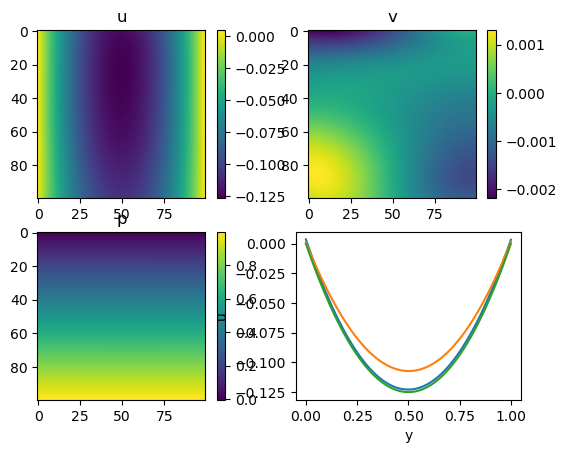

In [29]:

t_bc=np.zeros(1)
x_bc=np.linspace(0,10,100)
y_bc=np.linspace(0,1,100)
t_bcm,x_bcm, y_bcm=np.meshgrid(t_bc,x_bc,y_bc)
t_bcm=np.reshape(t_bcm,(10000,1))
x_bcm=np.reshape(x_bcm,(10000,1))
y_bcm=np.reshape(y_bcm,(10000,1))
pt_t_bc= Variable(torch.from_numpy(t_bcm).float(), requires_grad=True).to(device)
pt_x_bc= Variable(torch.from_numpy(x_bcm).float(), requires_grad=True).to(device)
pt_y_bc= Variable(torch.from_numpy(y_bcm).float(), requires_grad=True).to(device)
psi=model(pt_t_bc,pt_x_bc,pt_y_bc)[:,0]
print(np.shape(psi))
p=model(pt_t_bc,pt_x_bc,pt_y_bc)[:,1]
u = torch.autograd.grad(psi.sum(), pt_y_bc, create_graph=True)[0]
v = -torch.autograd.grad(psi.sum(), pt_x_bc, create_graph=True)[0]
plt.subplot(2,2,1)
plt.imshow(u.detach().numpy().reshape((100,100)))
plt.title('u')
plt.colorbar()
plt.subplot(2,2,2)
plt.imshow(v.detach().numpy().reshape((100,100)))
plt.title('v')
plt.colorbar()
plt.subplot(2,2,3)
plt.imshow(p.detach().numpy().reshape((100,100)))
plt.title('p')
plt.colorbar()
plt.subplot(2,2,4)
plt.plot(np.linspace(0,1,100),u.detach().numpy().reshape((100,100))[0,:])
plt.plot(np.linspace(0,1,100),u.detach().numpy().reshape((100,100))[-1,:])
plt.plot(np.linspace(0,1,100),(np.linspace(0,1,100)-0.5)**2*0.5-0.125)
plt.xlabel('y')
plt.ylabel('u')
#plt.plot(t_test, np.sin(t_test))